# HOUSE PRICE PREDICTION

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview



##### Goal
we need to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

##### Metric
model will be evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#reading the train and test data 
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [5]:
train.shape

(1460, 81)

In [6]:
test.shape

(1459, 80)

In [7]:
train_id=train['Id']
test_id=test['Id']

#Concatenating
data= pd.concat([train,test],axis=0,ignore_index=True,sort=False)

### Data Preprocessing

##### Missing Value Treatment

In [8]:
a= pd.DataFrame(data.isnull().sum(),columns=['Sum'])
a.loc[a['Sum']>0,:]

,Sum
MSZoning,4
LotFrontage,486
Alley,2721
Utilities,2
Exterior1st,1
Exterior2nd,1
MasVnrType,24
MasVnrArea,23
BsmtQual,81
BsmtCond,82


As we can see below columns have more than 60% of nan values so will drop these columns and ID col is of no use.

Alley             

PoolQC           

Fence          

MiscFeature      

In [9]:
drop_col= ['Id','Alley','PoolQC','Fence','MiscFeature']
new= data.drop(drop_col, axis=1)

In [10]:
# FireplaceQu : data description says NA means "no fireplace", so will replave nan with none
new['FireplaceQu'].fillna('None', inplace=True)

GarageType, GarageFinish, GarageQual and GarageCond : missing means no garage Replacing missing data with None

BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.



In [11]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    new[col].fillna('None',inplace=True)

LotFrontage : Since the area of each street connected to the house property
most likely have a similar area to other houses in its neighborhood ,
we can fill in missing values by the median LotFrontage of the neighborhood.
Here i am imputing the Lotfrontage with neighbourhood

In [12]:
new['LotFrontage']=new.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement.
GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [13]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    new[col].fillna(0,inplace=True)

MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses.
We can fill 0 for the area and None for the type.

In [14]:
new['MasVnrArea'].fillna(0,inplace=True)
new['MasVnrType'].fillna('None',inplace=True)

MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [15]:
new['MSZoning'].fillna(new['MSZoning'].value_counts()[0],inplace=True)

Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [16]:
new['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [17]:
new.drop('Utilities',axis=1,inplace=True)

In [18]:
for col in ('Exterior1st', 'Exterior2nd', 'Electrical', 'KitchenQual', 'Functional','SaleType'):
    new[col].fillna(new[col].value_counts()[0],inplace=True)

In [19]:
a= pd.DataFrame(new.isnull().sum(),columns=['Sum'])
a.loc[a['Sum']>0,:]

,Sum
SalePrice,1459


As sales price is missing from test, we can avoid it

In [20]:
train1= new.iloc[0:1460,:]
test1= new.iloc[1460:,:]

In [21]:
train1.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,60,RL,62.0,7917,Pave,Reg,Lvl,Inside,Gtl,Gilbert,...,0,0,0,0,0,8,2007,WD,Normal,175000.0
1456,20,RL,85.0,13175,Pave,Reg,Lvl,Inside,Gtl,NWAmes,...,0,0,0,0,0,2,2010,WD,Normal,210000.0
1457,70,RL,66.0,9042,Pave,Reg,Lvl,Inside,Gtl,Crawfor,...,0,0,0,0,2500,5,2010,WD,Normal,266500.0
1458,20,RL,68.0,9717,Pave,Reg,Lvl,Inside,Gtl,NAmes,...,112,0,0,0,0,4,2010,WD,Normal,142125.0
1459,20,RL,75.0,9937,Pave,Reg,Lvl,Inside,Gtl,Edwards,...,0,0,0,0,0,6,2008,WD,Normal,147500.0


In [22]:
test1.drop('SalePrice',axis=1,inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
test1.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1460,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,NAmes,...,0,0,0,120,0,0,6,2010,WD,Normal
1461,20,RL,81.0,14267,Pave,IR1,Lvl,Corner,Gtl,NAmes,...,36,0,0,0,0,12500,6,2010,WD,Normal
1462,60,RL,74.0,13830,Pave,IR1,Lvl,Inside,Gtl,Gilbert,...,34,0,0,0,0,0,3,2010,WD,Normal
1463,60,RL,78.0,9978,Pave,IR1,Lvl,Inside,Gtl,Gilbert,...,36,0,0,0,0,0,6,2010,WD,Normal
1464,120,RL,43.0,5005,Pave,IR1,HLS,Inside,Gtl,StoneBr,...,82,0,0,144,0,0,1,2010,WD,Normal


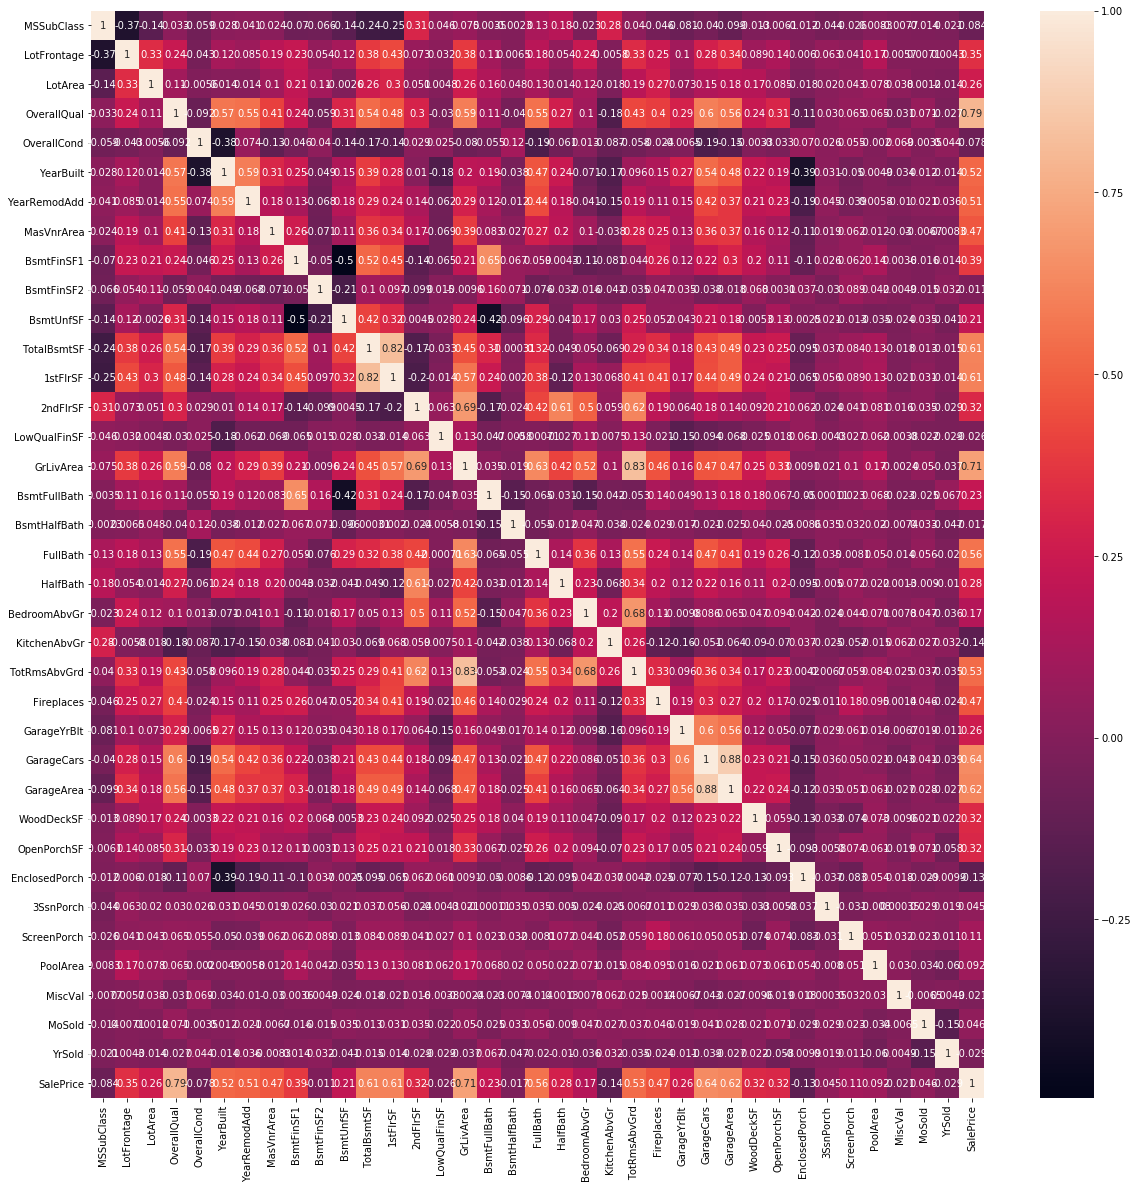

In [24]:
plt.figure(figsize=(20,20))

coorelation = train1.corr()
sns.heatmap(coorelation,annot=True)

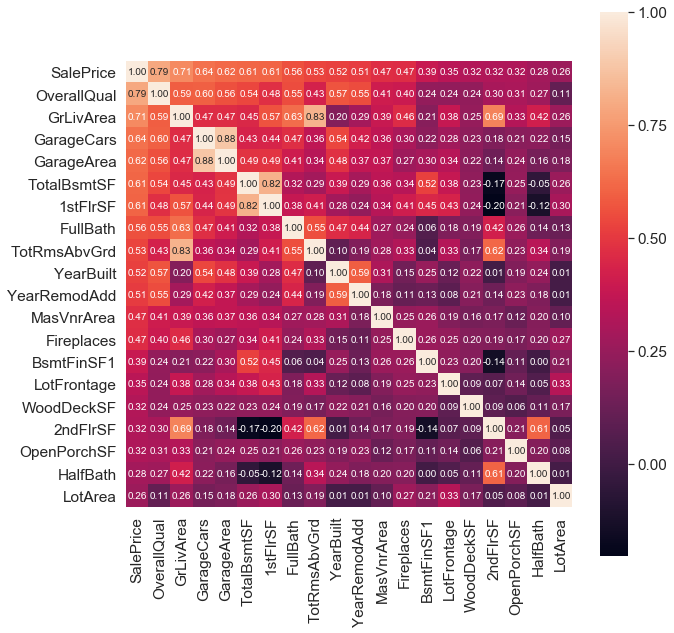

In [25]:
plt.figure(figsize=(10,10))
k = 20
cols = coorelation.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train1[cols].values.T)
sns.set(font_scale=1.4)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Taking top features to check ouliers

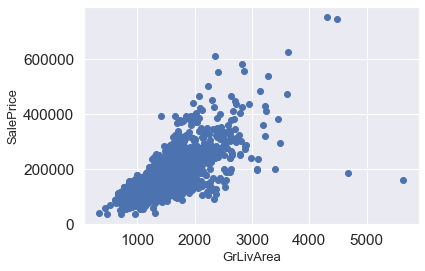

In [26]:
fig, ax = plt.subplots()
ax.scatter(x = train1['GrLivArea'], y = train1['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

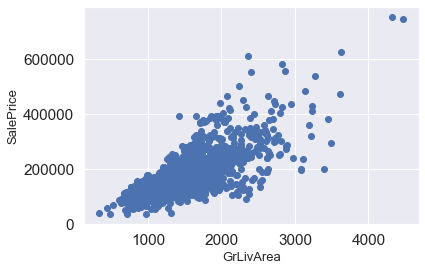

In [27]:
# delete outliers: large GrLivArea but low price
train1 = train1.drop(train1[(train1['GrLivArea'] > 4000) & (train1['SalePrice'] < 300000)].index)

fig, ax = plt.subplots()
ax.scatter(train1['GrLivArea'], train1['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

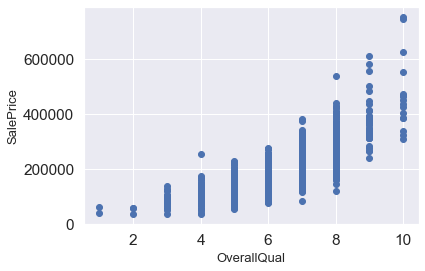

In [28]:
fig, ax = plt.subplots()
ax.scatter(x = train1['OverallQual'], y = train1['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()

Normal dist. ($\mu=$ 180932.92 and $\sigma=$ 79467.79 )


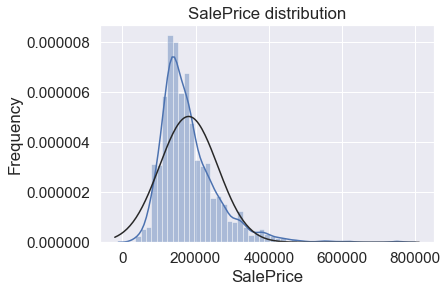

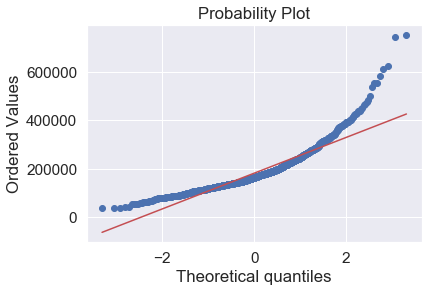

In [29]:
from scipy import stats
from scipy.stats import norm, skew
sns.distplot(train1['SalePrice'],fit=norm);

(mu, sigma) = norm.fit(train1['SalePrice'])
print('Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma))

# plot SalePrice distribution
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train1['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed. Since linear models require variables to be normally distributed, we can transform this variable and make it more normally distributed.

Normal dist. ($\mu=$ 12.02 and $\sigma=$ 0.40 )


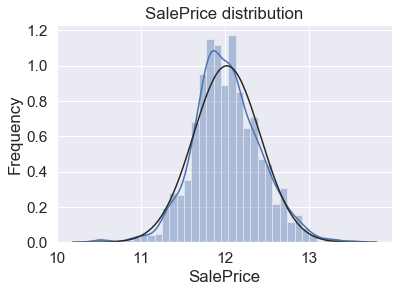

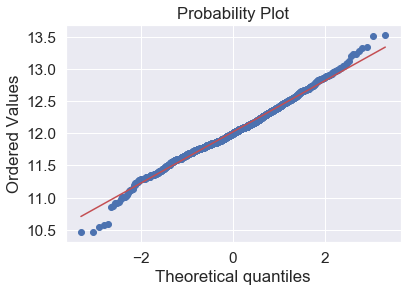

In [30]:
# use np.log1p which applies log(1+x) to all elements of the column
train1['SalePrice'] = np.log1p(train1['SalePrice'])

# plot the two graphs again
sns.distplot(train1['SalePrice'],fit=norm);

(mu, sigma) = norm.fit(train1['SalePrice'])
print('Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma))

# plot SalePrice distribution
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train1['SalePrice'], plot=plt)
plt.show()

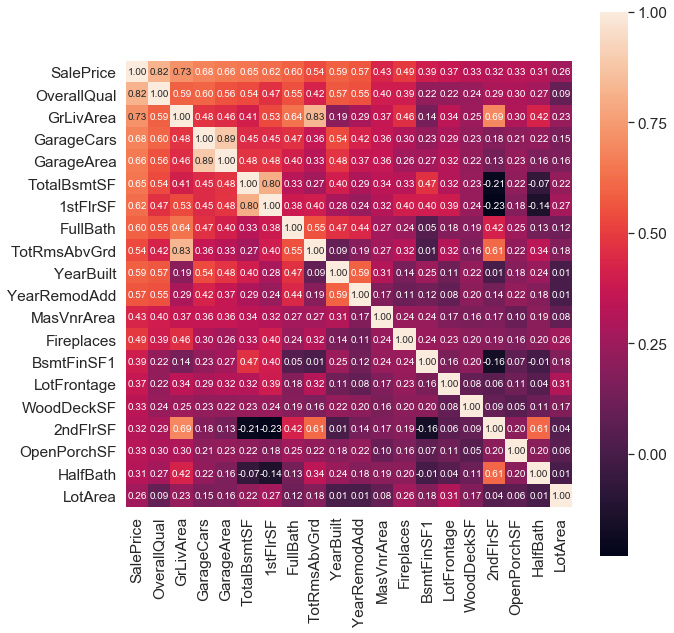

In [31]:
plt.figure(figsize=(10,10))
k = 20
cols = coorelation.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train1[cols].values.T)
sns.set(font_scale=1.4)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

1. GrLivArea and Total RMSABVFrd are highly orrelated so we will use GrLiv area as it has more relation with salesprice
2. GarageCars and GarageArea are highly correlated variables,Therefore, we can remove GarageArea and keep GarageCars since GarageCars has a higher correlation with SalePrice.


In [32]:
new.drop(['TotRmsAbvGrd','GarageArea'],axis=1,inplace=True)

In [33]:
# Transforming some numerical variables that are really categorical
for col in ('MSSubClass','OverallCond','YrSold','MoSold'):
    print(col,new[col].value_counts())
    new[col]= new[col].astype(str)

MSSubClass 20     1079
60      575
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64
OverallCond 5    1645
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64
YrSold 2007    692
2009    647
2008    622
2006    619
2010    339
Name: YrSold, dtype: int64
MoSold 6     503
7     446
5     394
4     279
8     233
3     232
10    173
9     158
11    142
2     133
1     122
12    104
Name: MoSold, dtype: int64


In [34]:
#Making total surface area by adding basement first and second floor
new['totalsf']= new['TotalBsmtSF'] + new['1stFlrSF'] + new['2ndFlrSF']

In [35]:
num= [x for x in new.columns if new[x].dtypes not in ('object','str')]
non_num= [x for x in new.columns if new[x].dtypes in ('object','str')]

In [36]:
#now making label encoding and dummy variable
for col in non_num:
    print(new[col].value_counts())

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64
RL         2265
RM          460
FV          139
RH           26
C (all)      25
2265          4
Name: MSZoning, dtype: int64
Pave    2907
Grvl      12
Name: Street, dtype: int64
Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64
Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64
Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64
Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU      

In [37]:
len(new.describe().columns)

32

In [38]:
len(non_num)

42

In [39]:
len(num)

32

In [40]:
new.shape

(2919, 74)

In [41]:
#Label Encoding some categorical variables that may contain information in their ordering set

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(new[c].values)) 
    new[c] = lbl.transform(list(new[c].values))

# shape        
print('Shape all_data: {}'.format(new.shape))

Shape all_data: (2919, 74)


In [42]:
new= pd.get_dummies(new,drop_first=True)
new.shape

(2919, 198)

In [43]:
train2= new.iloc[0:1460,:]
test2= new.iloc[1460:,:].drop('SalePrice',axis=1)

In [44]:
train2.tail()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1455,10,62.0,7917,1,3,0,6,4,1999,2000,...,0,0,0,0,1,0,0,0,1,0
1456,5,85.0,13175,1,3,0,6,5,1978,1988,...,0,0,0,0,1,0,0,0,1,0
1457,11,66.0,9042,1,3,0,7,8,1941,2006,...,0,0,0,0,1,0,0,0,1,0
1458,5,68.0,9717,1,3,0,5,5,1950,1996,...,0,0,0,0,1,0,0,0,1,0
1459,5,75.0,9937,1,3,0,5,5,1965,1965,...,0,0,0,0,1,0,0,0,1,0


In [45]:
test2.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1460,5,80.0,11622,1,3,0,5,5,1961,1961,...,0,0,0,0,1,0,0,0,1,0
1461,5,81.0,14267,1,0,0,6,5,1958,1958,...,0,0,0,0,1,0,0,0,1,0
1462,10,74.0,13830,1,0,0,5,4,1997,1998,...,0,0,0,0,1,0,0,0,1,0
1463,10,78.0,9978,1,0,0,6,5,1998,1998,...,0,0,0,0,1,0,0,0,1,0
1464,0,43.0,5005,1,0,0,8,4,1992,1992,...,0,0,0,0,1,0,0,0,1,0


In [46]:
x= train2.drop('SalePrice',axis=1).values
y= train2['SalePrice'].values 

In [111]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,r2_score, accuracy_score
from xgboost import XGBRegressor

In [48]:
kf= KFold(n_splits=5,shuffle=True,random_state=10)

In [49]:
reg= LinearRegression()

lreg= Lasso(alpha=0.1)

GBoost = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5) #loss huber is prone to outliers

rf= RandomForestRegressor(n_estimators=300,max_depth=4,min_samples_leaf=5,min_samples_split=10)

xgb= XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)


In [50]:
score=[]
rmse=[]
r2=[]
for train_ix, test_ix in kf.split(x,y):
    pipeline= make_pipeline(RobustScaler(),xgb)
    model= pipeline.fit(x[train_ix],y[train_ix])
    score.append(model.score(x[test_ix],y[test_ix]))
    rmse.append(np.sqrt(mean_squared_error(y[test_ix],model.predict(x[test_ix]))))
    r2.append(r2_score(y[test_ix],model.predict(x[test_ix])))
    
print('Score:{}, Rmse:{}, R2: {}'.format(np.mean(score),np.mean(rmse),np.mean(r2)))

Score:0.8420808608662039, Rmse:28713.238165147683, R2: 0.842080860866204


In [51]:
score=[]
rmse=[]
r2=[]
for train_ix, test_ix in kf.split(x,y):
    pipeline= make_pipeline(RobustScaler(),rf)
    model= pipeline.fit(x[train_ix],y[train_ix])
    score.append(model.score(x[test_ix],y[test_ix]))
    rmse.append(np.sqrt(mean_squared_error(y[test_ix],model.predict(x[test_ix]))))
    r2.append(r2_score(y[test_ix],model.predict(x[test_ix])))
    
print('Score:{}, Rmse:{}, R2: {}'.format(np.mean(score),np.mean(rmse),np.mean(r2)))

Score:0.8003880436629338, Rmse:34743.58600139555, R2: 0.8003880436629338


In [136]:
score=[]
rmse=[]
r2=[]
for train_ix, test_ix in kf.split(x,y):
    pipeline= make_pipeline(RobustScaler(),GBoost)
    model= pipeline.fit(x[train_ix],y[train_ix])
    score.append(model.score(x[test_ix],y[test_ix]))
    rmse.append(np.sqrt(mean_squared_error(y[test_ix],model.predict(x[test_ix]))))
    r2.append(r2_score(y[test_ix],model.predict(x[test_ix])))
    
print('Score:{}, Rmse:{}, R2: {}'.format(np.mean(score),np.mean(rmse),np.mean(r2)))

Score:0.864895943716715, Rmse:28187.18060813942, R2: 0.864895943716715


In [137]:
predictions= model.predict(test2.values)

sub= pd.DataFrame({'Id': test_id, 'SalePrice': predictions})

sub.to_csv('Submission.csv',index=False)

### Making a deep neural network

In [60]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

In [106]:
def reg():
    model= Sequential()
    model.add(Dense(units=128, activation='relu', kernel_initializer='normal', input_dim=x.shape[1]))
#     model.add(Dropout(0.2))
    model.add(Dense(units=256, activation='relu', kernel_initializer='normal'))
#     model.add(Dropout(0.2))
    model.add(Dense(units=256, activation='relu', kernel_initializer='normal'))
#     model.add(Dropout(0.2))
    model.add(Dense(units=1,kernel_initializer='normal',activation='linear')) #Linear for regression   
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model

In [107]:
regressor= KerasRegressor(build_fn=reg, batch_size=32, epochs=100)

In [115]:
rmse=[]
r2=[]
for train_ix, test_ix in kf.split(x,y):
    pipeline= make_pipeline(RobustScaler(),regressor)
    model= pipeline.fit(x[train_ix],y[train_ix])
    rmse.append(np.sqrt(mean_squared_error(y[test_ix],model.predict(x[test_ix]))))
    r2.append(r2_score(y[test_ix],model.predict(x[test_ix])))

Epoch 1/100
1168/1168 [==============================] - 6s 5ms/step - loss: 181041.3039 - mean_absolute_error: 181041.3039
Epoch 2/100
1168/1168 [==============================] - 0s 264us/step - loss: 171689.3570 - mean_absolute_error: 171689.3570
Epoch 3/100
1168/1168 [==============================] - 0s 272us/step - loss: 147022.2474 - mean_absolute_error: 147022.2474
Epoch 4/100
1168/1168 [==============================] - 0s 261us/step - loss: 131879.6909 - mean_absolute_error: 131879.6909
Epoch 5/100
1168/1168 [==============================] - 0s 272us/step - loss: 118234.1462 - mean_absolute_error: 118234.1462
Epoch 6/100
1168/1168 [==============================] - 0s 294us/step - loss: 96152.8627 - mean_absolute_error: 96152.8627
Epoch 7/100
1168/1168 [==============================] - 0s 280us/step - loss: 56210.7118 - mean_absolute_error: 56210.7118
Epoch 8/100
1168/1168 [==============================] - 0s 272us/step - loss: 37680.2539 - mean_absolute_error: 37680.2539


1168/1168 [==============================] - 0s 261us/step - loss: 16782.5138 - mean_absolute_error: 16782.5138
Epoch 67/100
1168/1168 [==============================] - 0s 254us/step - loss: 17361.7882 - mean_absolute_error: 17361.7882
Epoch 68/100
1168/1168 [==============================] - 0s 247us/step - loss: 16598.5092 - mean_absolute_error: 16598.5092
Epoch 69/100
1168/1168 [==============================] - 0s 301us/step - loss: 16243.4881 - mean_absolute_error: 16243.4881
Epoch 70/100
1168/1168 [==============================] - 0s 377us/step - loss: 16284.4028 - mean_absolute_error: 16284.4028
Epoch 71/100
1168/1168 [==============================] - 0s 311us/step - loss: 16016.5357 - mean_absolute_error: 16016.5357
Epoch 72/100
1168/1168 [==============================] - 0s 401us/step - loss: 16660.6902 - mean_absolute_error: 16660.6902
Epoch 73/100
1168/1168 [==============================] - 0s 376us/step - loss: 15970.6144 - mean_absolute_error: 15970.6144
Epoch 74/100


1168/1168 [==============================] - 0s 242us/step - loss: 22073.0885 - mean_absolute_error: 22073.0885
Epoch 32/100
1168/1168 [==============================] - 0s 241us/step - loss: 22211.9812 - mean_absolute_error: 22211.9812
Epoch 33/100
1168/1168 [==============================] - 0s 248us/step - loss: 21839.2613 - mean_absolute_error: 21839.2613
Epoch 34/100
1168/1168 [==============================] - 0s 235us/step - loss: 21566.9871 - mean_absolute_error: 21566.9871
Epoch 35/100
1168/1168 [==============================] - 0s 243us/step - loss: 21144.3466 - mean_absolute_error: 21144.3466
Epoch 36/100
1168/1168 [==============================] - 0s 244us/step - loss: 20705.1933 - mean_absolute_error: 20705.1933
Epoch 37/100
1168/1168 [==============================] - 0s 252us/step - loss: 20320.7133 - mean_absolute_error: 20320.7133
Epoch 38/100
1168/1168 [==============================] - 0s 241us/step - loss: 20267.9525 - mean_absolute_error: 20267.9525
Epoch 39/100


1168/1168 [==============================] - 0s 277us/step - loss: 14553.6893 - mean_absolute_error: 14553.6893
Epoch 97/100
1168/1168 [==============================] - 0s 236us/step - loss: 15516.9110 - mean_absolute_error: 15516.9110
Epoch 98/100
1168/1168 [==============================] - 0s 236us/step - loss: 14787.5694 - mean_absolute_error: 14787.5694
Epoch 99/100
1168/1168 [==============================] - 0s 240us/step - loss: 13710.9019 - mean_absolute_error: 13710.9019
Epoch 100/100
1168/1168 [==============================] - 0s 229us/step - loss: 13964.1379 - mean_absolute_error: 13964.1379
Epoch 1/100
1168/1168 [==============================] - 6s 5ms/step - loss: 181107.9812 - mean_absolute_error: 181107.9812
Epoch 2/100
1168/1168 [==============================] - 0s 295us/step - loss: 172894.4399 - mean_absolute_error: 172894.4399
Epoch 3/100
1168/1168 [==============================] - 0s 263us/step - loss: 148009.4129 - mean_absolute_error: 148009.4129
Epoch 4/100

1168/1168 [==============================] - 0s 317us/step - loss: 17415.5327 - mean_absolute_error: 17415.5327
Epoch 62/100
1168/1168 [==============================] - 0s 244us/step - loss: 17719.0791 - mean_absolute_error: 17719.0791
Epoch 63/100
1168/1168 [==============================] - 0s 235us/step - loss: 18761.0585 - mean_absolute_error: 18761.0585
Epoch 64/100
1168/1168 [==============================] - 0s 292us/step - loss: 18203.2387 - mean_absolute_error: 18203.2387
Epoch 65/100
1168/1168 [==============================] - 0s 420us/step - loss: 17687.5073 - mean_absolute_error: 17687.5073
Epoch 66/100
1168/1168 [==============================] - 0s 259us/step - loss: 17184.7372 - mean_absolute_error: 17184.7372
Epoch 67/100
1168/1168 [==============================] - 0s 328us/step - loss: 17461.5318 - mean_absolute_error: 17461.5318
Epoch 68/100
1168/1168 [==============================] - 0s 284us/step - loss: 17040.5025 - mean_absolute_error: 17040.5025
Epoch 69/100


1168/1168 [==============================] - 0s 229us/step - loss: 23263.8897 - mean_absolute_error: 23263.8897
Epoch 27/100
1168/1168 [==============================] - 0s 226us/step - loss: 23458.8397 - mean_absolute_error: 23458.8397
Epoch 28/100
1168/1168 [==============================] - 0s 229us/step - loss: 22671.9883 - mean_absolute_error: 22671.9883
Epoch 29/100
1168/1168 [==============================] - 0s 231us/step - loss: 22860.8015 - mean_absolute_error: 22860.8015
Epoch 30/100
1168/1168 [==============================] - 0s 305us/step - loss: 22551.5822 - mean_absolute_error: 22551.5822
Epoch 31/100
1168/1168 [==============================] - 0s 298us/step - loss: 21950.8782 - mean_absolute_error: 21950.8782
Epoch 32/100
1168/1168 [==============================] - 0s 250us/step - loss: 21124.3640 - mean_absolute_error: 21124.3640
Epoch 33/100
1168/1168 [==============================] - 0s 301us/step - loss: 21997.6015 - mean_absolute_error: 21997.6015
Epoch 34/100


1168/1168 [==============================] - 0s 225us/step - loss: 14425.8748 - mean_absolute_error: 14425.8748
Epoch 92/100
1168/1168 [==============================] - 0s 218us/step - loss: 14505.7533 - mean_absolute_error: 14505.7533
Epoch 93/100
1168/1168 [==============================] - 0s 226us/step - loss: 13915.6557 - mean_absolute_error: 13915.6557
Epoch 94/100
1168/1168 [==============================] - 0s 223us/step - loss: 14298.4117 - mean_absolute_error: 14298.4117
Epoch 95/100
1168/1168 [==============================] - 0s 228us/step - loss: 13711.0321 - mean_absolute_error: 13711.0321
Epoch 96/100
1168/1168 [==============================] - 0s 222us/step - loss: 15131.7717 - mean_absolute_error: 15131.7717
Epoch 97/100
1168/1168 [==============================] - 0s 218us/step - loss: 13966.2642 - mean_absolute_error: 13966.2642
Epoch 98/100
1168/1168 [==============================] - 0s 218us/step - loss: 13831.5393 - mean_absolute_error: 13831.5393
Epoch 99/100


1168/1168 [==============================] - 0s 265us/step - loss: 16928.2687 - mean_absolute_error: 16928.2687
Epoch 57/100
1168/1168 [==============================] - 0s 357us/step - loss: 16614.1009 - mean_absolute_error: 16614.1009
Epoch 58/100
1168/1168 [==============================] - 0s 242us/step - loss: 16675.3818 - mean_absolute_error: 16675.3818
Epoch 59/100
1168/1168 [==============================] - 0s 318us/step - loss: 16463.2856 - mean_absolute_error: 16463.2856
Epoch 60/100
1168/1168 [==============================] - 0s 242us/step - loss: 16944.7263 - mean_absolute_error: 16944.7263
Epoch 61/100
1168/1168 [==============================] - 0s 241us/step - loss: 16858.5233 - mean_absolute_error: 16858.5233
Epoch 62/100
1168/1168 [==============================] - 0s 381us/step - loss: 16139.2353 - mean_absolute_error: 16139.2353
Epoch 63/100
1168/1168 [==============================] - 0s 253us/step - loss: 16424.7431 - mean_absolute_error: 16424.7431
Epoch 64/100


In [116]:
print('Rmse:{}, R2: {}'.format(np.mean(rmse),np.mean(r2)))

Rmse:38221.90143847002, R2: 0.7284543236159668


In [119]:
predictions= model.predict(test2.values)

sub= pd.DataFrame({'Id': test_id, 'SalePrice': predictions})

sub.to_csv('NN_Submission.csv',index=False)

In [124]:
def reg(optimizer,kernel):
    model= Sequential()
    model.add(Dense(units=128, activation='relu', kernel_initializer=kernel, input_dim=x.shape[1]))
#     model.add(Dropout(0.2))
    model.add(Dense(units=256, activation='relu', kernel_initializer=kernel))
#     model.add(Dropout(0.2))
    model.add(Dense(units=256, activation='relu', kernel_initializer=kernel))
#     model.add(Dropout(0.2))
    model.add(Dense(units=1,kernel_initializer=kernel,activation='relu'))    
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])
    return model

regressor= KerasRegressor(build_fn=reg)

from sklearn.model_selection import GridSearchCV

parameters = {'batch_size': [50, 32],
              'epochs': [100,150,200],
              'kernel':['normal','uniform'],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = regressor,
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error'
                           )

In [125]:
# fitting the model and Calculating the best parameters.
grid_search = grid_search.fit(x, y)
best_parameters = grid_search.best_params_

Epoch 1/100
973/973 [==============================] - 6s 6ms/step - loss: 174229.8603 - mean_absolute_error: 174229.8603
Epoch 2/100
973/973 [==============================] - 0s 179us/step - loss: 95503.3684 - mean_absolute_error: 95503.3684
Epoch 3/100
973/973 [==============================] - 0s 162us/step - loss: 49511.0122 - mean_absolute_error: 49511.0122
Epoch 4/100
973/973 [==============================] - 0s 179us/step - loss: 41695.8683 - mean_absolute_error: 41695.8683
Epoch 5/100
973/973 [==============================] - 0s 214us/step - loss: 38901.4470 - mean_absolute_error: 38901.4470
Epoch 6/100
973/973 [==============================] - 0s 179us/step - loss: 36716.7095 - mean_absolute_error: 36716.7095
Epoch 7/100
973/973 [==============================] - 0s 177us/step - loss: 34276.6755 - mean_absolute_error: 34276.6755
Epoch 8/100
973/973 [==============================] - 0s 176us/step - loss: 32715.6831 - mean_absolute_error: 32715.6831
Epoch 9/100
973/973 [===

973/973 [==============================] - 0s 181us/step - loss: 25686.9931 - mean_absolute_error: 25686.9931
Epoch 68/100
973/973 [==============================] - 0s 150us/step - loss: 25563.2544 - mean_absolute_error: 25563.2544
Epoch 69/100
973/973 [==============================] - 0s 177us/step - loss: 26435.7363 - mean_absolute_error: 26435.7363
Epoch 70/100
973/973 [==============================] - 0s 157us/step - loss: 25671.0143 - mean_absolute_error: 25671.0143
Epoch 71/100
973/973 [==============================] - 0s 150us/step - loss: 26386.4229 - mean_absolute_error: 26386.4229
Epoch 72/100
973/973 [==============================] - 0s 157us/step - loss: 27463.9474 - mean_absolute_error: 27463.9474
Epoch 73/100
973/973 [==============================] - 0s 157us/step - loss: 26376.3905 - mean_absolute_error: 26376.3905
Epoch 74/100
973/973 [==============================] - 0s 207us/step - loss: 25503.0724 - mean_absolute_error: 25503.0724
Epoch 75/100
973/973 [=======

973/973 [==============================] - 0s 151us/step - loss: 27994.2097 - mean_absolute_error: 27994.2097
Epoch 34/100
973/973 [==============================] - 0s 149us/step - loss: 28024.3360 - mean_absolute_error: 28024.3360
Epoch 35/100
973/973 [==============================] - 0s 150us/step - loss: 28406.2431 - mean_absolute_error: 28406.2431
Epoch 36/100
973/973 [==============================] - 0s 151us/step - loss: 28297.0737 - mean_absolute_error: 28297.0737
Epoch 37/100
973/973 [==============================] - 0s 144us/step - loss: 29023.2624 - mean_absolute_error: 29023.2624
Epoch 38/100
973/973 [==============================] - 0s 149us/step - loss: 27989.1217 - mean_absolute_error: 27989.1217
Epoch 39/100
973/973 [==============================] - 0s 149us/step - loss: 28246.7762 - mean_absolute_error: 28246.7762
Epoch 40/100
973/973 [==============================] - 0s 145us/step - loss: 28420.9840 - mean_absolute_error: 28420.9840
Epoch 41/100
973/973 [=======

973/973 [==============================] - 0s 173us/step - loss: 26904.7944 - mean_absolute_error: 26904.7944
Epoch 100/100
973/973 [==============================] - 0s 175us/step - loss: 24632.3331 - mean_absolute_error: 24632.3331
Epoch 1/100
974/974 [==============================] - 6s 7ms/step - loss: 182112.5889 - mean_absolute_error: 182112.5889
Epoch 2/100
974/974 [==============================] - 0s 147us/step - loss: 182112.5902 - mean_absolute_error: 182112.5902
Epoch 3/100
974/974 [==============================] - 0s 157us/step - loss: 182112.5901 - mean_absolute_error: 182112.5901
Epoch 4/100
974/974 [==============================] - 0s 152us/step - loss: 182112.5909 - mean_absolute_error: 182112.5909
Epoch 5/100
974/974 [==============================] - 0s 147us/step - loss: 182112.5922 - mean_absolute_error: 182112.5922
Epoch 6/100
974/974 [==============================] - 0s 152us/step - loss: 182112.5913 - mean_absolute_error: 182112.5913
Epoch 7/100
974/974 [===

974/974 [==============================] - 0s 170us/step - loss: 182112.5903 - mean_absolute_error: 182112.5903
Epoch 65/100
974/974 [==============================] - 0s 159us/step - loss: 182112.5915 - mean_absolute_error: 182112.5915
Epoch 66/100
974/974 [==============================] - 0s 156us/step - loss: 182112.5904 - mean_absolute_error: 182112.5904
Epoch 67/100
974/974 [==============================] - 0s 165us/step - loss: 182112.5908 - mean_absolute_error: 182112.5908
Epoch 68/100
974/974 [==============================] - 0s 170us/step - loss: 182112.5921 - mean_absolute_error: 182112.5921
Epoch 69/100
974/974 [==============================] - 0s 204us/step - loss: 182112.5911 - mean_absolute_error: 182112.5911
Epoch 70/100
974/974 [==============================] - 0s 154us/step - loss: 182112.5905 - mean_absolute_error: 182112.5905
Epoch 71/100
974/974 [==============================] - 0s 159us/step - loss: 182112.5903 - mean_absolute_error: 182112.5903
Epoch 72/100


973/973 [==============================] - 0s 151us/step - loss: 179726.0335 - mean_absolute_error: 179726.0335
Epoch 30/100
973/973 [==============================] - 0s 173us/step - loss: 179726.0316 - mean_absolute_error: 179726.0316
Epoch 31/100
973/973 [==============================] - 0s 204us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 32/100
973/973 [==============================] - 0s 154us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 33/100
973/973 [==============================] - 0s 155us/step - loss: 179726.0317 - mean_absolute_error: 179726.0317
Epoch 34/100
973/973 [==============================] - 0s 151us/step - loss: 179726.0324 - mean_absolute_error: 179726.0324
Epoch 35/100
973/973 [==============================] - 0s 163us/step - loss: 179726.0308 - mean_absolute_error: 179726.0308
Epoch 36/100
973/973 [==============================] - 0s 169us/step - loss: 179726.0328 - mean_absolute_error: 179726.0328
Epoch 37/100


973/973 [==============================] - 0s 181us/step - loss: 179726.0321 - mean_absolute_error: 179726.0321
Epoch 95/100
973/973 [==============================] - 0s 306us/step - loss: 179726.0323 - mean_absolute_error: 179726.0323
Epoch 96/100
973/973 [==============================] - 0s 160us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 97/100
973/973 [==============================] - 0s 164us/step - loss: 179726.0317 - mean_absolute_error: 179726.0317
Epoch 98/100
973/973 [==============================] - 0s 169us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 99/100
973/973 [==============================] - 0s 230us/step - loss: 179726.0312 - mean_absolute_error: 179726.0312
Epoch 100/100
973/973 [==============================] - 0s 166us/step - loss: 179726.0303 - mean_absolute_error: 179726.0303
Epoch 1/100
973/973 [==============================] - 6s 6ms/step - loss: 176921.9528 - mean_absolute_error: 176921.9528
Epoch 2/100
973

973/973 [==============================] - 0s 163us/step - loss: 28166.4597 - mean_absolute_error: 28166.4597
Epoch 61/100
973/973 [==============================] - 0s 159us/step - loss: 27574.8961 - mean_absolute_error: 27574.8961
Epoch 62/100
973/973 [==============================] - 0s 157us/step - loss: 27737.3654 - mean_absolute_error: 27737.3654
Epoch 63/100
973/973 [==============================] - 0s 176us/step - loss: 27682.4600 - mean_absolute_error: 27682.4600
Epoch 64/100
973/973 [==============================] - 0s 167us/step - loss: 27649.5273 - mean_absolute_error: 27649.5273
Epoch 65/100
973/973 [==============================] - 0s 168us/step - loss: 27182.2767 - mean_absolute_error: 27182.2767
Epoch 66/100
973/973 [==============================] - 0s 163us/step - loss: 27714.2447 - mean_absolute_error: 27714.2447
Epoch 67/100
973/973 [==============================] - 0s 157us/step - loss: 27039.8614 - mean_absolute_error: 27039.8614
Epoch 68/100
973/973 [=======

974/974 [==============================] - 0s 239us/step - loss: 29287.7264 - mean_absolute_error: 29287.7264
Epoch 27/100
974/974 [==============================] - 0s 218us/step - loss: 29558.8050 - mean_absolute_error: 29558.8050
Epoch 28/100
974/974 [==============================] - 0s 321us/step - loss: 28050.2096 - mean_absolute_error: 28050.2096
Epoch 29/100
974/974 [==============================] - 0s 290us/step - loss: 28914.2078 - mean_absolute_error: 28914.2078
Epoch 30/100
974/974 [==============================] - 0s 314us/step - loss: 28748.3152 - mean_absolute_error: 28748.3152
Epoch 31/100
974/974 [==============================] - 0s 162us/step - loss: 28720.3678 - mean_absolute_error: 28720.3678
Epoch 32/100
974/974 [==============================] - 0s 155us/step - loss: 27743.8154 - mean_absolute_error: 27743.8154
Epoch 33/100
974/974 [==============================] - 0s 157us/step - loss: 28202.1414 - mean_absolute_error: 28202.1414
Epoch 34/100
974/974 [=======

974/974 [==============================] - 0s 149us/step - loss: 26111.0194 - mean_absolute_error: 26111.0194
Epoch 93/100
974/974 [==============================] - 0s 147us/step - loss: 25835.9340 - mean_absolute_error: 25835.9340
Epoch 94/100
974/974 [==============================] - 0s 145us/step - loss: 25462.3054 - mean_absolute_error: 25462.3054
Epoch 95/100
974/974 [==============================] - 0s 145us/step - loss: 25903.0404 - mean_absolute_error: 25903.0404
Epoch 96/100
974/974 [==============================] - 0s 141us/step - loss: 25139.8833 - mean_absolute_error: 25139.8833
Epoch 97/100
974/974 [==============================] - 0s 140us/step - loss: 25391.8372 - mean_absolute_error: 25391.8372
Epoch 98/100
974/974 [==============================] - 0s 149us/step - loss: 25284.7171 - mean_absolute_error: 25284.7171
Epoch 99/100
974/974 [==============================] - 0s 156us/step - loss: 25567.2893 - mean_absolute_error: 25567.2893
Epoch 100/100
974/974 [======

973/973 [==============================] - 0s 160us/step - loss: 27703.9877 - mean_absolute_error: 27703.9877
Epoch 59/100
973/973 [==============================] - 0s 199us/step - loss: 26816.6229 - mean_absolute_error: 26816.6229
Epoch 60/100
973/973 [==============================] - 0s 184us/step - loss: 26333.5362 - mean_absolute_error: 26333.5362
Epoch 61/100
973/973 [==============================] - 0s 190us/step - loss: 26243.4762 - mean_absolute_error: 26243.4762
Epoch 62/100
973/973 [==============================] - 0s 169us/step - loss: 26047.8201 - mean_absolute_error: 26047.8201
Epoch 63/100
973/973 [==============================] - 0s 161us/step - loss: 26240.3229 - mean_absolute_error: 26240.3229
Epoch 64/100
973/973 [==============================] - 0s 166us/step - loss: 26509.1968 - mean_absolute_error: 26509.1968
Epoch 65/100
973/973 [==============================] - 0s 152us/step - loss: 25766.0955 - mean_absolute_error: 25766.0955
Epoch 66/100
973/973 [=======

973/973 [==============================] - 0s 177us/step - loss: 29490.6248 - mean_absolute_error: 29490.6248
Epoch 25/100
973/973 [==============================] - 0s 164us/step - loss: 28781.3994 - mean_absolute_error: 28781.3994
Epoch 26/100
973/973 [==============================] - 0s 166us/step - loss: 28846.8148 - mean_absolute_error: 28846.8148
Epoch 27/100
973/973 [==============================] - 0s 154us/step - loss: 28846.5339 - mean_absolute_error: 28846.5339
Epoch 28/100
973/973 [==============================] - 0s 160us/step - loss: 28715.0530 - mean_absolute_error: 28715.0530
Epoch 29/100
973/973 [==============================] - 0s 155us/step - loss: 29486.5056 - mean_absolute_error: 29486.5056
Epoch 30/100
973/973 [==============================] - 0s 255us/step - loss: 28953.4081 - mean_absolute_error: 28953.4081
Epoch 31/100
973/973 [==============================] - 0s 188us/step - loss: 28937.5342 - mean_absolute_error: 28937.5342
Epoch 32/100
973/973 [=======

973/973 [==============================] - 0s 162us/step - loss: 25522.8364 - mean_absolute_error: 25522.8364
Epoch 91/100
973/973 [==============================] - 0s 173us/step - loss: 25232.2417 - mean_absolute_error: 25232.2417
Epoch 92/100
973/973 [==============================] - 0s 172us/step - loss: 25836.6081 - mean_absolute_error: 25836.6081
Epoch 93/100
973/973 [==============================] - 0s 157us/step - loss: 25942.1089 - mean_absolute_error: 25942.1089
Epoch 94/100
973/973 [==============================] - 0s 172us/step - loss: 25717.7018 - mean_absolute_error: 25717.7018
Epoch 95/100
973/973 [==============================] - 0s 200us/step - loss: 25320.9655 - mean_absolute_error: 25320.9655
Epoch 96/100
973/973 [==============================] - 0s 163us/step - loss: 25745.1494 - mean_absolute_error: 25745.1494
Epoch 97/100
973/973 [==============================] - 0s 157us/step - loss: 25119.2969 - mean_absolute_error: 25119.2969
Epoch 98/100
973/973 [=======

974/974 [==============================] - 0s 176us/step - loss: 26139.3725 - mean_absolute_error: 26139.3725
Epoch 57/100
974/974 [==============================] - 0s 176us/step - loss: 26787.4188 - mean_absolute_error: 26787.4188
Epoch 58/100
974/974 [==============================] - 0s 162us/step - loss: 26331.4777 - mean_absolute_error: 26331.4777
Epoch 59/100
974/974 [==============================] - 0s 173us/step - loss: 25649.8789 - mean_absolute_error: 25649.8789
Epoch 60/100
974/974 [==============================] - 0s 165us/step - loss: 25960.5972 - mean_absolute_error: 25960.5972
Epoch 61/100
974/974 [==============================] - 0s 152us/step - loss: 25793.5318 - mean_absolute_error: 25793.5318
Epoch 62/100
974/974 [==============================] - 0s 153us/step - loss: 25861.7560 - mean_absolute_error: 25861.7560
Epoch 63/100
974/974 [==============================] - 0s 162us/step - loss: 26153.0224 - mean_absolute_error: 26153.0224
Epoch 64/100
974/974 [=======

973/973 [==============================] - 0s 151us/step - loss: 29629.4305 - mean_absolute_error: 29629.4305
Epoch 23/100
973/973 [==============================] - 0s 151us/step - loss: 30222.5571 - mean_absolute_error: 30222.5571
Epoch 24/100
973/973 [==============================] - 0s 149us/step - loss: 29547.1974 - mean_absolute_error: 29547.1974
Epoch 25/100
973/973 [==============================] - 0s 146us/step - loss: 30010.0566 - mean_absolute_error: 30010.0566
Epoch 26/100
973/973 [==============================] - 0s 147us/step - loss: 29823.0638 - mean_absolute_error: 29823.0638
Epoch 27/100
973/973 [==============================] - 0s 146us/step - loss: 29695.6252 - mean_absolute_error: 29695.6252
Epoch 28/100
973/973 [==============================] - 0s 202us/step - loss: 29766.4596 - mean_absolute_error: 29766.4596
Epoch 29/100
973/973 [==============================] - 0s 187us/step - loss: 29882.2024 - mean_absolute_error: 29882.2024
Epoch 30/100
973/973 [=======

973/973 [==============================] - 0s 158us/step - loss: 27155.9124 - mean_absolute_error: 27155.9124
Epoch 89/100
973/973 [==============================] - 0s 154us/step - loss: 27473.7760 - mean_absolute_error: 27473.7760
Epoch 90/100
973/973 [==============================] - 0s 144us/step - loss: 27519.7113 - mean_absolute_error: 27519.7113
Epoch 91/100
973/973 [==============================] - 0s 148us/step - loss: 27215.8976 - mean_absolute_error: 27215.8976
Epoch 92/100
973/973 [==============================] - 0s 148us/step - loss: 27266.6528 - mean_absolute_error: 27266.6528
Epoch 93/100
973/973 [==============================] - 0s 145us/step - loss: 27306.5772 - mean_absolute_error: 27306.5772
Epoch 94/100
973/973 [==============================] - 0s 142us/step - loss: 26608.8182 - mean_absolute_error: 26608.8182
Epoch 95/100
973/973 [==============================] - 0s 147us/step - loss: 27464.3982 - mean_absolute_error: 27464.3982
Epoch 96/100
973/973 [=======

973/973 [==============================] - 0s 225us/step - loss: 28541.4778 - mean_absolute_error: 28541.4778
Epoch 55/100
973/973 [==============================] - 0s 283us/step - loss: 29019.1889 - mean_absolute_error: 29019.1889
Epoch 56/100
973/973 [==============================] - 0s 183us/step - loss: 28574.6433 - mean_absolute_error: 28574.6433
Epoch 57/100
973/973 [==============================] - 0s 164us/step - loss: 28167.1111 - mean_absolute_error: 28167.1111
Epoch 58/100
973/973 [==============================] - 0s 170us/step - loss: 28804.2718 - mean_absolute_error: 28804.2718
Epoch 59/100
973/973 [==============================] - 0s 291us/step - loss: 28122.2157 - mean_absolute_error: 28122.2157
Epoch 60/100
973/973 [==============================] - 0s 195us/step - loss: 28568.6059 - mean_absolute_error: 28568.6059
Epoch 61/100
973/973 [==============================] - 0s 166us/step - loss: 28217.8972 - mean_absolute_error: 28217.8972
Epoch 62/100
973/973 [=======

974/974 [==============================] - 0s 183us/step - loss: 29508.8516 - mean_absolute_error: 29508.8516
Epoch 21/100
974/974 [==============================] - 0s 179us/step - loss: 28500.2427 - mean_absolute_error: 28500.2427
Epoch 22/100
974/974 [==============================] - 0s 179us/step - loss: 30046.0861 - mean_absolute_error: 30046.0861
Epoch 23/100
974/974 [==============================] - 0s 186us/step - loss: 28687.9379 - mean_absolute_error: 28687.9379
Epoch 24/100
974/974 [==============================] - 0s 200us/step - loss: 28790.9842 - mean_absolute_error: 28790.9842
Epoch 25/100
974/974 [==============================] - 0s 183us/step - loss: 29099.3332 - mean_absolute_error: 29099.3332
Epoch 26/100
974/974 [==============================] - 0s 203us/step - loss: 28711.7656 - mean_absolute_error: 28711.7656
Epoch 27/100
974/974 [==============================] - 0s 168us/step - loss: 28830.3415 - mean_absolute_error: 28830.3415
Epoch 28/100
974/974 [=======

974/974 [==============================] - 0s 167us/step - loss: 26269.1856 - mean_absolute_error: 26269.1856
Epoch 87/100
974/974 [==============================] - 0s 159us/step - loss: 26039.0460 - mean_absolute_error: 26039.0460
Epoch 88/100
974/974 [==============================] - 0s 163us/step - loss: 26386.1011 - mean_absolute_error: 26386.1011
Epoch 89/100
974/974 [==============================] - 0s 177us/step - loss: 25486.5545 - mean_absolute_error: 25486.5545
Epoch 90/100
974/974 [==============================] - 0s 173us/step - loss: 26682.8647 - mean_absolute_error: 26682.8647
Epoch 91/100
974/974 [==============================] - 0s 165us/step - loss: 26223.7088 - mean_absolute_error: 26223.7088
Epoch 92/100
974/974 [==============================] - 0s 165us/step - loss: 25482.0931 - mean_absolute_error: 25482.0931
Epoch 93/100
974/974 [==============================] - 0s 168us/step - loss: 26346.8068 - mean_absolute_error: 26346.8068
Epoch 94/100
974/974 [=======

Epoch 52/150
973/973 [==============================] - 0s 182us/step - loss: 179726.0325 - mean_absolute_error: 179726.0325
Epoch 53/150
973/973 [==============================] - 0s 174us/step - loss: 179726.0316 - mean_absolute_error: 179726.0316
Epoch 54/150
973/973 [==============================] - 0s 174us/step - loss: 179726.0306 - mean_absolute_error: 179726.0306
Epoch 55/150
973/973 [==============================] - 0s 173us/step - loss: 179726.0321 - mean_absolute_error: 179726.0321
Epoch 56/150
973/973 [==============================] - 0s 172us/step - loss: 179726.0316 - mean_absolute_error: 179726.0316
Epoch 57/150
973/973 [==============================] - 0s 168us/step - loss: 179726.0321 - mean_absolute_error: 179726.0321
Epoch 58/150
973/973 [==============================] - 0s 169us/step - loss: 179726.0332 - mean_absolute_error: 179726.0332
Epoch 59/150
973/973 [==============================] - 0s 176us/step - loss: 179726.0329 - mean_absolute_error: 179726.0329


973/973 [==============================] - 0s 174us/step - loss: 179726.0326 - mean_absolute_error: 179726.0326
Epoch 118/150
973/973 [==============================] - 0s 175us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 119/150
973/973 [==============================] - 0s 192us/step - loss: 179726.0331 - mean_absolute_error: 179726.0331
Epoch 120/150
973/973 [==============================] - 0s 183us/step - loss: 179726.0332 - mean_absolute_error: 179726.0332
Epoch 121/150
973/973 [==============================] - 0s 182us/step - loss: 179726.0322 - mean_absolute_error: 179726.0322
Epoch 122/150
973/973 [==============================] - 0s 192us/step - loss: 179726.0317 - mean_absolute_error: 179726.0317
Epoch 123/150
973/973 [==============================] - 0s 171us/step - loss: 179726.0325 - mean_absolute_error: 179726.0325
Epoch 124/150
973/973 [==============================] - 0s 173us/step - loss: 179726.0316 - mean_absolute_error: 179726.0316
Epoch 

Epoch 33/150
973/973 [==============================] - 0s 320us/step - loss: 28884.9241 - mean_absolute_error: 28884.9241
Epoch 34/150
973/973 [==============================] - 0s 270us/step - loss: 28199.2493 - mean_absolute_error: 28199.2493
Epoch 35/150
973/973 [==============================] - 0s 298us/step - loss: 28754.4598 - mean_absolute_error: 28754.4598
Epoch 36/150
973/973 [==============================] - 0s 291us/step - loss: 28606.3141 - mean_absolute_error: 28606.3141
Epoch 37/150
973/973 [==============================] - 0s 274us/step - loss: 28117.6943 - mean_absolute_error: 28117.6943
Epoch 38/150
973/973 [==============================] - 0s 318us/step - loss: 28122.5270 - mean_absolute_error: 28122.5270
Epoch 39/150
973/973 [==============================] - 0s 219us/step - loss: 28446.8235 - mean_absolute_error: 28446.8235
Epoch 40/150
973/973 [==============================] - 0s 207us/step - loss: 28172.8342 - mean_absolute_error: 28172.8342
Epoch 41/150
973

973/973 [==============================] - 0s 226us/step - loss: 24609.1637 - mean_absolute_error: 24609.1637
Epoch 100/150
973/973 [==============================] - 0s 215us/step - loss: 24647.0764 - mean_absolute_error: 24647.0764
Epoch 101/150
973/973 [==============================] - 0s 211us/step - loss: 25584.0833 - mean_absolute_error: 25584.0833
Epoch 102/150
973/973 [==============================] - 0s 225us/step - loss: 26005.4046 - mean_absolute_error: 26005.4046
Epoch 103/150
973/973 [==============================] - 0s 243us/step - loss: 24445.6897 - mean_absolute_error: 24445.6897
Epoch 104/150
973/973 [==============================] - 0s 211us/step - loss: 24363.2665 - mean_absolute_error: 24363.2665
Epoch 105/150
973/973 [==============================] - 0s 192us/step - loss: 24386.5689 - mean_absolute_error: 24386.5689
Epoch 106/150
973/973 [==============================] - 0s 183us/step - loss: 25096.5890 - mean_absolute_error: 25096.5890
Epoch 107/150
973/973 

974/974 [==============================] - 0s 287us/step - loss: 29403.7518 - mean_absolute_error: 29403.7518
Epoch 16/150
974/974 [==============================] - 0s 276us/step - loss: 28763.6009 - mean_absolute_error: 28763.6009
Epoch 17/150
974/974 [==============================] - 0s 294us/step - loss: 28857.3260 - mean_absolute_error: 28857.3260
Epoch 18/150
974/974 [==============================] - 0s 273us/step - loss: 28309.1056 - mean_absolute_error: 28309.1056
Epoch 19/150
974/974 [==============================] - 0s 283us/step - loss: 28839.1366 - mean_absolute_error: 28839.1366
Epoch 20/150
974/974 [==============================] - 0s 278us/step - loss: 28347.4713 - mean_absolute_error: 28347.4713
Epoch 21/150
974/974 [==============================] - 0s 313us/step - loss: 28182.7328 - mean_absolute_error: 28182.7328
Epoch 22/150
974/974 [==============================] - 0s 215us/step - loss: 28335.2394 - mean_absolute_error: 28335.2394
Epoch 23/150
974/974 [=======

974/974 [==============================] - 0s 211us/step - loss: 23887.6852 - mean_absolute_error: 23887.6852
Epoch 82/150
974/974 [==============================] - 0s 189us/step - loss: 24082.7237 - mean_absolute_error: 24082.7237
Epoch 83/150
974/974 [==============================] - 0s 190us/step - loss: 23897.2443 - mean_absolute_error: 23897.2443
Epoch 84/150
974/974 [==============================] - 0s 209us/step - loss: 24272.4479 - mean_absolute_error: 24272.4479
Epoch 85/150
974/974 [==============================] - 0s 186us/step - loss: 24143.8335 - mean_absolute_error: 24143.8335
Epoch 86/150
974/974 [==============================] - 0s 191us/step - loss: 24832.8072 - mean_absolute_error: 24832.8072
Epoch 87/150
974/974 [==============================] - 0s 307us/step - loss: 24720.8196 - mean_absolute_error: 24720.8196
Epoch 88/150
974/974 [==============================] - 0s 259us/step - loss: 25207.2051 - mean_absolute_error: 25207.2051
Epoch 89/150
974/974 [=======

974/974 [==============================] - 0s 165us/step - loss: 21064.0330 - mean_absolute_error: 21064.0330
Epoch 148/150
974/974 [==============================] - 0s 168us/step - loss: 20326.4460 - mean_absolute_error: 20326.4460
Epoch 149/150
974/974 [==============================] - 0s 169us/step - loss: 20176.2002 - mean_absolute_error: 20176.2002
Epoch 150/150
974/974 [==============================] - 0s 167us/step - loss: 20140.2954 - mean_absolute_error: 20140.2954
Epoch 1/150
973/973 [==============================] - 6s 6ms/step - loss: 124235.1778 - mean_absolute_error: 124235.1778
Epoch 2/150
973/973 [==============================] - 0s 150us/step - loss: 43901.9879 - mean_absolute_error: 43901.9879
Epoch 3/150
973/973 [==============================] - 0s 149us/step - loss: 40175.8022 - mean_absolute_error: 40175.8022
Epoch 4/150
973/973 [==============================] - 0s 154us/step - loss: 36946.2526 - mean_absolute_error: 36946.2526
Epoch 5/150
973/973 [=========

973/973 [==============================] - 0s 151us/step - loss: 27123.0549 - mean_absolute_error: 27123.0549
Epoch 64/150
973/973 [==============================] - 0s 152us/step - loss: 26429.4931 - mean_absolute_error: 26429.4931
Epoch 65/150
973/973 [==============================] - 0s 156us/step - loss: 26964.7804 - mean_absolute_error: 26964.7804
Epoch 66/150
973/973 [==============================] - 0s 153us/step - loss: 27340.3374 - mean_absolute_error: 27340.3374
Epoch 67/150
973/973 [==============================] - 0s 157us/step - loss: 26637.8173 - mean_absolute_error: 26637.8173
Epoch 68/150
973/973 [==============================] - 0s 152us/step - loss: 27194.3554 - mean_absolute_error: 27194.3554
Epoch 69/150
973/973 [==============================] - 0s 146us/step - loss: 26411.2154 - mean_absolute_error: 26411.2154
Epoch 70/150
973/973 [==============================] - 0s 150us/step - loss: 26693.9615 - mean_absolute_error: 26693.9615
Epoch 71/150
973/973 [=======

973/973 [==============================] - 0s 157us/step - loss: 25035.5238 - mean_absolute_error: 25035.5238
Epoch 130/150
973/973 [==============================] - 0s 158us/step - loss: 24015.8779 - mean_absolute_error: 24015.8779
Epoch 131/150
973/973 [==============================] - 0s 154us/step - loss: 24875.3853 - mean_absolute_error: 24875.3853
Epoch 132/150
973/973 [==============================] - 0s 158us/step - loss: 25419.2146 - mean_absolute_error: 25419.2146
Epoch 133/150
973/973 [==============================] - 0s 157us/step - loss: 23538.0641 - mean_absolute_error: 23538.0641
Epoch 134/150
973/973 [==============================] - 0s 157us/step - loss: 25026.9433 - mean_absolute_error: 25026.9433
Epoch 135/150
973/973 [==============================] - 0s 158us/step - loss: 24526.0197 - mean_absolute_error: 24526.0197
Epoch 136/150
973/973 [==============================] - 0s 161us/step - loss: 24477.0936 - mean_absolute_error: 24477.0936
Epoch 137/150
973/973 

973/973 [==============================] - 0s 151us/step - loss: 28424.2768 - mean_absolute_error: 28424.2768
Epoch 46/150
973/973 [==============================] - 0s 154us/step - loss: 29243.7567 - mean_absolute_error: 29243.7567
Epoch 47/150
973/973 [==============================] - 0s 155us/step - loss: 28975.6786 - mean_absolute_error: 28975.6786
Epoch 48/150
973/973 [==============================] - 0s 149us/step - loss: 28217.1818 - mean_absolute_error: 28217.1818
Epoch 49/150
973/973 [==============================] - 0s 149us/step - loss: 28534.5090 - mean_absolute_error: 28534.5090
Epoch 50/150
973/973 [==============================] - 0s 154us/step - loss: 29112.6120 - mean_absolute_error: 29112.6120
Epoch 51/150
973/973 [==============================] - 0s 151us/step - loss: 28805.3106 - mean_absolute_error: 28805.3106
Epoch 52/150
973/973 [==============================] - 0s 153us/step - loss: 28596.9751 - mean_absolute_error: 28596.9751
Epoch 53/150
973/973 [=======

973/973 [==============================] - 0s 159us/step - loss: 25773.9363 - mean_absolute_error: 25773.9363
Epoch 112/150
973/973 [==============================] - 0s 161us/step - loss: 25998.5117 - mean_absolute_error: 25998.5117
Epoch 113/150
973/973 [==============================] - 0s 164us/step - loss: 26478.7787 - mean_absolute_error: 26478.7787
Epoch 114/150
973/973 [==============================] - 0s 160us/step - loss: 25394.0173 - mean_absolute_error: 25394.0173
Epoch 115/150
973/973 [==============================] - 0s 163us/step - loss: 25565.7273 - mean_absolute_error: 25565.7273
Epoch 116/150
973/973 [==============================] - 0s 155us/step - loss: 25719.4975 - mean_absolute_error: 25719.4975
Epoch 117/150
973/973 [==============================] - 0s 160us/step - loss: 25592.0101 - mean_absolute_error: 25592.0101
Epoch 118/150
973/973 [==============================] - 0s 158us/step - loss: 25167.7441 - mean_absolute_error: 25167.7441
Epoch 119/150
973/973 

974/974 [==============================] - 0s 158us/step - loss: 28472.5937 - mean_absolute_error: 28472.5937
Epoch 28/150
974/974 [==============================] - 0s 159us/step - loss: 28323.7413 - mean_absolute_error: 28323.7413
Epoch 29/150
974/974 [==============================] - 0s 158us/step - loss: 28476.5210 - mean_absolute_error: 28476.5210
Epoch 30/150
974/974 [==============================] - 0s 159us/step - loss: 28984.6160 - mean_absolute_error: 28984.6160
Epoch 31/150
974/974 [==============================] - 0s 162us/step - loss: 28447.8684 - mean_absolute_error: 28447.8684
Epoch 32/150
974/974 [==============================] - 0s 159us/step - loss: 28441.6840 - mean_absolute_error: 28441.6840
Epoch 33/150
974/974 [==============================] - 0s 159us/step - loss: 27643.9602 - mean_absolute_error: 27643.9602
Epoch 34/150
974/974 [==============================] - 0s 157us/step - loss: 28748.3148 - mean_absolute_error: 28748.3148
Epoch 35/150
974/974 [=======

974/974 [==============================] - 0s 150us/step - loss: 25452.7865 - mean_absolute_error: 25452.7865
Epoch 94/150
974/974 [==============================] - 0s 149us/step - loss: 25816.3903 - mean_absolute_error: 25816.3903
Epoch 95/150
974/974 [==============================] - 0s 159us/step - loss: 25190.8755 - mean_absolute_error: 25190.8755
Epoch 96/150
974/974 [==============================] - 0s 160us/step - loss: 25389.7997 - mean_absolute_error: 25389.7997
Epoch 97/150
974/974 [==============================] - 0s 157us/step - loss: 25364.6641 - mean_absolute_error: 25364.6641
Epoch 98/150
974/974 [==============================] - 0s 159us/step - loss: 25104.2536 - mean_absolute_error: 25104.2536
Epoch 99/150
974/974 [==============================] - 0s 152us/step - loss: 24895.3101 - mean_absolute_error: 24895.3101
Epoch 100/150
974/974 [==============================] - 0s 157us/step - loss: 24762.1854 - mean_absolute_error: 24762.1854
Epoch 101/150
974/974 [=====

973/973 [==============================] - 0s 160us/step - loss: 179726.0326 - mean_absolute_error: 179726.0326
Epoch 10/150
973/973 [==============================] - 0s 162us/step - loss: 179726.0330 - mean_absolute_error: 179726.0330
Epoch 11/150
973/973 [==============================] - 0s 160us/step - loss: 179726.0322 - mean_absolute_error: 179726.0322
Epoch 12/150
973/973 [==============================] - 0s 167us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 13/150
973/973 [==============================] - 0s 167us/step - loss: 179726.0315 - mean_absolute_error: 179726.0315
Epoch 14/150
973/973 [==============================] - 0s 166us/step - loss: 179726.0309 - mean_absolute_error: 179726.0309
Epoch 15/150
973/973 [==============================] - 0s 168us/step - loss: 179726.0311 - mean_absolute_error: 179726.0311
Epoch 16/150
973/973 [==============================] - 0s 172us/step - loss: 179726.0302 - mean_absolute_error: 179726.0302
Epoch 17/150


973/973 [==============================] - 0s 162us/step - loss: 179726.0325 - mean_absolute_error: 179726.0325
Epoch 75/150
973/973 [==============================] - 0s 163us/step - loss: 179726.0327 - mean_absolute_error: 179726.0327
Epoch 76/150
973/973 [==============================] - 0s 170us/step - loss: 179726.0330 - mean_absolute_error: 179726.0330
Epoch 77/150
973/973 [==============================] - 0s 166us/step - loss: 179726.0301 - mean_absolute_error: 179726.0301
Epoch 78/150
973/973 [==============================] - 0s 165us/step - loss: 179726.0309 - mean_absolute_error: 179726.0309
Epoch 79/150
973/973 [==============================] - 0s 165us/step - loss: 179726.0300 - mean_absolute_error: 179726.0300
Epoch 80/150
973/973 [==============================] - 0s 167us/step - loss: 179726.0312 - mean_absolute_error: 179726.0312
Epoch 81/150
973/973 [==============================] - 0s 173us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 82/150


973/973 [==============================] - 0s 164us/step - loss: 179726.0293 - mean_absolute_error: 179726.0293
Epoch 140/150
973/973 [==============================] - 0s 164us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 141/150
973/973 [==============================] - 0s 156us/step - loss: 179726.0309 - mean_absolute_error: 179726.0309
Epoch 142/150
973/973 [==============================] - 0s 162us/step - loss: 179726.0336 - mean_absolute_error: 179726.0336
Epoch 143/150
973/973 [==============================] - 0s 161us/step - loss: 179726.0326 - mean_absolute_error: 179726.0326
Epoch 144/150
973/973 [==============================] - 0s 162us/step - loss: 179726.0313 - mean_absolute_error: 179726.0313
Epoch 145/150
973/973 [==============================] - 0s 158us/step - loss: 179726.0307 - mean_absolute_error: 179726.0307
Epoch 146/150
973/973 [==============================] - 0s 170us/step - loss: 179726.0321 - mean_absolute_error: 179726.0321
Epoch 

973/973 [==============================] - 0s 162us/step - loss: 27585.8606 - mean_absolute_error: 27585.8606
Epoch 56/150
973/973 [==============================] - 0s 160us/step - loss: 27330.1931 - mean_absolute_error: 27330.1931
Epoch 57/150
973/973 [==============================] - 0s 161us/step - loss: 27049.2920 - mean_absolute_error: 27049.2920
Epoch 58/150
973/973 [==============================] - 0s 160us/step - loss: 26930.0618 - mean_absolute_error: 26930.0618
Epoch 59/150
973/973 [==============================] - 0s 169us/step - loss: 26956.8756 - mean_absolute_error: 26956.8756
Epoch 60/150
973/973 [==============================] - 0s 167us/step - loss: 27082.5481 - mean_absolute_error: 27082.5481
Epoch 61/150
973/973 [==============================] - 0s 158us/step - loss: 27560.7022 - mean_absolute_error: 27560.7022
Epoch 62/150
973/973 [==============================] - 0s 161us/step - loss: 27472.9978 - mean_absolute_error: 27472.9978
Epoch 63/150
973/973 [=======

973/973 [==============================] - 0s 195us/step - loss: 23754.2794 - mean_absolute_error: 23754.2794
Epoch 122/150
973/973 [==============================] - 0s 187us/step - loss: 22612.5444 - mean_absolute_error: 22612.5444
Epoch 123/150
973/973 [==============================] - 0s 184us/step - loss: 22612.0065 - mean_absolute_error: 22612.0065
Epoch 124/150
973/973 [==============================] - 0s 184us/step - loss: 22718.7116 - mean_absolute_error: 22718.7116
Epoch 125/150
973/973 [==============================] - 0s 186us/step - loss: 22737.8777 - mean_absolute_error: 22737.8777
Epoch 126/150
973/973 [==============================] - 0s 176us/step - loss: 23852.8928 - mean_absolute_error: 23852.8928
Epoch 127/150
973/973 [==============================] - 0s 180us/step - loss: 22680.6621 - mean_absolute_error: 22680.6621
Epoch 128/150
973/973 [==============================] - 0s 180us/step - loss: 23048.0761 - mean_absolute_error: 23048.0761
Epoch 129/150
973/973 

974/974 [==============================] - 0s 201us/step - loss: 27552.7550 - mean_absolute_error: 27552.7550
Epoch 38/150
974/974 [==============================] - 0s 186us/step - loss: 27637.8281 - mean_absolute_error: 27637.8281
Epoch 39/150
974/974 [==============================] - 0s 187us/step - loss: 27464.9401 - mean_absolute_error: 27464.9401
Epoch 40/150
974/974 [==============================] - 0s 194us/step - loss: 27947.2910 - mean_absolute_error: 27947.2910
Epoch 41/150
974/974 [==============================] - 0s 189us/step - loss: 28159.6616 - mean_absolute_error: 28159.6616
Epoch 42/150
974/974 [==============================] - 0s 186us/step - loss: 27061.2721 - mean_absolute_error: 27061.2721
Epoch 43/150
974/974 [==============================] - 0s 176us/step - loss: 27207.9660 - mean_absolute_error: 27207.9660
Epoch 44/150
974/974 [==============================] - 0s 188us/step - loss: 27695.8599 - mean_absolute_error: 27695.8599
Epoch 45/150
974/974 [=======

974/974 [==============================] - 0s 187us/step - loss: 24305.6181 - mean_absolute_error: 24305.6181
Epoch 104/150
974/974 [==============================] - 0s 190us/step - loss: 24513.8330 - mean_absolute_error: 24513.8330
Epoch 105/150
974/974 [==============================] - 0s 184us/step - loss: 24579.6882 - mean_absolute_error: 24579.6882
Epoch 106/150
974/974 [==============================] - 0s 198us/step - loss: 24056.7934 - mean_absolute_error: 24056.7934
Epoch 107/150
974/974 [==============================] - 0s 196us/step - loss: 24294.6261 - mean_absolute_error: 24294.6261
Epoch 108/150
974/974 [==============================] - 0s 197us/step - loss: 24143.3402 - mean_absolute_error: 24143.3402
Epoch 109/150
974/974 [==============================] - 0s 194us/step - loss: 24121.5708 - mean_absolute_error: 24121.5708
Epoch 110/150
974/974 [==============================] - 0s 189us/step - loss: 24064.2088 - mean_absolute_error: 24064.2088
Epoch 111/150
974/974 

973/973 [==============================] - 0s 188us/step - loss: 30495.0597 - mean_absolute_error: 30495.0597
Epoch 20/150
973/973 [==============================] - 0s 189us/step - loss: 30109.7425 - mean_absolute_error: 30109.7425
Epoch 21/150
973/973 [==============================] - 0s 186us/step - loss: 30003.8530 - mean_absolute_error: 30003.8530
Epoch 22/150
973/973 [==============================] - 0s 184us/step - loss: 29976.1498 - mean_absolute_error: 29976.1498
Epoch 23/150
973/973 [==============================] - 0s 190us/step - loss: 29658.8653 - mean_absolute_error: 29658.8653
Epoch 24/150
973/973 [==============================] - 0s 192us/step - loss: 30094.1987 - mean_absolute_error: 30094.1987
Epoch 25/150
973/973 [==============================] - 0s 181us/step - loss: 29643.6712 - mean_absolute_error: 29643.6712
Epoch 26/150
973/973 [==============================] - 0s 171us/step - loss: 29652.2070 - mean_absolute_error: 29652.2070
Epoch 27/150
973/973 [=======

973/973 [==============================] - 0s 181us/step - loss: 27845.5483 - mean_absolute_error: 27845.5483
Epoch 86/150
973/973 [==============================] - 0s 183us/step - loss: 27315.1763 - mean_absolute_error: 27315.1763
Epoch 87/150
973/973 [==============================] - 0s 192us/step - loss: 27183.1270 - mean_absolute_error: 27183.1270
Epoch 88/150
973/973 [==============================] - 0s 197us/step - loss: 28084.2346 - mean_absolute_error: 28084.2346
Epoch 89/150
973/973 [==============================] - 0s 194us/step - loss: 27436.4272 - mean_absolute_error: 27436.4272
Epoch 90/150
973/973 [==============================] - 0s 189us/step - loss: 27424.4457 - mean_absolute_error: 27424.4457
Epoch 91/150
973/973 [==============================] - 0s 182us/step - loss: 26958.0260 - mean_absolute_error: 26958.0260
Epoch 92/150
973/973 [==============================] - 0s 187us/step - loss: 27535.1934 - mean_absolute_error: 27535.1934
Epoch 93/150
973/973 [=======

973/973 [==============================] - 7s 7ms/step - loss: 140450.8721 - mean_absolute_error: 140450.8721
Epoch 2/150
973/973 [==============================] - 0s 174us/step - loss: 47610.1890 - mean_absolute_error: 47610.1890
Epoch 3/150
973/973 [==============================] - 0s 182us/step - loss: 43872.7632 - mean_absolute_error: 43872.7632
Epoch 4/150
973/973 [==============================] - 0s 175us/step - loss: 40433.2999 - mean_absolute_error: 40433.2999
Epoch 5/150
973/973 [==============================] - 0s 173us/step - loss: 37807.0342 - mean_absolute_error: 37807.0342
Epoch 6/150
973/973 [==============================] - 0s 174us/step - loss: 35428.1925 - mean_absolute_error: 35428.1925
Epoch 7/150
973/973 [==============================] - 0s 172us/step - loss: 33680.2613 - mean_absolute_error: 33680.2613
Epoch 8/150
973/973 [==============================] - 0s 175us/step - loss: 32311.5278 - mean_absolute_error: 32311.5278
Epoch 9/150
973/973 [===============

973/973 [==============================] - 0s 179us/step - loss: 28508.5860 - mean_absolute_error: 28508.5860
Epoch 68/150
973/973 [==============================] - 0s 173us/step - loss: 27008.3095 - mean_absolute_error: 27008.3095
Epoch 69/150
973/973 [==============================] - 0s 178us/step - loss: 27835.5125 - mean_absolute_error: 27835.5125
Epoch 70/150
973/973 [==============================] - 0s 181us/step - loss: 27408.3850 - mean_absolute_error: 27408.3850
Epoch 71/150
973/973 [==============================] - 0s 185us/step - loss: 27222.4444 - mean_absolute_error: 27222.4444
Epoch 72/150
973/973 [==============================] - 0s 190us/step - loss: 27372.0318 - mean_absolute_error: 27372.0318
Epoch 73/150
973/973 [==============================] - 0s 187us/step - loss: 27635.9715 - mean_absolute_error: 27635.9715
Epoch 74/150
973/973 [==============================] - 0s 186us/step - loss: 27393.9969 - mean_absolute_error: 27393.9969
Epoch 75/150
973/973 [=======

973/973 [==============================] - 0s 181us/step - loss: 25420.9604 - mean_absolute_error: 25420.9604
Epoch 134/150
973/973 [==============================] - 0s 189us/step - loss: 24968.9597 - mean_absolute_error: 24968.9597
Epoch 135/150
973/973 [==============================] - 0s 182us/step - loss: 25532.6073 - mean_absolute_error: 25532.6073
Epoch 136/150
973/973 [==============================] - 0s 178us/step - loss: 24601.5228 - mean_absolute_error: 24601.5228
Epoch 137/150
973/973 [==============================] - 0s 172us/step - loss: 24820.8380 - mean_absolute_error: 24820.8380
Epoch 138/150
973/973 [==============================] - 0s 172us/step - loss: 25244.5291 - mean_absolute_error: 25244.5291
Epoch 139/150
973/973 [==============================] - 0s 174us/step - loss: 24598.8411 - mean_absolute_error: 24598.8411
Epoch 140/150
973/973 [==============================] - 0s 177us/step - loss: 24731.2287 - mean_absolute_error: 24731.2287
Epoch 141/150
973/973 

974/974 [==============================] - 0s 196us/step - loss: 27524.5217 - mean_absolute_error: 27524.5217
Epoch 50/150
974/974 [==============================] - 0s 195us/step - loss: 27794.7144 - mean_absolute_error: 27794.7144
Epoch 51/150
974/974 [==============================] - 0s 195us/step - loss: 26945.4768 - mean_absolute_error: 26945.4768
Epoch 52/150
974/974 [==============================] - 0s 188us/step - loss: 27945.1129 - mean_absolute_error: 27945.1129
Epoch 53/150
974/974 [==============================] - 0s 189us/step - loss: 27198.9680 - mean_absolute_error: 27198.9680
Epoch 54/150
974/974 [==============================] - 0s 191us/step - loss: 27729.5803 - mean_absolute_error: 27729.5803
Epoch 55/150
974/974 [==============================] - 0s 188us/step - loss: 27094.4626 - mean_absolute_error: 27094.4626
Epoch 56/150
974/974 [==============================] - 0s 186us/step - loss: 27446.0647 - mean_absolute_error: 27446.0647
Epoch 57/150
974/974 [=======

974/974 [==============================] - 0s 184us/step - loss: 24659.4765 - mean_absolute_error: 24659.4765
Epoch 116/150
974/974 [==============================] - 0s 176us/step - loss: 24653.2691 - mean_absolute_error: 24653.2691
Epoch 117/150
974/974 [==============================] - 0s 170us/step - loss: 24581.7294 - mean_absolute_error: 24581.7294
Epoch 118/150
974/974 [==============================] - 0s 169us/step - loss: 25531.4364 - mean_absolute_error: 25531.4364
Epoch 119/150
974/974 [==============================] - 0s 173us/step - loss: 23871.8606 - mean_absolute_error: 23871.8606
Epoch 120/150
974/974 [==============================] - 0s 170us/step - loss: 24260.0621 - mean_absolute_error: 24260.0621
Epoch 121/150
974/974 [==============================] - 0s 175us/step - loss: 24605.4182 - mean_absolute_error: 24605.4182
Epoch 122/150
974/974 [==============================] - 0s 176us/step - loss: 24722.0063 - mean_absolute_error: 24722.0063
Epoch 123/150
974/974 

973/973 [==============================] - 0s 194us/step - loss: 179726.0326 - mean_absolute_error: 179726.0326
Epoch 32/200
973/973 [==============================] - 0s 195us/step - loss: 179726.0307 - mean_absolute_error: 179726.0307
Epoch 33/200
973/973 [==============================] - 0s 191us/step - loss: 179726.0334 - mean_absolute_error: 179726.0334
Epoch 34/200
973/973 [==============================] - 0s 188us/step - loss: 179726.0306 - mean_absolute_error: 179726.0306
Epoch 35/200
973/973 [==============================] - 0s 184us/step - loss: 179726.0311 - mean_absolute_error: 179726.0311
Epoch 36/200
973/973 [==============================] - 0s 195us/step - loss: 179726.0323 - mean_absolute_error: 179726.0323
Epoch 37/200
973/973 [==============================] - 0s 199us/step - loss: 179726.0316 - mean_absolute_error: 179726.0316
Epoch 38/200
973/973 [==============================] - 0s 192us/step - loss: 179726.0325 - mean_absolute_error: 179726.0325
Epoch 39/200


973/973 [==============================] - 0s 201us/step - loss: 179726.0313 - mean_absolute_error: 179726.0313
Epoch 97/200
973/973 [==============================] - 0s 196us/step - loss: 179726.0327 - mean_absolute_error: 179726.0327
Epoch 98/200
973/973 [==============================] - 0s 200us/step - loss: 179726.0324 - mean_absolute_error: 179726.0324
Epoch 99/200
973/973 [==============================] - 0s 200us/step - loss: 179726.0330 - mean_absolute_error: 179726.0330
Epoch 100/200
973/973 [==============================] - 0s 191us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 101/200
973/973 [==============================] - 0s 182us/step - loss: 179726.0324 - mean_absolute_error: 179726.0324
Epoch 102/200
973/973 [==============================] - 0s 185us/step - loss: 179726.0317 - mean_absolute_error: 179726.0317
Epoch 103/200
973/973 [==============================] - 0s 198us/step - loss: 179726.0307 - mean_absolute_error: 179726.0307
Epoch 104

973/973 [==============================] - 0s 190us/step - loss: 179726.0316 - mean_absolute_error: 179726.0316
Epoch 162/200
973/973 [==============================] - 0s 196us/step - loss: 179726.0316 - mean_absolute_error: 179726.0316
Epoch 163/200
973/973 [==============================] - 0s 196us/step - loss: 179726.0309 - mean_absolute_error: 179726.0309
Epoch 164/200
973/973 [==============================] - 0s 199us/step - loss: 179726.0317 - mean_absolute_error: 179726.0317
Epoch 165/200
973/973 [==============================] - 0s 198us/step - loss: 179726.0334 - mean_absolute_error: 179726.0334
Epoch 166/200
973/973 [==============================] - 0s 188us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 167/200
973/973 [==============================] - 0s 194us/step - loss: 179726.0317 - mean_absolute_error: 179726.0317
Epoch 168/200
973/973 [==============================] - 0s 201us/step - loss: 179726.0313 - mean_absolute_error: 179726.0313
Epoch 

973/973 [==============================] - 0s 193us/step - loss: 28151.9634 - mean_absolute_error: 28151.9634
Epoch 27/200
973/973 [==============================] - 0s 200us/step - loss: 28155.0915 - mean_absolute_error: 28155.0915
Epoch 28/200
973/973 [==============================] - 0s 198us/step - loss: 28393.4160 - mean_absolute_error: 28393.4160
Epoch 29/200
973/973 [==============================] - 0s 206us/step - loss: 28055.7593 - mean_absolute_error: 28055.7593
Epoch 30/200
973/973 [==============================] - 0s 193us/step - loss: 28184.8572 - mean_absolute_error: 28184.8572
Epoch 31/200
973/973 [==============================] - 0s 196us/step - loss: 27857.8278 - mean_absolute_error: 27857.8278
Epoch 32/200
973/973 [==============================] - 0s 205us/step - loss: 28515.1894 - mean_absolute_error: 28515.1894
Epoch 33/200
973/973 [==============================] - 0s 190us/step - loss: 27758.7691 - mean_absolute_error: 27758.7691
Epoch 34/200
973/973 [=======

973/973 [==============================] - 0s 201us/step - loss: 24533.8449 - mean_absolute_error: 24533.8449
Epoch 93/200
973/973 [==============================] - 0s 198us/step - loss: 24923.5364 - mean_absolute_error: 24923.5364
Epoch 94/200
973/973 [==============================] - 0s 194us/step - loss: 24639.3023 - mean_absolute_error: 24639.3023
Epoch 95/200
973/973 [==============================] - 0s 201us/step - loss: 24106.9606 - mean_absolute_error: 24106.9606
Epoch 96/200
973/973 [==============================] - 0s 190us/step - loss: 24300.1361 - mean_absolute_error: 24300.1361
Epoch 97/200
973/973 [==============================] - 0s 229us/step - loss: 24291.4401 - mean_absolute_error: 24291.4401
Epoch 98/200
973/973 [==============================] - 0s 223us/step - loss: 23898.7952 - mean_absolute_error: 23898.7952
Epoch 99/200
973/973 [==============================] - 0s 219us/step - loss: 23780.7237 - mean_absolute_error: 23780.7237
Epoch 100/200
973/973 [======

973/973 [==============================] - 0s 205us/step - loss: 19394.3184 - mean_absolute_error: 19394.3184
Epoch 159/200
973/973 [==============================] - 0s 193us/step - loss: 20360.1330 - mean_absolute_error: 20360.1330
Epoch 160/200
973/973 [==============================] - 0s 191us/step - loss: 20460.8245 - mean_absolute_error: 20460.8245
Epoch 161/200
973/973 [==============================] - 0s 194us/step - loss: 19975.2420 - mean_absolute_error: 19975.2420
Epoch 162/200
973/973 [==============================] - 0s 196us/step - loss: 19395.3100 - mean_absolute_error: 19395.3100
Epoch 163/200
973/973 [==============================] - 0s 188us/step - loss: 19596.7621 - mean_absolute_error: 19596.7621
Epoch 164/200
973/973 [==============================] - 0s 196us/step - loss: 19106.4327 - mean_absolute_error: 19106.4327
Epoch 165/200
973/973 [==============================] - 0s 200us/step - loss: 19492.2862 - mean_absolute_error: 19492.2862
Epoch 166/200
973/973 

974/974 [==============================] - 0s 274us/step - loss: 182112.5903 - mean_absolute_error: 182112.5903
Epoch 25/200
974/974 [==============================] - 0s 231us/step - loss: 182112.5925 - mean_absolute_error: 182112.5925
Epoch 26/200
974/974 [==============================] - 0s 218us/step - loss: 182112.5907 - mean_absolute_error: 182112.5907
Epoch 27/200
974/974 [==============================] - 0s 213us/step - loss: 182112.5922 - mean_absolute_error: 182112.5922
Epoch 28/200
974/974 [==============================] - 0s 228us/step - loss: 182112.5909 - mean_absolute_error: 182112.5909
Epoch 29/200
974/974 [==============================] - 0s 214us/step - loss: 182112.5930 - mean_absolute_error: 182112.5930
Epoch 30/200
974/974 [==============================] - 0s 228us/step - loss: 182112.5912 - mean_absolute_error: 182112.5912
Epoch 31/200
974/974 [==============================] - 0s 285us/step - loss: 182112.5900 - mean_absolute_error: 182112.5900
Epoch 32/200


974/974 [==============================] - 0s 229us/step - loss: 182112.5897 - mean_absolute_error: 182112.5897
Epoch 90/200
974/974 [==============================] - 0s 261us/step - loss: 182112.5892 - mean_absolute_error: 182112.5892
Epoch 91/200
974/974 [==============================] - 0s 241us/step - loss: 182112.5910 - mean_absolute_error: 182112.5910
Epoch 92/200
974/974 [==============================] - 0s 224us/step - loss: 182112.5916 - mean_absolute_error: 182112.5916
Epoch 93/200
974/974 [==============================] - 0s 212us/step - loss: 182112.5911 - mean_absolute_error: 182112.5911
Epoch 94/200
974/974 [==============================] - 0s 208us/step - loss: 182112.5908 - mean_absolute_error: 182112.5908
Epoch 95/200
974/974 [==============================] - 0s 223us/step - loss: 182112.5902 - mean_absolute_error: 182112.5902
Epoch 96/200
974/974 [==============================] - 0s 197us/step - loss: 182112.5903 - mean_absolute_error: 182112.5903
Epoch 97/200


974/974 [==============================] - 0s 203us/step - loss: 182112.5902 - mean_absolute_error: 182112.5902
Epoch 154/200
974/974 [==============================] - 0s 191us/step - loss: 182112.5910 - mean_absolute_error: 182112.5910
Epoch 155/200
974/974 [==============================] - 0s 187us/step - loss: 182112.5914 - mean_absolute_error: 182112.5914
Epoch 156/200
974/974 [==============================] - 0s 195us/step - loss: 182112.5914 - mean_absolute_error: 182112.5914
Epoch 157/200
974/974 [==============================] - 0s 189us/step - loss: 182112.5910 - mean_absolute_error: 182112.5910
Epoch 158/200
974/974 [==============================] - 0s 193us/step - loss: 182112.5909 - mean_absolute_error: 182112.5909
Epoch 159/200
974/974 [==============================] - 0s 198us/step - loss: 182112.5911 - mean_absolute_error: 182112.5911
Epoch 160/200
974/974 [==============================] - 0s 194us/step - loss: 182112.5910 - mean_absolute_error: 182112.5910
Epoch 

973/973 [==============================] - 0s 189us/step - loss: 29971.0013 - mean_absolute_error: 29971.0013
Epoch 19/200
973/973 [==============================] - 0s 196us/step - loss: 30813.7908 - mean_absolute_error: 30813.7908
Epoch 20/200
973/973 [==============================] - 0s 185us/step - loss: 30489.6440 - mean_absolute_error: 30489.6440
Epoch 21/200
973/973 [==============================] - 0s 183us/step - loss: 30020.6328 - mean_absolute_error: 30020.6328
Epoch 22/200
973/973 [==============================] - 0s 185us/step - loss: 29195.2882 - mean_absolute_error: 29195.2882
Epoch 23/200
973/973 [==============================] - 0s 184us/step - loss: 29501.7970 - mean_absolute_error: 29501.7970
Epoch 24/200
973/973 [==============================] - 0s 194us/step - loss: 29952.0638 - mean_absolute_error: 29952.0638
Epoch 25/200
973/973 [==============================] - 0s 203us/step - loss: 29824.3083 - mean_absolute_error: 29824.3083
Epoch 26/200
973/973 [=======

973/973 [==============================] - 0s 210us/step - loss: 26736.0267 - mean_absolute_error: 26736.0267
Epoch 85/200
973/973 [==============================] - 0s 287us/step - loss: 26528.0703 - mean_absolute_error: 26528.0703
Epoch 86/200
973/973 [==============================] - 0s 199us/step - loss: 26834.8542 - mean_absolute_error: 26834.8542
Epoch 87/200
973/973 [==============================] - 0s 192us/step - loss: 26215.6064 - mean_absolute_error: 26215.6064
Epoch 88/200
973/973 [==============================] - 0s 276us/step - loss: 25968.8689 - mean_absolute_error: 25968.8689
Epoch 89/200
973/973 [==============================] - 0s 200us/step - loss: 25672.7740 - mean_absolute_error: 25672.7740
Epoch 90/200
973/973 [==============================] - 0s 201us/step - loss: 26089.6563 - mean_absolute_error: 26089.6563
Epoch 91/200
973/973 [==============================] - 0s 228us/step - loss: 27168.6922 - mean_absolute_error: 27168.6922
Epoch 92/200
973/973 [=======

973/973 [==============================] - 0s 192us/step - loss: 24326.9689 - mean_absolute_error: 24326.9689
Epoch 151/200
973/973 [==============================] - 0s 187us/step - loss: 24182.7506 - mean_absolute_error: 24182.7506
Epoch 152/200
973/973 [==============================] - 0s 186us/step - loss: 23217.5202 - mean_absolute_error: 23217.5202
Epoch 153/200
973/973 [==============================] - 0s 195us/step - loss: 25138.5445 - mean_absolute_error: 25138.5445
Epoch 154/200
973/973 [==============================] - 0s 198us/step - loss: 23409.6755 - mean_absolute_error: 23409.6755
Epoch 155/200
973/973 [==============================] - 0s 193us/step - loss: 24697.6232 - mean_absolute_error: 24697.6232
Epoch 156/200
973/973 [==============================] - 0s 182us/step - loss: 23750.4466 - mean_absolute_error: 23750.4466
Epoch 157/200
973/973 [==============================] - 0s 181us/step - loss: 24587.4003 - mean_absolute_error: 24587.4003
Epoch 158/200
973/973 

973/973 [==============================] - 0s 188us/step - loss: 180923.7384 - mean_absolute_error: 180923.7384
Epoch 17/200
973/973 [==============================] - 0s 195us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 18/200
973/973 [==============================] - 0s 196us/step - loss: 180923.7394 - mean_absolute_error: 180923.7394
Epoch 19/200
973/973 [==============================] - 0s 187us/step - loss: 180923.7403 - mean_absolute_error: 180923.7403
Epoch 20/200
973/973 [==============================] - 0s 187us/step - loss: 180923.7403 - mean_absolute_error: 180923.7403
Epoch 21/200
973/973 [==============================] - 0s 180us/step - loss: 180923.7410 - mean_absolute_error: 180923.7410
Epoch 22/200
973/973 [==============================] - 0s 186us/step - loss: 180923.7395 - mean_absolute_error: 180923.7395
Epoch 23/200
973/973 [==============================] - 0s 182us/step - loss: 180923.7388 - mean_absolute_error: 180923.7388
Epoch 24/200


973/973 [==============================] - 0s 203us/step - loss: 180923.7409 - mean_absolute_error: 180923.7409
Epoch 82/200
973/973 [==============================] - 0s 203us/step - loss: 180923.7402 - mean_absolute_error: 180923.7402
Epoch 83/200
973/973 [==============================] - 0s 196us/step - loss: 180923.7391 - mean_absolute_error: 180923.7391
Epoch 84/200
973/973 [==============================] - 0s 191us/step - loss: 180923.7398 - mean_absolute_error: 180923.7398
Epoch 85/200
973/973 [==============================] - 0s 192us/step - loss: 180923.7396 - mean_absolute_error: 180923.7396
Epoch 86/200
973/973 [==============================] - 0s 188us/step - loss: 180923.7378 - mean_absolute_error: 180923.7378
Epoch 87/200
973/973 [==============================] - 0s 194us/step - loss: 180923.7402 - mean_absolute_error: 180923.7402
Epoch 88/200
973/973 [==============================] - 0s 200us/step - loss: 180923.7408 - mean_absolute_error: 180923.7408
Epoch 89/200


973/973 [==============================] - 0s 201us/step - loss: 180923.7413 - mean_absolute_error: 180923.7413
Epoch 147/200
973/973 [==============================] - 0s 190us/step - loss: 180923.7401 - mean_absolute_error: 180923.7401
Epoch 148/200
973/973 [==============================] - 0s 197us/step - loss: 180923.7387 - mean_absolute_error: 180923.7387
Epoch 149/200
973/973 [==============================] - 0s 197us/step - loss: 180923.7415 - mean_absolute_error: 180923.7415
Epoch 150/200
973/973 [==============================] - 0s 194us/step - loss: 180923.7410 - mean_absolute_error: 180923.7410
Epoch 151/200
973/973 [==============================] - 0s 192us/step - loss: 180923.7404 - mean_absolute_error: 180923.7404
Epoch 152/200
973/973 [==============================] - 0s 203us/step - loss: 180923.7391 - mean_absolute_error: 180923.7391
Epoch 153/200
973/973 [==============================] - 0s 220us/step - loss: 180923.7392 - mean_absolute_error: 180923.7392
Epoch 

974/974 [==============================] - 0s 161us/step - loss: 31114.8688 - mean_absolute_error: 31114.8688
Epoch 12/200
974/974 [==============================] - 0s 162us/step - loss: 30761.6068 - mean_absolute_error: 30761.6068
Epoch 13/200
974/974 [==============================] - 0s 169us/step - loss: 29876.3013 - mean_absolute_error: 29876.3013
Epoch 14/200
974/974 [==============================] - 0s 193us/step - loss: 29730.7366 - mean_absolute_error: 29730.7366
Epoch 15/200
974/974 [==============================] - 0s 168us/step - loss: 29613.6891 - mean_absolute_error: 29613.6891
Epoch 16/200
974/974 [==============================] - 0s 164us/step - loss: 30087.2064 - mean_absolute_error: 30087.2064
Epoch 17/200
974/974 [==============================] - 0s 173us/step - loss: 29783.5592 - mean_absolute_error: 29783.5592
Epoch 18/200
974/974 [==============================] - 0s 169us/step - loss: 29538.3358 - mean_absolute_error: 29538.3358
Epoch 19/200
974/974 [=======

974/974 [==============================] - 0s 163us/step - loss: 26025.5599 - mean_absolute_error: 26025.5599
Epoch 78/200
974/974 [==============================] - 0s 163us/step - loss: 25688.0304 - mean_absolute_error: 25688.0304
Epoch 79/200
974/974 [==============================] - 0s 163us/step - loss: 25530.5547 - mean_absolute_error: 25530.5547
Epoch 80/200
974/974 [==============================] - 0s 162us/step - loss: 26416.2944 - mean_absolute_error: 26416.2944
Epoch 81/200
974/974 [==============================] - 0s 164us/step - loss: 26200.5103 - mean_absolute_error: 26200.5103
Epoch 82/200
974/974 [==============================] - 0s 167us/step - loss: 26008.5911 - mean_absolute_error: 26008.5911
Epoch 83/200
974/974 [==============================] - 0s 158us/step - loss: 25232.5364 - mean_absolute_error: 25232.5364
Epoch 84/200
974/974 [==============================] - 0s 157us/step - loss: 26585.0105 - mean_absolute_error: 26585.0105
Epoch 85/200
974/974 [=======

974/974 [==============================] - 0s 160us/step - loss: 24025.5265 - mean_absolute_error: 24025.5265
Epoch 144/200
974/974 [==============================] - 0s 171us/step - loss: 22870.1526 - mean_absolute_error: 22870.1526
Epoch 145/200
974/974 [==============================] - 0s 163us/step - loss: 23785.9803 - mean_absolute_error: 23785.9803
Epoch 146/200
974/974 [==============================] - 0s 160us/step - loss: 24006.8482 - mean_absolute_error: 24006.8482
Epoch 147/200
974/974 [==============================] - 0s 162us/step - loss: 25071.3681 - mean_absolute_error: 25071.3681
Epoch 148/200
974/974 [==============================] - 0s 160us/step - loss: 22917.8413 - mean_absolute_error: 22917.8413
Epoch 149/200
974/974 [==============================] - 0s 161us/step - loss: 24129.8425 - mean_absolute_error: 24129.8425
Epoch 150/200
974/974 [==============================] - 0s 160us/step - loss: 23489.8718 - mean_absolute_error: 23489.8718
Epoch 151/200
974/974 

973/973 [==============================] - 0s 235us/step - loss: 32255.6690 - mean_absolute_error: 32255.6690
Epoch 10/200
973/973 [==============================] - 0s 231us/step - loss: 31388.7959 - mean_absolute_error: 31388.7959
Epoch 11/200
973/973 [==============================] - 0s 217us/step - loss: 30810.2226 - mean_absolute_error: 30810.2226
Epoch 12/200
973/973 [==============================] - 0s 179us/step - loss: 30477.8202 - mean_absolute_error: 30477.8202
Epoch 13/200
973/973 [==============================] - 0s 232us/step - loss: 30266.4683 - mean_absolute_error: 30266.4683
Epoch 14/200
973/973 [==============================] - 0s 241us/step - loss: 29664.8595 - mean_absolute_error: 29664.8595
Epoch 15/200
973/973 [==============================] - 0s 207us/step - loss: 29490.6187 - mean_absolute_error: 29490.6187
Epoch 16/200
973/973 [==============================] - 0s 182us/step - loss: 29281.3224 - mean_absolute_error: 29281.3224
Epoch 17/200
973/973 [=======

973/973 [==============================] - 0s 187us/step - loss: 26661.4490 - mean_absolute_error: 26661.4490
Epoch 76/200
973/973 [==============================] - 0s 184us/step - loss: 26039.9667 - mean_absolute_error: 26039.9667
Epoch 77/200
973/973 [==============================] - 0s 182us/step - loss: 25274.9038 - mean_absolute_error: 25274.9038
Epoch 78/200
973/973 [==============================] - 0s 195us/step - loss: 25355.5901 - mean_absolute_error: 25355.5901
Epoch 79/200
973/973 [==============================] - 0s 191us/step - loss: 26237.5660 - mean_absolute_error: 26237.5660
Epoch 80/200
973/973 [==============================] - 0s 192us/step - loss: 25179.8059 - mean_absolute_error: 25179.8059
Epoch 81/200
973/973 [==============================] - 0s 183us/step - loss: 25326.2810 - mean_absolute_error: 25326.2810
Epoch 82/200
973/973 [==============================] - 0s 192us/step - loss: 24942.8384 - mean_absolute_error: 24942.8384
Epoch 83/200
973/973 [=======

973/973 [==============================] - 0s 288us/step - loss: 20860.3441 - mean_absolute_error: 20860.3441
Epoch 142/200
973/973 [==============================] - 0s 312us/step - loss: 21456.4471 - mean_absolute_error: 21456.4471
Epoch 143/200
973/973 [==============================] - 0s 333us/step - loss: 21376.7893 - mean_absolute_error: 21376.7893
Epoch 144/200
973/973 [==============================] - 0s 304us/step - loss: 21403.0734 - mean_absolute_error: 21403.0734
Epoch 145/200
973/973 [==============================] - 0s 248us/step - loss: 20743.2581 - mean_absolute_error: 20743.2581
Epoch 146/200
973/973 [==============================] - 0s 193us/step - loss: 20904.2128 - mean_absolute_error: 20904.2128
Epoch 147/200
973/973 [==============================] - 0s 199us/step - loss: 20713.0648 - mean_absolute_error: 20713.0648
Epoch 148/200
973/973 [==============================] - 0s 319us/step - loss: 21314.9517 - mean_absolute_error: 21314.9517
Epoch 149/200
973/973 

973/973 [==============================] - 0s 203us/step - loss: 36307.9579 - mean_absolute_error: 36307.9579
Epoch 8/200
973/973 [==============================] - 0s 194us/step - loss: 33761.5294 - mean_absolute_error: 33761.5294
Epoch 9/200
973/973 [==============================] - 0s 195us/step - loss: 32233.7096 - mean_absolute_error: 32233.7096
Epoch 10/200
973/973 [==============================] - 0s 190us/step - loss: 31584.8747 - mean_absolute_error: 31584.8747
Epoch 11/200
973/973 [==============================] - 0s 203us/step - loss: 30738.4583 - mean_absolute_error: 30738.4583
Epoch 12/200
973/973 [==============================] - 0s 202us/step - loss: 30357.5704 - mean_absolute_error: 30357.5704
Epoch 13/200
973/973 [==============================] - 0s 191us/step - loss: 29826.3317 - mean_absolute_error: 29826.3317
Epoch 14/200
973/973 [==============================] - 0s 191us/step - loss: 30605.3976 - mean_absolute_error: 30605.3976
Epoch 15/200
973/973 [=========

973/973 [==============================] - 0s 198us/step - loss: 26926.8555 - mean_absolute_error: 26926.8555
Epoch 74/200
973/973 [==============================] - 0s 198us/step - loss: 26964.8595 - mean_absolute_error: 26964.8595
Epoch 75/200
973/973 [==============================] - 0s 201us/step - loss: 26792.7984 - mean_absolute_error: 26792.7984
Epoch 76/200
973/973 [==============================] - 0s 195us/step - loss: 27259.7532 - mean_absolute_error: 27259.7532
Epoch 77/200
973/973 [==============================] - 0s 198us/step - loss: 26208.9340 - mean_absolute_error: 26208.9340
Epoch 78/200
973/973 [==============================] - 0s 200us/step - loss: 26252.9731 - mean_absolute_error: 26252.9731
Epoch 79/200
973/973 [==============================] - 0s 210us/step - loss: 26236.9296 - mean_absolute_error: 26236.9296
Epoch 80/200
973/973 [==============================] - 0s 195us/step - loss: 26156.0494 - mean_absolute_error: 26156.0494
Epoch 81/200
973/973 [=======

973/973 [==============================] - 0s 220us/step - loss: 22149.8196 - mean_absolute_error: 22149.8196
Epoch 140/200
973/973 [==============================] - 0s 188us/step - loss: 22770.0730 - mean_absolute_error: 22770.0730
Epoch 141/200
973/973 [==============================] - 0s 212us/step - loss: 22257.6422 - mean_absolute_error: 22257.6422
Epoch 142/200
973/973 [==============================] - 0s 197us/step - loss: 22054.8697 - mean_absolute_error: 22054.8697
Epoch 143/200
973/973 [==============================] - 0s 202us/step - loss: 22551.6125 - mean_absolute_error: 22551.6125
Epoch 144/200
973/973 [==============================] - 0s 206us/step - loss: 21940.5358 - mean_absolute_error: 21940.5358
Epoch 145/200
973/973 [==============================] - 0s 209us/step - loss: 21544.7595 - mean_absolute_error: 21544.7595
Epoch 146/200
973/973 [==============================] - 0s 201us/step - loss: 21316.9228 - mean_absolute_error: 21316.9228
Epoch 147/200
973/973 

974/974 [==============================] - 0s 232us/step - loss: 42052.4469 - mean_absolute_error: 42052.4469
Epoch 6/200
974/974 [==============================] - 0s 303us/step - loss: 39176.8578 - mean_absolute_error: 39176.8578
Epoch 7/200
974/974 [==============================] - 0s 197us/step - loss: 36064.9991 - mean_absolute_error: 36064.9991
Epoch 8/200
974/974 [==============================] - 0s 298us/step - loss: 33880.5512 - mean_absolute_error: 33880.5512
Epoch 9/200
974/974 [==============================] - 0s 204us/step - loss: 32370.8943 - mean_absolute_error: 32370.8943
Epoch 10/200
974/974 [==============================] - 0s 315us/step - loss: 31937.5373 - mean_absolute_error: 31937.5373
Epoch 11/200
974/974 [==============================] - 0s 194us/step - loss: 30641.2398 - mean_absolute_error: 30641.2398
Epoch 12/200
974/974 [==============================] - 0s 200us/step - loss: 30256.1271 - mean_absolute_error: 30256.1271
Epoch 13/200
974/974 [===========

974/974 [==============================] - 0s 262us/step - loss: 25144.4912 - mean_absolute_error: 25144.4912
Epoch 72/200
974/974 [==============================] - 0s 216us/step - loss: 25242.2353 - mean_absolute_error: 25242.2353
Epoch 73/200
974/974 [==============================] - 0s 295us/step - loss: 25406.3844 - mean_absolute_error: 25406.3844
Epoch 74/200
974/974 [==============================] - 0s 192us/step - loss: 25601.8825 - mean_absolute_error: 25601.8825
Epoch 75/200
974/974 [==============================] - 0s 194us/step - loss: 25169.3477 - mean_absolute_error: 25169.3477
Epoch 76/200
974/974 [==============================] - 0s 235us/step - loss: 25008.6746 - mean_absolute_error: 25008.6746
Epoch 77/200
974/974 [==============================] - 0s 220us/step - loss: 25061.8225 - mean_absolute_error: 25061.8225
Epoch 78/200
974/974 [==============================] - 0s 206us/step - loss: 24815.4654 - mean_absolute_error: 24815.4654
Epoch 79/200
974/974 [=======

974/974 [==============================] - 0s 210us/step - loss: 23575.8681 - mean_absolute_error: 23575.8681
Epoch 138/200
974/974 [==============================] - 0s 194us/step - loss: 23704.8508 - mean_absolute_error: 23704.8508
Epoch 139/200
974/974 [==============================] - 0s 205us/step - loss: 22552.2122 - mean_absolute_error: 22552.2122
Epoch 140/200
974/974 [==============================] - 0s 207us/step - loss: 21706.1587 - mean_absolute_error: 21706.1587
Epoch 141/200
974/974 [==============================] - 0s 202us/step - loss: 21627.6928 - mean_absolute_error: 21627.6928
Epoch 142/200
974/974 [==============================] - 0s 211us/step - loss: 21826.2148 - mean_absolute_error: 21826.2148
Epoch 143/200
974/974 [==============================] - 0s 186us/step - loss: 21498.7298 - mean_absolute_error: 21498.7298
Epoch 144/200
974/974 [==============================] - 0s 208us/step - loss: 21613.8595 - mean_absolute_error: 21613.8595
Epoch 145/200
974/974 

973/973 [==============================] - 0s 315us/step - loss: 41758.6811 - mean_absolute_error: 41758.6811
Epoch 4/200
973/973 [==============================] - 0s 211us/step - loss: 38466.5654 - mean_absolute_error: 38466.5654
Epoch 5/200
973/973 [==============================] - 0s 195us/step - loss: 36930.9304 - mean_absolute_error: 36930.9304
Epoch 6/200
973/973 [==============================] - 0s 212us/step - loss: 34491.9710 - mean_absolute_error: 34491.9710
Epoch 7/200
973/973 [==============================] - 0s 266us/step - loss: 33456.4917 - mean_absolute_error: 33456.4917
Epoch 8/200
973/973 [==============================] - 0s 225us/step - loss: 32751.6139 - mean_absolute_error: 32751.6139
Epoch 9/200
973/973 [==============================] - 0s 215us/step - loss: 32185.9570 - mean_absolute_error: 32185.9570
Epoch 10/200
973/973 [==============================] - 0s 181us/step - loss: 31464.4763 - mean_absolute_error: 31464.4763
Epoch 11/200
973/973 [=============

973/973 [==============================] - 0s 204us/step - loss: 27693.8007 - mean_absolute_error: 27693.8007
Epoch 70/200
973/973 [==============================] - 0s 197us/step - loss: 28381.3420 - mean_absolute_error: 28381.3420
Epoch 71/200
973/973 [==============================] - 0s 189us/step - loss: 28128.5064 - mean_absolute_error: 28128.5064
Epoch 72/200
973/973 [==============================] - 0s 180us/step - loss: 27634.2075 - mean_absolute_error: 27634.2075
Epoch 73/200
973/973 [==============================] - 0s 194us/step - loss: 28163.7717 - mean_absolute_error: 28163.7717
Epoch 74/200
973/973 [==============================] - 0s 188us/step - loss: 28556.7406 - mean_absolute_error: 28556.7406
Epoch 75/200
973/973 [==============================] - 0s 198us/step - loss: 28028.7579 - mean_absolute_error: 28028.7579
Epoch 76/200
973/973 [==============================] - 0s 208us/step - loss: 27725.0338 - mean_absolute_error: 27725.0338
Epoch 77/200
973/973 [=======

Epoch 135/200
973/973 [==============================] - 0s 188us/step - loss: 26606.3649 - mean_absolute_error: 26606.3649
Epoch 136/200
973/973 [==============================] - 0s 212us/step - loss: 24417.0267 - mean_absolute_error: 24417.0267
Epoch 137/200
973/973 [==============================] - 0s 202us/step - loss: 25800.6685 - mean_absolute_error: 25800.6685
Epoch 138/200
973/973 [==============================] - 0s 190us/step - loss: 24994.7357 - mean_absolute_error: 24994.7357
Epoch 139/200
973/973 [==============================] - 0s 202us/step - loss: 25960.9515 - mean_absolute_error: 25960.9515
Epoch 140/200
973/973 [==============================] - 0s 195us/step - loss: 25269.1484 - mean_absolute_error: 25269.1484
Epoch 141/200
973/973 [==============================] - 0s 196us/step - loss: 25713.2301 - mean_absolute_error: 25713.2301
Epoch 142/200
973/973 [==============================] - 0s 248us/step - loss: 25281.1342 - mean_absolute_error: 25281.1342
Epoch 14

973/973 [==============================] - 0s 235us/step - loss: 23872.5353 - mean_absolute_error: 23872.5353
Epoch 1/200
973/973 [==============================] - 8s 8ms/step - loss: 173337.1069 - mean_absolute_error: 173337.1069
Epoch 2/200
973/973 [==============================] - 0s 171us/step - loss: 63038.4985 - mean_absolute_error: 63038.4985
Epoch 3/200
973/973 [==============================] - 0s 166us/step - loss: 44972.8441 - mean_absolute_error: 44972.8441
Epoch 4/200
973/973 [==============================] - 0s 170us/step - loss: 40998.9323 - mean_absolute_error: 40998.9323
Epoch 5/200
973/973 [==============================] - 0s 167us/step - loss: 38518.4506 - mean_absolute_error: 38518.4506
Epoch 6/200
973/973 [==============================] - 0s 167us/step - loss: 36234.6045 - mean_absolute_error: 36234.6045
Epoch 7/200
973/973 [==============================] - 0s 174us/step - loss: 34336.6865 - mean_absolute_error: 34336.6865
Epoch 8/200
973/973 [===============

973/973 [==============================] - 0s 161us/step - loss: 28211.5520 - mean_absolute_error: 28211.5520
Epoch 67/200
973/973 [==============================] - 0s 163us/step - loss: 28135.0980 - mean_absolute_error: 28135.0980
Epoch 68/200
973/973 [==============================] - 0s 166us/step - loss: 28706.7465 - mean_absolute_error: 28706.7465
Epoch 69/200
973/973 [==============================] - 0s 164us/step - loss: 27854.4184 - mean_absolute_error: 27854.4184
Epoch 70/200
973/973 [==============================] - 0s 163us/step - loss: 28615.7076 - mean_absolute_error: 28615.7076
Epoch 71/200
973/973 [==============================] - 0s 162us/step - loss: 28416.2624 - mean_absolute_error: 28416.2624
Epoch 72/200
973/973 [==============================] - 0s 164us/step - loss: 28399.6797 - mean_absolute_error: 28399.6797
Epoch 73/200
973/973 [==============================] - 0s 168us/step - loss: 27511.8840 - mean_absolute_error: 27511.8840
Epoch 74/200
973/973 [=======

973/973 [==============================] - 0s 205us/step - loss: 25476.6567 - mean_absolute_error: 25476.6567
Epoch 133/200
973/973 [==============================] - 0s 171us/step - loss: 25758.1910 - mean_absolute_error: 25758.1910
Epoch 134/200
973/973 [==============================] - 0s 212us/step - loss: 25951.5479 - mean_absolute_error: 25951.5479
Epoch 135/200
973/973 [==============================] - 0s 250us/step - loss: 25290.4332 - mean_absolute_error: 25290.4332
Epoch 136/200
973/973 [==============================] - 0s 210us/step - loss: 25552.0169 - mean_absolute_error: 25552.0169
Epoch 137/200
973/973 [==============================] - 0s 177us/step - loss: 25605.1807 - mean_absolute_error: 25605.1807
Epoch 138/200
973/973 [==============================] - 0s 186us/step - loss: 25519.9670 - mean_absolute_error: 25519.9670
Epoch 139/200
973/973 [==============================] - 0s 169us/step - loss: 24766.7764 - mean_absolute_error: 24766.7764
Epoch 140/200
973/973 

973/973 [==============================] - 0s 170us/step - loss: 23270.3139 - mean_absolute_error: 23270.3139
Epoch 199/200
973/973 [==============================] - 0s 166us/step - loss: 23652.8686 - mean_absolute_error: 23652.8686
Epoch 200/200
973/973 [==============================] - 0s 181us/step - loss: 24374.4878 - mean_absolute_error: 24374.4878
Epoch 1/200
974/974 [==============================] - 9s 9ms/step - loss: 143993.0347 - mean_absolute_error: 143993.0347
Epoch 2/200
974/974 [==============================] - 0s 181us/step - loss: 47020.4607 - mean_absolute_error: 47020.4607
Epoch 3/200
974/974 [==============================] - 0s 182us/step - loss: 43706.4361 - mean_absolute_error: 43706.4361
Epoch 4/200
974/974 [==============================] - 0s 191us/step - loss: 39995.2200 - mean_absolute_error: 39995.2200
Epoch 5/200
974/974 [==============================] - 0s 183us/step - loss: 37034.9232 - mean_absolute_error: 37034.9232
Epoch 6/200
974/974 [===========

974/974 [==============================] - 0s 178us/step - loss: 27634.3219 - mean_absolute_error: 27634.3219
Epoch 65/200
974/974 [==============================] - 0s 182us/step - loss: 27001.6398 - mean_absolute_error: 27001.6398
Epoch 66/200
974/974 [==============================] - 0s 195us/step - loss: 27362.1878 - mean_absolute_error: 27362.1878
Epoch 67/200
974/974 [==============================] - 0s 202us/step - loss: 27726.8989 - mean_absolute_error: 27726.8989
Epoch 68/200
974/974 [==============================] - 0s 192us/step - loss: 26818.2982 - mean_absolute_error: 26818.2982
Epoch 69/200
974/974 [==============================] - 0s 196us/step - loss: 26926.0880 - mean_absolute_error: 26926.0880
Epoch 70/200
974/974 [==============================] - 0s 171us/step - loss: 26878.4752 - mean_absolute_error: 26878.4752
Epoch 71/200
974/974 [==============================] - 0s 176us/step - loss: 26688.2111 - mean_absolute_error: 26688.2111
Epoch 72/200
974/974 [=======

974/974 [==============================] - 0s 192us/step - loss: 24011.4973 - mean_absolute_error: 24011.4973
Epoch 131/200
974/974 [==============================] - 0s 186us/step - loss: 25053.6894 - mean_absolute_error: 25053.6894
Epoch 132/200
974/974 [==============================] - 0s 216us/step - loss: 24886.2493 - mean_absolute_error: 24886.2493
Epoch 133/200
974/974 [==============================] - 0s 168us/step - loss: 24162.5653 - mean_absolute_error: 24162.5653
Epoch 134/200
974/974 [==============================] - 0s 171us/step - loss: 24386.7518 - mean_absolute_error: 24386.7518
Epoch 135/200
974/974 [==============================] - 0s 191us/step - loss: 24162.7332 - mean_absolute_error: 24162.7332
Epoch 136/200
974/974 [==============================] - 0s 179us/step - loss: 24807.6629 - mean_absolute_error: 24807.6629
Epoch 137/200
974/974 [==============================] - 0s 172us/step - loss: 23946.9698 - mean_absolute_error: 23946.9698
Epoch 138/200
974/974 

974/974 [==============================] - 0s 175us/step - loss: 22695.9117 - mean_absolute_error: 22695.9117
Epoch 197/200
974/974 [==============================] - 0s 187us/step - loss: 23916.7259 - mean_absolute_error: 23916.7259
Epoch 198/200
974/974 [==============================] - 0s 176us/step - loss: 22361.8567 - mean_absolute_error: 22361.8567
Epoch 199/200
974/974 [==============================] - 0s 171us/step - loss: 22175.1082 - mean_absolute_error: 22175.1082
Epoch 200/200
974/974 [==============================] - 0s 175us/step - loss: 22939.8358 - mean_absolute_error: 22939.8358
Epoch 1/100
973/973 [==============================] - 9s 9ms/step - loss: 157066.8628 - mean_absolute_error: 157066.8628
Epoch 2/100
973/973 [==============================] - 0s 326us/step - loss: 53841.1103 - mean_absolute_error: 53841.1103
Epoch 3/100
973/973 [==============================] - 0s 275us/step - loss: 43172.5225 - mean_absolute_error: 43172.5225
Epoch 4/100
973/973 [=======

973/973 [==============================] - 0s 284us/step - loss: 24568.3025 - mean_absolute_error: 24568.3025
Epoch 63/100
973/973 [==============================] - 0s 284us/step - loss: 25074.9896 - mean_absolute_error: 25074.9896
Epoch 64/100
973/973 [==============================] - 0s 337us/step - loss: 24444.1971 - mean_absolute_error: 24444.1971
Epoch 65/100
973/973 [==============================] - 0s 280us/step - loss: 24332.0646 - mean_absolute_error: 24332.0646
Epoch 66/100
973/973 [==============================] - 0s 281us/step - loss: 24461.0713 - mean_absolute_error: 24461.0713
Epoch 67/100
973/973 [==============================] - 0s 332us/step - loss: 24321.8963 - mean_absolute_error: 24321.8963
Epoch 68/100
973/973 [==============================] - 0s 297us/step - loss: 24483.3048 - mean_absolute_error: 24483.3048
Epoch 69/100
973/973 [==============================] - 0s 312us/step - loss: 24198.5065 - mean_absolute_error: 24198.5065
Epoch 70/100
973/973 [=======

973/973 [==============================] - 0s 307us/step - loss: 28405.8247 - mean_absolute_error: 28405.8247
Epoch 29/100
973/973 [==============================] - 0s 296us/step - loss: 28234.7178 - mean_absolute_error: 28234.7178
Epoch 30/100
973/973 [==============================] - 0s 472us/step - loss: 28137.8526 - mean_absolute_error: 28137.8526
Epoch 31/100
973/973 [==============================] - 0s 330us/step - loss: 28440.0511 - mean_absolute_error: 28440.0511
Epoch 32/100
973/973 [==============================] - 0s 376us/step - loss: 27979.3151 - mean_absolute_error: 27979.3151
Epoch 33/100
973/973 [==============================] - 0s 428us/step - loss: 27865.5729 - mean_absolute_error: 27865.5729
Epoch 34/100
973/973 [==============================] - 0s 290us/step - loss: 28046.0117 - mean_absolute_error: 28046.0117
Epoch 35/100
973/973 [==============================] - 0s 415us/step - loss: 27676.9440 - mean_absolute_error: 27676.9440
Epoch 36/100
973/973 [=======

973/973 [==============================] - 0s 343us/step - loss: 22535.0051 - mean_absolute_error: 22535.0051
Epoch 95/100
973/973 [==============================] - 1s 600us/step - loss: 22354.3839 - mean_absolute_error: 22354.3839
Epoch 96/100
973/973 [==============================] - 0s 459us/step - loss: 23739.2759 - mean_absolute_error: 23739.2759
Epoch 97/100
973/973 [==============================] - 0s 462us/step - loss: 22336.6171 - mean_absolute_error: 22336.6171
Epoch 98/100
973/973 [==============================] - 0s 469us/step - loss: 22314.9400 - mean_absolute_error: 22314.9400
Epoch 99/100
973/973 [==============================] - 1s 524us/step - loss: 22185.4376 - mean_absolute_error: 22185.4376
Epoch 100/100
973/973 [==============================] - 0s 489us/step - loss: 22841.2537 - mean_absolute_error: 22841.2537
Epoch 1/100
974/974 [==============================] - 12s 12ms/step - loss: 160684.4652 - mean_absolute_error: 160684.4652
Epoch 2/100
974/974 [======

974/974 [==============================] - 0s 489us/step - loss: 24291.7504 - mean_absolute_error: 24291.7504
Epoch 61/100
974/974 [==============================] - 0s 345us/step - loss: 24034.5600 - mean_absolute_error: 24034.5600
Epoch 62/100
974/974 [==============================] - 0s 340us/step - loss: 25053.1680 - mean_absolute_error: 25053.1680
Epoch 63/100
974/974 [==============================] - 0s 442us/step - loss: 23847.2776 - mean_absolute_error: 23847.2776
Epoch 64/100
974/974 [==============================] - 0s 292us/step - loss: 24426.5581 - mean_absolute_error: 24426.5581
Epoch 65/100
974/974 [==============================] - 0s 291us/step - loss: 24357.8153 - mean_absolute_error: 24357.8153
Epoch 66/100
974/974 [==============================] - 0s 300us/step - loss: 24270.0884 - mean_absolute_error: 24270.0884
Epoch 67/100
974/974 [==============================] - 0s 333us/step - loss: 24189.3593 - mean_absolute_error: 24189.3593
Epoch 68/100
974/974 [=======

973/973 [==============================] - 0s 339us/step - loss: 29788.2397 - mean_absolute_error: 29788.2397
Epoch 27/100
973/973 [==============================] - 0s 289us/step - loss: 28890.2955 - mean_absolute_error: 28890.2955
Epoch 28/100
973/973 [==============================] - 0s 286us/step - loss: 28828.3822 - mean_absolute_error: 28828.3822
Epoch 29/100
973/973 [==============================] - 0s 300us/step - loss: 28999.0756 - mean_absolute_error: 28999.0756
Epoch 30/100
973/973 [==============================] - 0s 353us/step - loss: 29385.7459 - mean_absolute_error: 29385.7459
Epoch 31/100
973/973 [==============================] - 0s 344us/step - loss: 28472.2984 - mean_absolute_error: 28472.2984
Epoch 32/100
973/973 [==============================] - 0s 434us/step - loss: 28732.7268 - mean_absolute_error: 28732.7268
Epoch 33/100
973/973 [==============================] - 0s 282us/step - loss: 29296.9501 - mean_absolute_error: 29296.9501
Epoch 34/100
973/973 [=======

973/973 [==============================] - 0s 273us/step - loss: 25759.3492 - mean_absolute_error: 25759.3492
Epoch 93/100
973/973 [==============================] - 0s 280us/step - loss: 24551.9832 - mean_absolute_error: 24551.9832
Epoch 94/100
973/973 [==============================] - 0s 258us/step - loss: 24272.6376 - mean_absolute_error: 24272.6376
Epoch 95/100
973/973 [==============================] - 0s 255us/step - loss: 24418.6215 - mean_absolute_error: 24418.6215
Epoch 96/100
973/973 [==============================] - 0s 258us/step - loss: 24984.1790 - mean_absolute_error: 24984.1790
Epoch 97/100
973/973 [==============================] - 0s 269us/step - loss: 24276.8605 - mean_absolute_error: 24276.8605
Epoch 98/100
973/973 [==============================] - 0s 270us/step - loss: 25090.1590 - mean_absolute_error: 25090.1590
Epoch 99/100
973/973 [==============================] - 0s 267us/step - loss: 24346.1985 - mean_absolute_error: 24346.1985
Epoch 100/100
973/973 [======

973/973 [==============================] - 0s 328us/step - loss: 180923.7401 - mean_absolute_error: 180923.7401
Epoch 58/100
973/973 [==============================] - 0s 288us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 59/100
973/973 [==============================] - 0s 286us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 60/100
973/973 [==============================] - 0s 272us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 61/100
973/973 [==============================] - 0s 367us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 62/100
973/973 [==============================] - 0s 329us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 63/100
973/973 [==============================] - 0s 267us/step - loss: 180923.7401 - mean_absolute_error: 180923.7401
Epoch 64/100
973/973 [==============================] - 0s 297us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 65/100


974/974 [==============================] - 0s 273us/step - loss: 28696.3032 - mean_absolute_error: 28696.3032
Epoch 24/100
974/974 [==============================] - 0s 278us/step - loss: 28319.7777 - mean_absolute_error: 28319.7777
Epoch 25/100
974/974 [==============================] - 0s 350us/step - loss: 28622.5259 - mean_absolute_error: 28622.5259
Epoch 26/100
974/974 [==============================] - 0s 313us/step - loss: 28671.8077 - mean_absolute_error: 28671.8077
Epoch 27/100
974/974 [==============================] - 0s 386us/step - loss: 28503.8086 - mean_absolute_error: 28503.8086
Epoch 28/100
974/974 [==============================] - 0s 441us/step - loss: 27373.9606 - mean_absolute_error: 27373.9606
Epoch 29/100
974/974 [==============================] - 0s 319us/step - loss: 28746.2985 - mean_absolute_error: 28746.2985
Epoch 30/100
974/974 [==============================] - 0s 279us/step - loss: 27685.9532 - mean_absolute_error: 27685.9532
Epoch 31/100
974/974 [=======

974/974 [==============================] - 0s 290us/step - loss: 25050.6732 - mean_absolute_error: 25050.6732
Epoch 90/100
974/974 [==============================] - 0s 259us/step - loss: 24677.0124 - mean_absolute_error: 24677.0124
Epoch 91/100
974/974 [==============================] - 0s 286us/step - loss: 24529.6144 - mean_absolute_error: 24529.6144
Epoch 92/100
974/974 [==============================] - 0s 281us/step - loss: 24619.0442 - mean_absolute_error: 24619.0442
Epoch 93/100
974/974 [==============================] - 0s 283us/step - loss: 24226.7887 - mean_absolute_error: 24226.7887
Epoch 94/100
974/974 [==============================] - 0s 277us/step - loss: 24226.3855 - mean_absolute_error: 24226.3855
Epoch 95/100
974/974 [==============================] - 0s 287us/step - loss: 24391.4090 - mean_absolute_error: 24391.4090
Epoch 96/100
974/974 [==============================] - 0s 283us/step - loss: 23810.9687 - mean_absolute_error: 23810.9687
Epoch 97/100
974/974 [=======

973/973 [==============================] - 0s 273us/step - loss: 27127.5580 - mean_absolute_error: 27127.5580
Epoch 56/100
973/973 [==============================] - 0s 368us/step - loss: 26814.1115 - mean_absolute_error: 26814.1115
Epoch 57/100
973/973 [==============================] - 0s 301us/step - loss: 26557.3266 - mean_absolute_error: 26557.3266
Epoch 58/100
973/973 [==============================] - 0s 380us/step - loss: 26669.2992 - mean_absolute_error: 26669.2992
Epoch 59/100
973/973 [==============================] - 0s 408us/step - loss: 26674.4925 - mean_absolute_error: 26674.4925
Epoch 60/100
973/973 [==============================] - 0s 314us/step - loss: 27255.5655 - mean_absolute_error: 27255.5655
Epoch 61/100
973/973 [==============================] - 0s 324us/step - loss: 26550.2131 - mean_absolute_error: 26550.2131
Epoch 62/100
973/973 [==============================] - 0s 296us/step - loss: 27290.1784 - mean_absolute_error: 27290.1784
Epoch 63/100
973/973 [=======

973/973 [==============================] - 0s 269us/step - loss: 29034.2413 - mean_absolute_error: 29034.2413
Epoch 22/100
973/973 [==============================] - 0s 266us/step - loss: 28781.9581 - mean_absolute_error: 28781.9581
Epoch 23/100
973/973 [==============================] - 0s 271us/step - loss: 29081.8831 - mean_absolute_error: 29081.8831
Epoch 24/100
973/973 [==============================] - 0s 266us/step - loss: 28906.3803 - mean_absolute_error: 28906.3803
Epoch 25/100
973/973 [==============================] - 0s 270us/step - loss: 29112.2505 - mean_absolute_error: 29112.2505
Epoch 26/100
973/973 [==============================] - 0s 267us/step - loss: 29511.3975 - mean_absolute_error: 29511.3975
Epoch 27/100
973/973 [==============================] - 0s 266us/step - loss: 28328.1454 - mean_absolute_error: 28328.1454
Epoch 28/100
973/973 [==============================] - 0s 272us/step - loss: 28076.9089 - mean_absolute_error: 28076.9089
Epoch 29/100
973/973 [=======

973/973 [==============================] - 0s 275us/step - loss: 24168.5160 - mean_absolute_error: 24168.5160
Epoch 88/100
973/973 [==============================] - 0s 277us/step - loss: 23839.4721 - mean_absolute_error: 23839.4721
Epoch 89/100
973/973 [==============================] - 0s 278us/step - loss: 24134.5221 - mean_absolute_error: 24134.5221
Epoch 90/100
973/973 [==============================] - 0s 277us/step - loss: 24750.6055 - mean_absolute_error: 24750.6055
Epoch 91/100
973/973 [==============================] - 0s 274us/step - loss: 24195.9199 - mean_absolute_error: 24195.9199
Epoch 92/100
973/973 [==============================] - 0s 273us/step - loss: 23625.0876 - mean_absolute_error: 23625.0876
Epoch 93/100
973/973 [==============================] - 0s 263us/step - loss: 23628.7818 - mean_absolute_error: 23628.7818
Epoch 94/100
973/973 [==============================] - 0s 267us/step - loss: 23499.5922 - mean_absolute_error: 23499.5922
Epoch 95/100
973/973 [=======

974/974 [==============================] - 0s 268us/step - loss: 25445.4954 - mean_absolute_error: 25445.4954
Epoch 54/100
974/974 [==============================] - 0s 275us/step - loss: 25454.2970 - mean_absolute_error: 25454.2970
Epoch 55/100
974/974 [==============================] - 0s 278us/step - loss: 25120.6926 - mean_absolute_error: 25120.6926
Epoch 56/100
974/974 [==============================] - 0s 277us/step - loss: 24996.3865 - mean_absolute_error: 24996.3865
Epoch 57/100
974/974 [==============================] - 0s 274us/step - loss: 25470.6411 - mean_absolute_error: 25470.6411
Epoch 58/100
974/974 [==============================] - 0s 271us/step - loss: 26974.0701 - mean_absolute_error: 26974.0701
Epoch 59/100
974/974 [==============================] - 0s 280us/step - loss: 24815.0100 - mean_absolute_error: 24815.0100
Epoch 60/100
974/974 [==============================] - 0s 279us/step - loss: 24558.8609 - mean_absolute_error: 24558.8609
Epoch 61/100
974/974 [=======

973/973 [==============================] - 0s 344us/step - loss: 29930.0402 - mean_absolute_error: 29930.0402
Epoch 20/100
973/973 [==============================] - 0s 401us/step - loss: 29867.4134 - mean_absolute_error: 29867.4134
Epoch 21/100
973/973 [==============================] - 0s 383us/step - loss: 30325.2906 - mean_absolute_error: 30325.2906
Epoch 22/100
973/973 [==============================] - 0s 347us/step - loss: 29546.9835 - mean_absolute_error: 29546.9835
Epoch 23/100
973/973 [==============================] - 0s 276us/step - loss: 30209.7646 - mean_absolute_error: 30209.7646
Epoch 24/100
973/973 [==============================] - 0s 282us/step - loss: 29562.9485 - mean_absolute_error: 29562.9485
Epoch 25/100
973/973 [==============================] - 0s 288us/step - loss: 29783.0909 - mean_absolute_error: 29783.0909
Epoch 26/100
973/973 [==============================] - 0s 286us/step - loss: 30054.1016 - mean_absolute_error: 30054.1016
Epoch 27/100
973/973 [=======

973/973 [==============================] - 0s 357us/step - loss: 26431.8795 - mean_absolute_error: 26431.8795
Epoch 86/100
973/973 [==============================] - 0s 297us/step - loss: 26184.9439 - mean_absolute_error: 26184.9439
Epoch 87/100
973/973 [==============================] - 0s 376us/step - loss: 26416.9585 - mean_absolute_error: 26416.9585
Epoch 88/100
973/973 [==============================] - 0s 368us/step - loss: 26850.2558 - mean_absolute_error: 26850.2558
Epoch 89/100
973/973 [==============================] - 0s 315us/step - loss: 26139.1350 - mean_absolute_error: 26139.1350
Epoch 90/100
973/973 [==============================] - 0s 253us/step - loss: 25732.7075 - mean_absolute_error: 25732.7075
Epoch 91/100
973/973 [==============================] - 0s 277us/step - loss: 25832.4143 - mean_absolute_error: 25832.4143
Epoch 92/100
973/973 [==============================] - 0s 281us/step - loss: 26989.9578 - mean_absolute_error: 26989.9578
Epoch 93/100
973/973 [=======

Epoch 51/100
973/973 [==============================] - 0s 271us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 52/100
973/973 [==============================] - 0s 263us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 53/100
973/973 [==============================] - 0s 267us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 54/100
973/973 [==============================] - 0s 266us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 55/100
973/973 [==============================] - 0s 267us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 56/100
973/973 [==============================] - 0s 264us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 57/100
973/973 [==============================] - 0s 264us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 58/100
973/973 [==============================] - 0s 265us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400


974/974 [==============================] - 0s 261us/step - loss: 28993.4351 - mean_absolute_error: 28993.4351
Epoch 17/100
974/974 [==============================] - 0s 265us/step - loss: 28788.1372 - mean_absolute_error: 28788.1372
Epoch 18/100
974/974 [==============================] - 0s 264us/step - loss: 29220.9529 - mean_absolute_error: 29220.9529
Epoch 19/100
974/974 [==============================] - 0s 260us/step - loss: 28997.2788 - mean_absolute_error: 28997.2788
Epoch 20/100
974/974 [==============================] - 0s 259us/step - loss: 28619.2580 - mean_absolute_error: 28619.2580
Epoch 21/100
974/974 [==============================] - 0s 257us/step - loss: 28826.0724 - mean_absolute_error: 28826.0724
Epoch 22/100
974/974 [==============================] - 0s 262us/step - loss: 28861.5363 - mean_absolute_error: 28861.5363
Epoch 23/100
974/974 [==============================] - 0s 258us/step - loss: 28418.9890 - mean_absolute_error: 28418.9890
Epoch 24/100
974/974 [=======

974/974 [==============================] - 0s 268us/step - loss: 25001.2738 - mean_absolute_error: 25001.2738
Epoch 83/100
974/974 [==============================] - 0s 270us/step - loss: 25474.4164 - mean_absolute_error: 25474.4164
Epoch 84/100
974/974 [==============================] - 0s 270us/step - loss: 24026.1289 - mean_absolute_error: 24026.1289
Epoch 85/100
974/974 [==============================] - 0s 267us/step - loss: 24797.9485 - mean_absolute_error: 24797.9485
Epoch 86/100
974/974 [==============================] - 0s 270us/step - loss: 24857.3807 - mean_absolute_error: 24857.3807
Epoch 87/100
974/974 [==============================] - 0s 269us/step - loss: 24725.2859 - mean_absolute_error: 24725.2859
Epoch 88/100
974/974 [==============================] - 0s 272us/step - loss: 24860.5579 - mean_absolute_error: 24860.5579
Epoch 89/100
974/974 [==============================] - 0s 262us/step - loss: 24513.9742 - mean_absolute_error: 24513.9742
Epoch 90/100
974/974 [=======

973/973 [==============================] - 0s 284us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 49/150
973/973 [==============================] - 0s 285us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 50/150
973/973 [==============================] - 0s 283us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 51/150
973/973 [==============================] - 0s 282us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 52/150
973/973 [==============================] - 0s 280us/step - loss: 179726.0320 - mean_absolute_error: 179726.0320
Epoch 53/150
973/973 [==============================] - 0s 289us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 54/150
973/973 [==============================] - 0s 287us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 55/150
973/973 [==============================] - 0s 275us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 56/150


973/973 [==============================] - 0s 275us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 114/150
973/973 [==============================] - 0s 279us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 115/150
973/973 [==============================] - 0s 277us/step - loss: 179726.0320 - mean_absolute_error: 179726.0320
Epoch 116/150
973/973 [==============================] - 0s 280us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 117/150
973/973 [==============================] - 0s 276us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 118/150
973/973 [==============================] - 0s 278us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 119/150
973/973 [==============================] - 0s 280us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 120/150
973/973 [==============================] - 0s 282us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 

973/973 [==============================] - 0s 439us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 29/150
973/973 [==============================] - 0s 376us/step - loss: 180923.7401 - mean_absolute_error: 180923.7401
Epoch 30/150
973/973 [==============================] - 0s 308us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 31/150
973/973 [==============================] - 0s 362us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 32/150
973/973 [==============================] - 0s 309us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 33/150
973/973 [==============================] - 0s 278us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 34/150
973/973 [==============================] - 0s 332us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 35/150
973/973 [==============================] - 0s 383us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 36/150


973/973 [==============================] - 0s 318us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 94/150
973/973 [==============================] - 0s 381us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 95/150
973/973 [==============================] - 0s 380us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 96/150
973/973 [==============================] - 0s 359us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 97/150
973/973 [==============================] - 0s 369us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 98/150
973/973 [==============================] - 0s 350us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 99/150
973/973 [==============================] - 0s 352us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 100/150
973/973 [==============================] - 0s 306us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 101/15

974/974 [==============================] - 0s 299us/step - loss: 30821.5257 - mean_absolute_error: 30821.5257
Epoch 9/150
974/974 [==============================] - 0s 301us/step - loss: 30112.8884 - mean_absolute_error: 30112.8884
Epoch 10/150
974/974 [==============================] - 0s 305us/step - loss: 29221.1613 - mean_absolute_error: 29221.1613
Epoch 11/150
974/974 [==============================] - 0s 309us/step - loss: 28850.1763 - mean_absolute_error: 28850.1763
Epoch 12/150
974/974 [==============================] - 0s 311us/step - loss: 29312.1713 - mean_absolute_error: 29312.1713
Epoch 13/150
974/974 [==============================] - 0s 309us/step - loss: 29122.9633 - mean_absolute_error: 29122.9633
Epoch 14/150
974/974 [==============================] - 0s 309us/step - loss: 28399.8872 - mean_absolute_error: 28399.8872
Epoch 15/150
974/974 [==============================] - 0s 295us/step - loss: 29457.2143 - mean_absolute_error: 29457.2143
Epoch 16/150
974/974 [========

974/974 [==============================] - 0s 310us/step - loss: 23783.2020 - mean_absolute_error: 23783.2020
Epoch 75/150
974/974 [==============================] - 0s 305us/step - loss: 24116.1295 - mean_absolute_error: 24116.1295
Epoch 76/150
974/974 [==============================] - 0s 303us/step - loss: 23673.2890 - mean_absolute_error: 23673.2890
Epoch 77/150
974/974 [==============================] - 0s 297us/step - loss: 22978.0198 - mean_absolute_error: 22978.0198
Epoch 78/150
974/974 [==============================] - 0s 313us/step - loss: 23353.9502 - mean_absolute_error: 23353.9502
Epoch 79/150
974/974 [==============================] - 0s 292us/step - loss: 24237.0067 - mean_absolute_error: 24237.0067
Epoch 80/150
974/974 [==============================] - 0s 299us/step - loss: 23538.4995 - mean_absolute_error: 23538.4995
Epoch 81/150
974/974 [==============================] - 0s 303us/step - loss: 23007.1173 - mean_absolute_error: 23007.1173
Epoch 82/150
974/974 [=======

974/974 [==============================] - 0s 306us/step - loss: 20485.0717 - mean_absolute_error: 20485.0717
Epoch 141/150
974/974 [==============================] - 0s 303us/step - loss: 20343.3969 - mean_absolute_error: 20343.3969
Epoch 142/150
974/974 [==============================] - 0s 311us/step - loss: 21749.3761 - mean_absolute_error: 21749.3761
Epoch 143/150
974/974 [==============================] - 0s 302us/step - loss: 20679.2160 - mean_absolute_error: 20679.2160
Epoch 144/150
974/974 [==============================] - 0s 311us/step - loss: 20398.9860 - mean_absolute_error: 20398.9860
Epoch 145/150
974/974 [==============================] - 0s 298us/step - loss: 20974.9324 - mean_absolute_error: 20974.9324
Epoch 146/150
974/974 [==============================] - 0s 304us/step - loss: 21002.5289 - mean_absolute_error: 21002.5289
Epoch 147/150
974/974 [==============================] - 0s 316us/step - loss: 19634.4453 - mean_absolute_error: 19634.4453
Epoch 148/150
974/974 

973/973 [==============================] - 0s 418us/step - loss: 26757.1073 - mean_absolute_error: 26757.1073
Epoch 57/150
973/973 [==============================] - 0s 322us/step - loss: 26912.2044 - mean_absolute_error: 26912.2044
Epoch 58/150
973/973 [==============================] - 0s 309us/step - loss: 27193.7700 - mean_absolute_error: 27193.7700
Epoch 59/150
973/973 [==============================] - 0s 350us/step - loss: 27203.3181 - mean_absolute_error: 27203.3181
Epoch 60/150
973/973 [==============================] - 0s 286us/step - loss: 26903.5906 - mean_absolute_error: 26903.5906
Epoch 61/150
973/973 [==============================] - 0s 395us/step - loss: 26569.1443 - mean_absolute_error: 26569.1443
Epoch 62/150
973/973 [==============================] - 0s 345us/step - loss: 27016.5703 - mean_absolute_error: 27016.5703
Epoch 63/150
973/973 [==============================] - 0s 394us/step - loss: 26536.4790 - mean_absolute_error: 26536.4790
Epoch 64/150
973/973 [=======

973/973 [==============================] - 0s 267us/step - loss: 23820.3070 - mean_absolute_error: 23820.3070
Epoch 123/150
973/973 [==============================] - 0s 270us/step - loss: 23257.6355 - mean_absolute_error: 23257.6355
Epoch 124/150
973/973 [==============================] - 0s 271us/step - loss: 23715.9993 - mean_absolute_error: 23715.9993
Epoch 125/150
973/973 [==============================] - 0s 273us/step - loss: 23511.4228 - mean_absolute_error: 23511.4228
Epoch 126/150
973/973 [==============================] - 0s 264us/step - loss: 23745.9444 - mean_absolute_error: 23745.9444
Epoch 127/150
973/973 [==============================] - 0s 269us/step - loss: 23013.3958 - mean_absolute_error: 23013.3958
Epoch 128/150
973/973 [==============================] - 0s 266us/step - loss: 23371.8126 - mean_absolute_error: 23371.8126
Epoch 129/150
973/973 [==============================] - 0s 266us/step - loss: 23765.6884 - mean_absolute_error: 23765.6884
Epoch 130/150
973/973 

973/973 [==============================] - 0s 265us/step - loss: 28446.2832 - mean_absolute_error: 28446.2832
Epoch 39/150
973/973 [==============================] - 0s 266us/step - loss: 27910.1597 - mean_absolute_error: 27910.1597
Epoch 40/150
973/973 [==============================] - 0s 263us/step - loss: 27769.0526 - mean_absolute_error: 27769.0526
Epoch 41/150
973/973 [==============================] - 0s 263us/step - loss: 28187.7749 - mean_absolute_error: 28187.7749
Epoch 42/150
973/973 [==============================] - 0s 264us/step - loss: 27539.0324 - mean_absolute_error: 27539.0324
Epoch 43/150
973/973 [==============================] - 0s 264us/step - loss: 27822.6219 - mean_absolute_error: 27822.6219
Epoch 44/150
973/973 [==============================] - 0s 263us/step - loss: 28167.4968 - mean_absolute_error: 28167.4968
Epoch 45/150
973/973 [==============================] - 0s 263us/step - loss: 28004.1570 - mean_absolute_error: 28004.1570
Epoch 46/150
973/973 [=======

973/973 [==============================] - 0s 262us/step - loss: 24700.7877 - mean_absolute_error: 24700.7877
Epoch 105/150
973/973 [==============================] - 0s 276us/step - loss: 24848.2302 - mean_absolute_error: 24848.2302
Epoch 106/150
973/973 [==============================] - 0s 272us/step - loss: 24638.6098 - mean_absolute_error: 24638.6098
Epoch 107/150
973/973 [==============================] - 0s 272us/step - loss: 25246.0792 - mean_absolute_error: 25246.0792
Epoch 108/150
973/973 [==============================] - 0s 270us/step - loss: 24632.7058 - mean_absolute_error: 24632.7058
Epoch 109/150
973/973 [==============================] - 0s 267us/step - loss: 24722.1489 - mean_absolute_error: 24722.1489
Epoch 110/150
973/973 [==============================] - 0s 274us/step - loss: 24155.0019 - mean_absolute_error: 24155.0019
Epoch 111/150
973/973 [==============================] - 0s 267us/step - loss: 24841.8538 - mean_absolute_error: 24841.8538
Epoch 112/150
973/973 

974/974 [==============================] - 0s 270us/step - loss: 28312.1694 - mean_absolute_error: 28312.1694
Epoch 21/150
974/974 [==============================] - 0s 267us/step - loss: 28969.6423 - mean_absolute_error: 28969.6423
Epoch 22/150
974/974 [==============================] - 0s 269us/step - loss: 29167.0086 - mean_absolute_error: 29167.0086
Epoch 23/150
974/974 [==============================] - 0s 266us/step - loss: 28781.6838 - mean_absolute_error: 28781.6838
Epoch 24/150
974/974 [==============================] - 0s 273us/step - loss: 28614.2753 - mean_absolute_error: 28614.2753
Epoch 25/150
974/974 [==============================] - 0s 260us/step - loss: 28230.7666 - mean_absolute_error: 28230.7666
Epoch 26/150
974/974 [==============================] - 0s 272us/step - loss: 28547.9397 - mean_absolute_error: 28547.9397
Epoch 27/150
974/974 [==============================] - 0s 264us/step - loss: 28405.0486 - mean_absolute_error: 28405.0486
Epoch 28/150
974/974 [=======

974/974 [==============================] - 0s 269us/step - loss: 25236.9982 - mean_absolute_error: 25236.9982
Epoch 87/150
974/974 [==============================] - 0s 272us/step - loss: 25288.9534 - mean_absolute_error: 25288.9534
Epoch 88/150
974/974 [==============================] - 0s 271us/step - loss: 24021.7868 - mean_absolute_error: 24021.7868
Epoch 89/150
974/974 [==============================] - 0s 269us/step - loss: 24970.3834 - mean_absolute_error: 24970.3834
Epoch 90/150
974/974 [==============================] - 0s 274us/step - loss: 25102.0217 - mean_absolute_error: 25102.0217
Epoch 91/150
974/974 [==============================] - 0s 269us/step - loss: 24741.8165 - mean_absolute_error: 24741.8165
Epoch 92/150
974/974 [==============================] - 0s 272us/step - loss: 24782.7569 - mean_absolute_error: 24782.7569
Epoch 93/150
974/974 [==============================] - 0s 269us/step - loss: 24415.6185 - mean_absolute_error: 24415.6185
Epoch 94/150
974/974 [=======

973/973 [==============================] - 0s 281us/step - loss: 127800.2649 - mean_absolute_error: 127800.2649
Epoch 3/150
973/973 [==============================] - 0s 291us/step - loss: 47058.8148 - mean_absolute_error: 47058.8148
Epoch 4/150
973/973 [==============================] - 0s 278us/step - loss: 40109.1728 - mean_absolute_error: 40109.1728
Epoch 5/150
973/973 [==============================] - 0s 280us/step - loss: 36545.0539 - mean_absolute_error: 36545.0539
Epoch 6/150
973/973 [==============================] - 0s 280us/step - loss: 34485.8840 - mean_absolute_error: 34485.8840
Epoch 7/150
973/973 [==============================] - 0s 316us/step - loss: 32083.9630 - mean_absolute_error: 32083.9630
Epoch 8/150
973/973 [==============================] - 0s 367us/step - loss: 31365.0115 - mean_absolute_error: 31365.0115
Epoch 9/150
973/973 [==============================] - 0s 375us/step - loss: 30704.6541 - mean_absolute_error: 30704.6541
Epoch 10/150
973/973 [============

973/973 [==============================] - 0s 322us/step - loss: 25765.2480 - mean_absolute_error: 25765.2480
Epoch 69/150
973/973 [==============================] - 0s 308us/step - loss: 25437.6295 - mean_absolute_error: 25437.6295
Epoch 70/150
973/973 [==============================] - 0s 306us/step - loss: 25039.7958 - mean_absolute_error: 25039.7958
Epoch 71/150
973/973 [==============================] - 0s 319us/step - loss: 24881.1821 - mean_absolute_error: 24881.1821
Epoch 72/150
973/973 [==============================] - 0s 307us/step - loss: 25140.0267 - mean_absolute_error: 25140.0267
Epoch 73/150
973/973 [==============================] - 0s 315us/step - loss: 24786.4445 - mean_absolute_error: 24786.4445
Epoch 74/150
973/973 [==============================] - 0s 307us/step - loss: 25339.3065 - mean_absolute_error: 25339.3065
Epoch 75/150
973/973 [==============================] - 0s 317us/step - loss: 25505.4739 - mean_absolute_error: 25505.4739
Epoch 76/150
973/973 [=======

973/973 [==============================] - 0s 313us/step - loss: 20881.6539 - mean_absolute_error: 20881.6539
Epoch 135/150
973/973 [==============================] - 0s 306us/step - loss: 21236.6587 - mean_absolute_error: 21236.6587
Epoch 136/150
973/973 [==============================] - 0s 312us/step - loss: 20423.7219 - mean_absolute_error: 20423.7219
Epoch 137/150
973/973 [==============================] - 0s 309us/step - loss: 20216.9652 - mean_absolute_error: 20216.9652
Epoch 138/150
973/973 [==============================] - 0s 322us/step - loss: 21025.5836 - mean_absolute_error: 21025.5836
Epoch 139/150
973/973 [==============================] - 0s 321us/step - loss: 20346.3637 - mean_absolute_error: 20346.3637
Epoch 140/150
973/973 [==============================] - 0s 320us/step - loss: 21378.0258 - mean_absolute_error: 21378.0258
Epoch 141/150
973/973 [==============================] - 0s 324us/step - loss: 21822.4063 - mean_absolute_error: 21822.4063
Epoch 142/150
973/973 

973/973 [==============================] - 0s 303us/step - loss: 27573.3605 - mean_absolute_error: 27573.3605
Epoch 51/150
973/973 [==============================] - 0s 295us/step - loss: 27768.6796 - mean_absolute_error: 27768.6796
Epoch 52/150
973/973 [==============================] - 0s 294us/step - loss: 28846.6990 - mean_absolute_error: 28846.6990
Epoch 53/150
973/973 [==============================] - 0s 318us/step - loss: 27743.4436 - mean_absolute_error: 27743.4436
Epoch 54/150
973/973 [==============================] - 0s 313us/step - loss: 28266.8876 - mean_absolute_error: 28266.8876
Epoch 55/150
973/973 [==============================] - 0s 332us/step - loss: 27381.8873 - mean_absolute_error: 27381.8873
Epoch 56/150
973/973 [==============================] - 0s 302us/step - loss: 27296.5413 - mean_absolute_error: 27296.5413
Epoch 57/150
973/973 [==============================] - 0s 302us/step - loss: 27119.1504 - mean_absolute_error: 27119.1504
Epoch 58/150
973/973 [=======

973/973 [==============================] - 0s 297us/step - loss: 24585.2148 - mean_absolute_error: 24585.2148
Epoch 117/150
973/973 [==============================] - 0s 290us/step - loss: 23314.7214 - mean_absolute_error: 23314.7214
Epoch 118/150
973/973 [==============================] - 0s 296us/step - loss: 22609.5165 - mean_absolute_error: 22609.5165
Epoch 119/150
973/973 [==============================] - 0s 292us/step - loss: 22327.9359 - mean_absolute_error: 22327.9359
Epoch 120/150
973/973 [==============================] - 0s 286us/step - loss: 21927.0598 - mean_absolute_error: 21927.0598
Epoch 121/150
973/973 [==============================] - 0s 301us/step - loss: 22322.0005 - mean_absolute_error: 22322.0005
Epoch 122/150
973/973 [==============================] - 0s 294us/step - loss: 21832.6332 - mean_absolute_error: 21832.6332
Epoch 123/150
973/973 [==============================] - 0s 295us/step - loss: 23082.0022 - mean_absolute_error: 23082.0022
Epoch 124/150
973/973 

974/974 [==============================] - 0s 318us/step - loss: 27239.1946 - mean_absolute_error: 27239.1946
Epoch 32/150
974/974 [==============================] - 0s 357us/step - loss: 26894.6531 - mean_absolute_error: 26894.6531
Epoch 33/150
974/974 [==============================] - 0s 370us/step - loss: 26702.2848 - mean_absolute_error: 26702.2848
Epoch 34/150
974/974 [==============================] - 0s 370us/step - loss: 27147.4623 - mean_absolute_error: 27147.4623
Epoch 35/150
974/974 [==============================] - 0s 349us/step - loss: 26928.9222 - mean_absolute_error: 26928.9222
Epoch 36/150
974/974 [==============================] - 0s 376us/step - loss: 26765.1095 - mean_absolute_error: 26765.1095
Epoch 37/150
974/974 [==============================] - 0s 368us/step - loss: 26732.2608 - mean_absolute_error: 26732.2608
Epoch 38/150
974/974 [==============================] - 1s 541us/step - loss: 26632.6271 - mean_absolute_error: 26632.6271
Epoch 39/150
974/974 [=======

974/974 [==============================] - 0s 389us/step - loss: 23013.5266 - mean_absolute_error: 23013.5266
Epoch 98/150
974/974 [==============================] - 0s 402us/step - loss: 22899.6673 - mean_absolute_error: 22899.6673
Epoch 99/150
974/974 [==============================] - 0s 419us/step - loss: 21996.0008 - mean_absolute_error: 21996.0008
Epoch 100/150
974/974 [==============================] - 0s 449us/step - loss: 25176.8617 - mean_absolute_error: 25176.8617
Epoch 101/150
974/974 [==============================] - 0s 434us/step - loss: 22889.6688 - mean_absolute_error: 22889.6688
Epoch 102/150
974/974 [==============================] - 0s 437us/step - loss: 22817.5923 - mean_absolute_error: 22817.5923
Epoch 103/150
974/974 [==============================] - 0s 450us/step - loss: 22247.4999 - mean_absolute_error: 22247.4999
Epoch 104/150
974/974 [==============================] - 0s 392us/step - loss: 22303.9437 - mean_absolute_error: 22303.9437
Epoch 105/150
974/974 [=

973/973 [==============================] - 0s 437us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 14/150
973/973 [==============================] - 0s 479us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 15/150
973/973 [==============================] - 0s 438us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 16/150
973/973 [==============================] - 1s 825us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 17/150
973/973 [==============================] - 1s 526us/step - loss: 179726.0320 - mean_absolute_error: 179726.0320
Epoch 18/150
973/973 [==============================] - 0s 473us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 19/150
973/973 [==============================] - 0s 400us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 20/150
973/973 [==============================] - 0s 356us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 21/150


973/973 [==============================] - 0s 382us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 79/150
973/973 [==============================] - 0s 381us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 80/150
973/973 [==============================] - 0s 403us/step - loss: 179726.0320 - mean_absolute_error: 179726.0320
Epoch 81/150
973/973 [==============================] - 0s 381us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 82/150
973/973 [==============================] - 0s 320us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 83/150
973/973 [==============================] - 0s 320us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 84/150
973/973 [==============================] - 1s 572us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 85/150
973/973 [==============================] - 0s 481us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 86/150


973/973 [==============================] - 0s 304us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 144/150
973/973 [==============================] - 0s 305us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 145/150
973/973 [==============================] - 0s 302us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 146/150
973/973 [==============================] - 0s 289us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 147/150
973/973 [==============================] - 0s 290us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 148/150
973/973 [==============================] - 0s 287us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 149/150
973/973 [==============================] - 0s 287us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 150/150
973/973 [==============================] - 0s 285us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 

973/973 [==============================] - 0s 272us/step - loss: 28019.1872 - mean_absolute_error: 28019.1872
Epoch 60/150
973/973 [==============================] - 0s 276us/step - loss: 27899.4802 - mean_absolute_error: 27899.4802
Epoch 61/150
973/973 [==============================] - 0s 272us/step - loss: 28324.2598 - mean_absolute_error: 28324.2598
Epoch 62/150
973/973 [==============================] - 0s 270us/step - loss: 28271.6953 - mean_absolute_error: 28271.6953
Epoch 63/150
973/973 [==============================] - 0s 273us/step - loss: 27573.3394 - mean_absolute_error: 27573.3394
Epoch 64/150
973/973 [==============================] - 0s 271us/step - loss: 27628.9061 - mean_absolute_error: 27628.9061
Epoch 65/150
973/973 [==============================] - 0s 272us/step - loss: 28060.5854 - mean_absolute_error: 28060.5854
Epoch 66/150
973/973 [==============================] - 0s 270us/step - loss: 27330.4219 - mean_absolute_error: 27330.4219
Epoch 67/150
973/973 [=======

973/973 [==============================] - 0s 267us/step - loss: 24384.5113 - mean_absolute_error: 24384.5113
Epoch 126/150
973/973 [==============================] - 0s 271us/step - loss: 24593.4892 - mean_absolute_error: 24593.4892
Epoch 127/150
973/973 [==============================] - 0s 277us/step - loss: 24680.0762 - mean_absolute_error: 24680.0762
Epoch 128/150
973/973 [==============================] - 0s 270us/step - loss: 24105.3561 - mean_absolute_error: 24105.3561
Epoch 129/150
973/973 [==============================] - 0s 273us/step - loss: 24747.0534 - mean_absolute_error: 24747.0534
Epoch 130/150
973/973 [==============================] - 0s 274us/step - loss: 24383.4652 - mean_absolute_error: 24383.4652
Epoch 131/150
973/973 [==============================] - 0s 270us/step - loss: 24411.2723 - mean_absolute_error: 24411.2723
Epoch 132/150
973/973 [==============================] - 0s 274us/step - loss: 24419.1271 - mean_absolute_error: 24419.1271
Epoch 133/150
973/973 

974/974 [==============================] - 0s 278us/step - loss: 27174.7216 - mean_absolute_error: 27174.7216
Epoch 42/150
974/974 [==============================] - 0s 276us/step - loss: 27101.1065 - mean_absolute_error: 27101.1065
Epoch 43/150
974/974 [==============================] - 0s 277us/step - loss: 27180.0221 - mean_absolute_error: 27180.0221
Epoch 44/150
974/974 [==============================] - 0s 275us/step - loss: 27566.2453 - mean_absolute_error: 27566.2453
Epoch 45/150
974/974 [==============================] - 0s 275us/step - loss: 26977.0528 - mean_absolute_error: 26977.0528
Epoch 46/150
974/974 [==============================] - 0s 277us/step - loss: 27378.0623 - mean_absolute_error: 27378.0623
Epoch 47/150
974/974 [==============================] - 0s 276us/step - loss: 26784.1997 - mean_absolute_error: 26784.1997
Epoch 48/150
974/974 [==============================] - 0s 274us/step - loss: 27197.2091 - mean_absolute_error: 27197.2091
Epoch 49/150
974/974 [=======

974/974 [==============================] - 0s 279us/step - loss: 24732.9253 - mean_absolute_error: 24732.9253
Epoch 108/150
974/974 [==============================] - 0s 277us/step - loss: 24322.6588 - mean_absolute_error: 24322.6588
Epoch 109/150
974/974 [==============================] - 0s 277us/step - loss: 24115.8591 - mean_absolute_error: 24115.8591
Epoch 110/150
974/974 [==============================] - 0s 280us/step - loss: 24454.9396 - mean_absolute_error: 24454.9396
Epoch 111/150
974/974 [==============================] - 0s 282us/step - loss: 24262.3078 - mean_absolute_error: 24262.3078
Epoch 112/150
974/974 [==============================] - 0s 282us/step - loss: 24322.9926 - mean_absolute_error: 24322.9926
Epoch 113/150
974/974 [==============================] - 0s 280us/step - loss: 24117.6658 - mean_absolute_error: 24117.6658
Epoch 114/150
974/974 [==============================] - 0s 279us/step - loss: 24784.8598 - mean_absolute_error: 24784.8598
Epoch 115/150
974/974 

973/973 [==============================] - 0s 290us/step - loss: 28093.9675 - mean_absolute_error: 28093.9675
Epoch 24/200
973/973 [==============================] - 0s 292us/step - loss: 27984.4027 - mean_absolute_error: 27984.4027
Epoch 25/200
973/973 [==============================] - 0s 295us/step - loss: 28285.5319 - mean_absolute_error: 28285.5319
Epoch 26/200
973/973 [==============================] - 0s 287us/step - loss: 28063.2841 - mean_absolute_error: 28063.2841
Epoch 27/200
973/973 [==============================] - 0s 291us/step - loss: 27934.2208 - mean_absolute_error: 27934.2208
Epoch 28/200
973/973 [==============================] - 0s 291us/step - loss: 27854.4126 - mean_absolute_error: 27854.4126
Epoch 29/200
973/973 [==============================] - 0s 292us/step - loss: 27634.0948 - mean_absolute_error: 27634.0948
Epoch 30/200
973/973 [==============================] - 0s 285us/step - loss: 28163.1125 - mean_absolute_error: 28163.1125
Epoch 31/200
973/973 [=======

973/973 [==============================] - 0s 293us/step - loss: 22180.9235 - mean_absolute_error: 22180.9235
Epoch 90/200
973/973 [==============================] - 0s 293us/step - loss: 22411.6666 - mean_absolute_error: 22411.6666
Epoch 91/200
973/973 [==============================] - 0s 288us/step - loss: 21428.5987 - mean_absolute_error: 21428.5987
Epoch 92/200
973/973 [==============================] - 0s 288us/step - loss: 22391.3206 - mean_absolute_error: 22391.3206
Epoch 93/200
973/973 [==============================] - 0s 284us/step - loss: 21827.9744 - mean_absolute_error: 21827.9744
Epoch 94/200
973/973 [==============================] - 0s 291us/step - loss: 21655.5062 - mean_absolute_error: 21655.5062
Epoch 95/200
973/973 [==============================] - 0s 287us/step - loss: 21930.3072 - mean_absolute_error: 21930.3072
Epoch 96/200
973/973 [==============================] - 0s 288us/step - loss: 22053.1168 - mean_absolute_error: 22053.1168
Epoch 97/200
973/973 [=======

973/973 [==============================] - 0s 298us/step - loss: 19132.9180 - mean_absolute_error: 19132.9180
Epoch 156/200
973/973 [==============================] - 0s 292us/step - loss: 17977.6599 - mean_absolute_error: 17977.6599
Epoch 157/200
973/973 [==============================] - 0s 291us/step - loss: 18578.0369 - mean_absolute_error: 18578.0369
Epoch 158/200
973/973 [==============================] - 0s 287us/step - loss: 17755.4134 - mean_absolute_error: 17755.4134
Epoch 159/200
973/973 [==============================] - 0s 292us/step - loss: 18340.8464 - mean_absolute_error: 18340.8464
Epoch 160/200
973/973 [==============================] - 0s 287us/step - loss: 19251.9994 - mean_absolute_error: 19251.9994
Epoch 161/200
973/973 [==============================] - 0s 285us/step - loss: 17750.7008 - mean_absolute_error: 17750.7008
Epoch 162/200
973/973 [==============================] - 0s 290us/step - loss: 18168.3964 - mean_absolute_error: 18168.3964
Epoch 163/200
973/973 

973/973 [==============================] - 0s 345us/step - loss: 28666.6583 - mean_absolute_error: 28666.6583
Epoch 22/200
973/973 [==============================] - 0s 379us/step - loss: 28621.0759 - mean_absolute_error: 28621.0759
Epoch 23/200
973/973 [==============================] - 0s 345us/step - loss: 28291.9683 - mean_absolute_error: 28291.9683
Epoch 24/200
973/973 [==============================] - 0s 342us/step - loss: 28173.5598 - mean_absolute_error: 28173.5598
Epoch 25/200
973/973 [==============================] - 0s 428us/step - loss: 28473.5558 - mean_absolute_error: 28473.5558
Epoch 26/200
973/973 [==============================] - 0s 463us/step - loss: 28061.9466 - mean_absolute_error: 28061.9466
Epoch 27/200
973/973 [==============================] - 0s 484us/step - loss: 28450.1511 - mean_absolute_error: 28450.1511
Epoch 28/200
973/973 [==============================] - 0s 477us/step - loss: 28112.2927 - mean_absolute_error: 28112.2927
Epoch 29/200
973/973 [=======

973/973 [==============================] - 0s 337us/step - loss: 22778.0541 - mean_absolute_error: 22778.0541
Epoch 88/200
973/973 [==============================] - 0s 311us/step - loss: 22776.1496 - mean_absolute_error: 22776.1496
Epoch 89/200
973/973 [==============================] - 0s 331us/step - loss: 23626.4644 - mean_absolute_error: 23626.4644
Epoch 90/200
973/973 [==============================] - 0s 327us/step - loss: 22644.0677 - mean_absolute_error: 22644.0677
Epoch 91/200
973/973 [==============================] - 0s 326us/step - loss: 22730.2233 - mean_absolute_error: 22730.2233
Epoch 92/200
973/973 [==============================] - 0s 323us/step - loss: 22218.5995 - mean_absolute_error: 22218.5995
Epoch 93/200
973/973 [==============================] - 0s 328us/step - loss: 22246.2851 - mean_absolute_error: 22246.2851
Epoch 94/200
973/973 [==============================] - 0s 319us/step - loss: 22322.2757 - mean_absolute_error: 22322.2757
Epoch 95/200
973/973 [=======

973/973 [==============================] - 0s 287us/step - loss: 19618.7061 - mean_absolute_error: 19618.7061
Epoch 153/200
973/973 [==============================] - 0s 284us/step - loss: 19103.5235 - mean_absolute_error: 19103.5235
Epoch 154/200
973/973 [==============================] - 0s 285us/step - loss: 19560.4659 - mean_absolute_error: 19560.4659
Epoch 155/200
973/973 [==============================] - 0s 285us/step - loss: 18595.2393 - mean_absolute_error: 18595.2393
Epoch 156/200
973/973 [==============================] - 0s 290us/step - loss: 19083.7204 - mean_absolute_error: 19083.7204
Epoch 157/200
973/973 [==============================] - 0s 288us/step - loss: 19217.3573 - mean_absolute_error: 19217.3573
Epoch 158/200
973/973 [==============================] - 0s 283us/step - loss: 18866.0668 - mean_absolute_error: 18866.0668
Epoch 159/200
973/973 [==============================] - 0s 286us/step - loss: 18952.5539 - mean_absolute_error: 18952.5539
Epoch 160/200
973/973 

974/974 [==============================] - 0s 303us/step - loss: 27877.1642 - mean_absolute_error: 27877.1642
Epoch 19/200
974/974 [==============================] - 0s 299us/step - loss: 27902.8164 - mean_absolute_error: 27902.8164
Epoch 20/200
974/974 [==============================] - 0s 293us/step - loss: 28157.1933 - mean_absolute_error: 28157.1933
Epoch 21/200
974/974 [==============================] - 0s 295us/step - loss: 28806.8171 - mean_absolute_error: 28806.8171
Epoch 22/200
974/974 [==============================] - 0s 293us/step - loss: 27948.5377 - mean_absolute_error: 27948.5377
Epoch 23/200
974/974 [==============================] - 0s 290us/step - loss: 27892.6361 - mean_absolute_error: 27892.6361
Epoch 24/200
974/974 [==============================] - 0s 291us/step - loss: 27341.9458 - mean_absolute_error: 27341.9458
Epoch 25/200
974/974 [==============================] - 0s 294us/step - loss: 27371.5422 - mean_absolute_error: 27371.5422
Epoch 26/200
974/974 [=======

974/974 [==============================] - 0s 325us/step - loss: 23785.3238 - mean_absolute_error: 23785.3238
Epoch 85/200
974/974 [==============================] - 0s 302us/step - loss: 24703.8993 - mean_absolute_error: 24703.8993
Epoch 86/200
974/974 [==============================] - 0s 312us/step - loss: 22589.2376 - mean_absolute_error: 22589.2376
Epoch 87/200
974/974 [==============================] - 0s 355us/step - loss: 22852.3519 - mean_absolute_error: 22852.3519
Epoch 88/200
974/974 [==============================] - 0s 384us/step - loss: 22504.7265 - mean_absolute_error: 22504.7265
Epoch 89/200
974/974 [==============================] - 0s 394us/step - loss: 23029.2597 - mean_absolute_error: 23029.2597
Epoch 90/200
974/974 [==============================] - 0s 350us/step - loss: 22753.6233 - mean_absolute_error: 22753.6233
Epoch 91/200
974/974 [==============================] - 0s 373us/step - loss: 22220.4756 - mean_absolute_error: 22220.4756
Epoch 92/200
974/974 [=======

974/974 [==============================] - 0s 332us/step - loss: 19070.6520 - mean_absolute_error: 19070.6520
Epoch 150/200
974/974 [==============================] - 0s 322us/step - loss: 18777.6878 - mean_absolute_error: 18777.6878
Epoch 151/200
974/974 [==============================] - 0s 320us/step - loss: 19750.9218 - mean_absolute_error: 19750.9218
Epoch 152/200
974/974 [==============================] - 0s 323us/step - loss: 18438.5959 - mean_absolute_error: 18438.5959
Epoch 153/200
974/974 [==============================] - 0s 323us/step - loss: 19716.4048 - mean_absolute_error: 19716.4048
Epoch 154/200
974/974 [==============================] - 0s 327us/step - loss: 19385.0774 - mean_absolute_error: 19385.0774
Epoch 155/200
974/974 [==============================] - 0s 333us/step - loss: 18250.8744 - mean_absolute_error: 18250.8744
Epoch 156/200
974/974 [==============================] - 0s 323us/step - loss: 18567.8122 - mean_absolute_error: 18567.8122
Epoch 157/200
974/974 

Epoch 15/200
973/973 [==============================] - 0s 397us/step - loss: 30220.7540 - mean_absolute_error: 30220.7540
Epoch 16/200
973/973 [==============================] - 0s 315us/step - loss: 30025.0096 - mean_absolute_error: 30025.0096
Epoch 17/200
973/973 [==============================] - 0s 324us/step - loss: 30164.6418 - mean_absolute_error: 30164.6418
Epoch 18/200
973/973 [==============================] - 0s 343us/step - loss: 29581.4951 - mean_absolute_error: 29581.4951
Epoch 19/200
973/973 [==============================] - 0s 320us/step - loss: 29396.2194 - mean_absolute_error: 29396.2194
Epoch 20/200
973/973 [==============================] - 0s 361us/step - loss: 29477.5597 - mean_absolute_error: 29477.5597
Epoch 21/200
973/973 [==============================] - 0s 309us/step - loss: 30274.3013 - mean_absolute_error: 30274.3013
Epoch 22/200
973/973 [==============================] - 0s 354us/step - loss: 29088.0555 - mean_absolute_error: 29088.0555
Epoch 23/200
973

973/973 [==============================] - 0s 297us/step - loss: 26445.5449 - mean_absolute_error: 26445.5449
Epoch 82/200
973/973 [==============================] - 0s 483us/step - loss: 25681.6289 - mean_absolute_error: 25681.6289
Epoch 83/200
973/973 [==============================] - 1s 610us/step - loss: 25537.4639 - mean_absolute_error: 25537.4639
Epoch 84/200
973/973 [==============================] - 0s 400us/step - loss: 26234.9435 - mean_absolute_error: 26234.9435
Epoch 85/200
973/973 [==============================] - 0s 299us/step - loss: 24973.5198 - mean_absolute_error: 24973.5198
Epoch 86/200
973/973 [==============================] - 0s 373us/step - loss: 25226.0019 - mean_absolute_error: 25226.0019
Epoch 87/200
973/973 [==============================] - 0s 284us/step - loss: 25269.5656 - mean_absolute_error: 25269.5656
Epoch 88/200
973/973 [==============================] - 0s 375us/step - loss: 26455.1043 - mean_absolute_error: 26455.1043
Epoch 89/200
973/973 [=======

973/973 [==============================] - 0s 283us/step - loss: 22922.1483 - mean_absolute_error: 22922.1483
Epoch 148/200
973/973 [==============================] - 0s 284us/step - loss: 22474.6091 - mean_absolute_error: 22474.6091
Epoch 149/200
973/973 [==============================] - 0s 291us/step - loss: 22898.5192 - mean_absolute_error: 22898.5192
Epoch 150/200
973/973 [==============================] - 0s 299us/step - loss: 23863.8833 - mean_absolute_error: 23863.8833
Epoch 151/200
973/973 [==============================] - 0s 289us/step - loss: 22448.1813 - mean_absolute_error: 22448.1813
Epoch 152/200
973/973 [==============================] - 0s 286us/step - loss: 23104.7220 - mean_absolute_error: 23104.7220
Epoch 153/200
973/973 [==============================] - 0s 306us/step - loss: 23031.4971 - mean_absolute_error: 23031.4971
Epoch 154/200
973/973 [==============================] - 0s 288us/step - loss: 22590.3533 - mean_absolute_error: 22590.3533
Epoch 155/200
973/973 

973/973 [==============================] - 0s 298us/step - loss: 29672.2858 - mean_absolute_error: 29672.2858
Epoch 14/200
973/973 [==============================] - 0s 289us/step - loss: 30484.0638 - mean_absolute_error: 30484.0638
Epoch 15/200
973/973 [==============================] - 0s 294us/step - loss: 29785.7983 - mean_absolute_error: 29785.7983
Epoch 16/200
973/973 [==============================] - 0s 378us/step - loss: 29740.1862 - mean_absolute_error: 29740.1862
Epoch 17/200
973/973 [==============================] - 0s 309us/step - loss: 29770.4596 - mean_absolute_error: 29770.4596
Epoch 18/200
973/973 [==============================] - 0s 313us/step - loss: 30236.4640 - mean_absolute_error: 30236.4640
Epoch 19/200
973/973 [==============================] - 0s 330us/step - loss: 29787.0283 - mean_absolute_error: 29787.0283
Epoch 20/200
973/973 [==============================] - 0s 295us/step - loss: 29068.6343 - mean_absolute_error: 29068.6343
Epoch 21/200
973/973 [=======

973/973 [==============================] - 0s 352us/step - loss: 25781.3746 - mean_absolute_error: 25781.3746
Epoch 80/200
973/973 [==============================] - 0s 338us/step - loss: 25692.1132 - mean_absolute_error: 25692.1132
Epoch 81/200
973/973 [==============================] - 0s 344us/step - loss: 25694.9915 - mean_absolute_error: 25694.9915
Epoch 82/200
973/973 [==============================] - 0s 357us/step - loss: 25933.8649 - mean_absolute_error: 25933.8649
Epoch 83/200
973/973 [==============================] - 0s 339us/step - loss: 24999.2274 - mean_absolute_error: 24999.2274
Epoch 84/200
973/973 [==============================] - 0s 328us/step - loss: 25034.7989 - mean_absolute_error: 25034.7989
Epoch 85/200
973/973 [==============================] - 0s 344us/step - loss: 25618.1221 - mean_absolute_error: 25618.1221
Epoch 86/200
973/973 [==============================] - 0s 346us/step - loss: 25417.5381 - mean_absolute_error: 25417.5381
Epoch 87/200
973/973 [=======

973/973 [==============================] - 0s 311us/step - loss: 22765.5096 - mean_absolute_error: 22765.5096
Epoch 145/200
973/973 [==============================] - 0s 302us/step - loss: 23673.4865 - mean_absolute_error: 23673.4865
Epoch 146/200
973/973 [==============================] - 0s 316us/step - loss: 23085.1982 - mean_absolute_error: 23085.1982
Epoch 147/200
973/973 [==============================] - 0s 306us/step - loss: 23362.7617 - mean_absolute_error: 23362.7617
Epoch 148/200
973/973 [==============================] - 0s 303us/step - loss: 23589.4209 - mean_absolute_error: 23589.4209
Epoch 149/200
973/973 [==============================] - 0s 311us/step - loss: 22994.9616 - mean_absolute_error: 22994.9616
Epoch 150/200
973/973 [==============================] - 0s 307us/step - loss: 22977.1661 - mean_absolute_error: 22977.1661
Epoch 151/200
973/973 [==============================] - 0s 312us/step - loss: 23333.0308 - mean_absolute_error: 23333.0308
Epoch 152/200
973/973 

974/974 [==============================] - 0s 325us/step - loss: 30597.1428 - mean_absolute_error: 30597.1428
Epoch 10/200
974/974 [==============================] - 0s 317us/step - loss: 30901.5790 - mean_absolute_error: 30901.5790
Epoch 11/200
974/974 [==============================] - 0s 315us/step - loss: 30036.9795 - mean_absolute_error: 30036.9795
Epoch 12/200
974/974 [==============================] - 0s 324us/step - loss: 29984.7505 - mean_absolute_error: 29984.7505
Epoch 13/200
974/974 [==============================] - 0s 317us/step - loss: 29759.5582 - mean_absolute_error: 29759.5582
Epoch 14/200
974/974 [==============================] - 0s 313us/step - loss: 29957.8709 - mean_absolute_error: 29957.8709
Epoch 15/200
974/974 [==============================] - 0s 306us/step - loss: 29604.9987 - mean_absolute_error: 29604.9987
Epoch 16/200
974/974 [==============================] - 0s 319us/step - loss: 29699.1955 - mean_absolute_error: 29699.1955
Epoch 17/200
974/974 [=======

974/974 [==============================] - 0s 316us/step - loss: 25009.9003 - mean_absolute_error: 25009.9003
Epoch 76/200
974/974 [==============================] - 0s 308us/step - loss: 25416.4378 - mean_absolute_error: 25416.4378
Epoch 77/200
974/974 [==============================] - 0s 310us/step - loss: 25246.5059 - mean_absolute_error: 25246.5059
Epoch 78/200
974/974 [==============================] - 0s 315us/step - loss: 24930.3271 - mean_absolute_error: 24930.3271
Epoch 79/200
974/974 [==============================] - 0s 314us/step - loss: 25327.2234 - mean_absolute_error: 25327.2234
Epoch 80/200
974/974 [==============================] - 0s 305us/step - loss: 25097.7896 - mean_absolute_error: 25097.7896
Epoch 81/200
974/974 [==============================] - 0s 296us/step - loss: 24721.3242 - mean_absolute_error: 24721.3242
Epoch 82/200
974/974 [==============================] - 0s 310us/step - loss: 24386.3773 - mean_absolute_error: 24386.3773
Epoch 83/200
974/974 [=======

974/974 [==============================] - 0s 328us/step - loss: 22770.7457 - mean_absolute_error: 22770.7457
Epoch 142/200
974/974 [==============================] - 0s 335us/step - loss: 22456.4437 - mean_absolute_error: 22456.4437
Epoch 143/200
974/974 [==============================] - 0s 318us/step - loss: 22608.9922 - mean_absolute_error: 22608.9922
Epoch 144/200
974/974 [==============================] - 0s 318us/step - loss: 22670.5085 - mean_absolute_error: 22670.5085
Epoch 145/200
974/974 [==============================] - 0s 327us/step - loss: 22688.8370 - mean_absolute_error: 22688.8370
Epoch 146/200
974/974 [==============================] - 0s 322us/step - loss: 22476.4828 - mean_absolute_error: 22476.4828
Epoch 147/200
974/974 [==============================] - 0s 318us/step - loss: 22375.0082 - mean_absolute_error: 22375.0082
Epoch 148/200
974/974 [==============================] - 0s 313us/step - loss: 23307.8914 - mean_absolute_error: 23307.8914
Epoch 149/200
974/974 

973/973 [==============================] - 0s 328us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 8/200
973/973 [==============================] - 0s 326us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 9/200
973/973 [==============================] - 0s 326us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 10/200
973/973 [==============================] - 0s 335us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 11/200
973/973 [==============================] - 0s 323us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 12/200
973/973 [==============================] - 0s 324us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 13/200
973/973 [==============================] - 0s 325us/step - loss: 179726.0320 - mean_absolute_error: 179726.0320
Epoch 14/200
973/973 [==============================] - 0s 333us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 15/200
97

973/973 [==============================] - 0s 395us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 73/200
973/973 [==============================] - 0s 423us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 74/200
973/973 [==============================] - 0s 352us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 75/200
973/973 [==============================] - 0s 410us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 76/200
973/973 [==============================] - 0s 451us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 77/200
973/973 [==============================] - 0s 331us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 78/200
973/973 [==============================] - 0s 396us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 79/200
973/973 [==============================] - 0s 328us/step - loss: 179726.0319 - mean_absolute_error: 179726.0319
Epoch 80/200


973/973 [==============================] - 0s 337us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 138/200
973/973 [==============================] - 0s 340us/step - loss: 179726.0320 - mean_absolute_error: 179726.0320
Epoch 139/200
973/973 [==============================] - 0s 334us/step - loss: 179726.0320 - mean_absolute_error: 179726.0320
Epoch 140/200
973/973 [==============================] - 0s 333us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 141/200
973/973 [==============================] - 0s 351us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 142/200
973/973 [==============================] - 0s 359us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 143/200
973/973 [==============================] - 0s 343us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 144/200
973/973 [==============================] - 0s 346us/step - loss: 179726.0318 - mean_absolute_error: 179726.0318
Epoch 

973/973 [==============================] - 10s 10ms/step - loss: 180923.7401 - mean_absolute_error: 180923.7401
Epoch 2/200
973/973 [==============================] - 0s 345us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 3/200
973/973 [==============================] - 0s 459us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 4/200
973/973 [==============================] - 0s 364us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 5/200
973/973 [==============================] - 0s 453us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 6/200
973/973 [==============================] - 0s 373us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 7/200
973/973 [==============================] - 0s 415us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 8/200
973/973 [==============================] - 0s 361us/step - loss: 180923.7401 - mean_absolute_error: 180923.7401
Epoch 9/200
973/973 

973/973 [==============================] - 0s 362us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 67/200
973/973 [==============================] - 0s 346us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 68/200
973/973 [==============================] - 0s 339us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 69/200
973/973 [==============================] - 0s 333us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 70/200
973/973 [==============================] - 0s 346us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 71/200
973/973 [==============================] - 0s 343us/step - loss: 180923.7401 - mean_absolute_error: 180923.7401
Epoch 72/200
973/973 [==============================] - 0s 346us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 73/200
973/973 [==============================] - 0s 322us/step - loss: 180923.7401 - mean_absolute_error: 180923.7401
Epoch 74/200


973/973 [==============================] - 0s 341us/step - loss: 180923.7401 - mean_absolute_error: 180923.7401
Epoch 132/200
973/973 [==============================] - 0s 349us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 133/200
973/973 [==============================] - 0s 335us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 134/200
973/973 [==============================] - 0s 336us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 135/200
973/973 [==============================] - 0s 332us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 136/200
973/973 [==============================] - 0s 342us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 137/200
973/973 [==============================] - 0s 337us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 138/200
973/973 [==============================] - 0s 337us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 

973/973 [==============================] - 0s 419us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 196/200
973/973 [==============================] - 0s 323us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 197/200
973/973 [==============================] - 0s 396us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 198/200
973/973 [==============================] - 0s 333us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 199/200
973/973 [==============================] - 0s 333us/step - loss: 180923.7400 - mean_absolute_error: 180923.7400
Epoch 200/200
973/973 [==============================] - 0s 333us/step - loss: 180923.7399 - mean_absolute_error: 180923.7399
Epoch 1/200
974/974 [==============================] - 10s 11ms/step - loss: 170320.7692 - mean_absolute_error: 170320.7692
Epoch 2/200
974/974 [==============================] - 0s 395us/step - loss: 63538.6945 - mean_absolute_error: 63538.6945
Epoch 3/200


974/974 [==============================] - 0s 333us/step - loss: 25361.1936 - mean_absolute_error: 25361.1936
Epoch 62/200
974/974 [==============================] - 0s 336us/step - loss: 24581.0602 - mean_absolute_error: 24581.0602
Epoch 63/200
974/974 [==============================] - 0s 322us/step - loss: 24306.0944 - mean_absolute_error: 24306.0944
Epoch 64/200
974/974 [==============================] - 0s 337us/step - loss: 25036.0520 - mean_absolute_error: 25036.0520
Epoch 65/200
974/974 [==============================] - 0s 327us/step - loss: 24922.3238 - mean_absolute_error: 24922.3238
Epoch 66/200
974/974 [==============================] - 0s 339us/step - loss: 24822.8751 - mean_absolute_error: 24822.8751
Epoch 67/200
974/974 [==============================] - 0s 318us/step - loss: 24111.0891 - mean_absolute_error: 24111.0891
Epoch 68/200
974/974 [==============================] - 0s 337us/step - loss: 25291.6996 - mean_absolute_error: 25291.6996
Epoch 69/200
974/974 [=======

974/974 [==============================] - 0s 493us/step - loss: 21343.3418 - mean_absolute_error: 21343.3418
Epoch 128/200
974/974 [==============================] - 0s 356us/step - loss: 21531.2085 - mean_absolute_error: 21531.2085
Epoch 129/200
974/974 [==============================] - 0s 309us/step - loss: 21299.2314 - mean_absolute_error: 21299.2314
Epoch 130/200
974/974 [==============================] - 0s 294us/step - loss: 20712.8227 - mean_absolute_error: 20712.8227
Epoch 131/200
974/974 [==============================] - 0s 295us/step - loss: 20758.5193 - mean_absolute_error: 20758.5193
Epoch 132/200
974/974 [==============================] - 0s 295us/step - loss: 20028.1616 - mean_absolute_error: 20028.1616
Epoch 133/200
974/974 [==============================] - 0s 311us/step - loss: 20273.6240 - mean_absolute_error: 20273.6240
Epoch 134/200
974/974 [==============================] - 0s 329us/step - loss: 20404.6064 - mean_absolute_error: 20404.6064
Epoch 135/200
974/974 

974/974 [==============================] - 0s 298us/step - loss: 18623.6891 - mean_absolute_error: 18623.6891
Epoch 194/200
974/974 [==============================] - 0s 315us/step - loss: 18550.8011 - mean_absolute_error: 18550.8011
Epoch 195/200
974/974 [==============================] - 0s 311us/step - loss: 18571.2021 - mean_absolute_error: 18571.2021
Epoch 196/200
974/974 [==============================] - 0s 317us/step - loss: 18039.0675 - mean_absolute_error: 18039.0675
Epoch 197/200
974/974 [==============================] - 0s 324us/step - loss: 17978.6673 - mean_absolute_error: 17978.6673
Epoch 198/200
974/974 [==============================] - 0s 323us/step - loss: 18440.1838 - mean_absolute_error: 18440.1838
Epoch 199/200
974/974 [==============================] - 0s 304us/step - loss: 17790.9333 - mean_absolute_error: 17790.9333
Epoch 200/200
974/974 [==============================] - 0s 306us/step - loss: 19265.4807 - mean_absolute_error: 19265.4807
Epoch 1/200
973/973 [=

973/973 [==============================] - 0s 291us/step - loss: 27305.1086 - mean_absolute_error: 27305.1086
Epoch 60/200
973/973 [==============================] - 0s 298us/step - loss: 27901.4294 - mean_absolute_error: 27901.4294
Epoch 61/200
973/973 [==============================] - 0s 295us/step - loss: 27545.3293 - mean_absolute_error: 27545.3293
Epoch 62/200
973/973 [==============================] - 0s 291us/step - loss: 27586.9497 - mean_absolute_error: 27586.9497
Epoch 63/200
973/973 [==============================] - 0s 287us/step - loss: 26948.8304 - mean_absolute_error: 26948.8304
Epoch 64/200
973/973 [==============================] - 0s 293us/step - loss: 27337.9901 - mean_absolute_error: 27337.9901
Epoch 65/200
973/973 [==============================] - 0s 290us/step - loss: 27047.1624 - mean_absolute_error: 27047.1624
Epoch 66/200
973/973 [==============================] - 0s 290us/step - loss: 27319.2352 - mean_absolute_error: 27319.2352
Epoch 67/200
973/973 [=======

973/973 [==============================] - 0s 296us/step - loss: 24533.3820 - mean_absolute_error: 24533.3820
Epoch 126/200
973/973 [==============================] - 0s 288us/step - loss: 23935.4890 - mean_absolute_error: 23935.4890
Epoch 127/200
973/973 [==============================] - 0s 285us/step - loss: 24825.5743 - mean_absolute_error: 24825.5743
Epoch 128/200
973/973 [==============================] - 0s 294us/step - loss: 24053.1259 - mean_absolute_error: 24053.1259
Epoch 129/200
973/973 [==============================] - 0s 288us/step - loss: 24706.9582 - mean_absolute_error: 24706.9582
Epoch 130/200
973/973 [==============================] - 0s 292us/step - loss: 25174.0994 - mean_absolute_error: 25174.0994
Epoch 131/200
973/973 [==============================] - 0s 293us/step - loss: 24294.7254 - mean_absolute_error: 24294.7254
Epoch 132/200
973/973 [==============================] - 0s 292us/step - loss: 24524.1990 - mean_absolute_error: 24524.1990
Epoch 133/200
973/973 

973/973 [==============================] - 0s 295us/step - loss: 23404.1721 - mean_absolute_error: 23404.1721
Epoch 192/200
973/973 [==============================] - 0s 295us/step - loss: 22161.1875 - mean_absolute_error: 22161.1875
Epoch 193/200
973/973 [==============================] - 0s 289us/step - loss: 22913.5163 - mean_absolute_error: 22913.5163
Epoch 194/200
973/973 [==============================] - 0s 291us/step - loss: 23048.5621 - mean_absolute_error: 23048.5621
Epoch 195/200
973/973 [==============================] - 0s 289us/step - loss: 22216.9795 - mean_absolute_error: 22216.9795
Epoch 196/200
973/973 [==============================] - 0s 294us/step - loss: 21940.8493 - mean_absolute_error: 21940.8493
Epoch 197/200
973/973 [==============================] - 0s 286us/step - loss: 22985.3466 - mean_absolute_error: 22985.3466
Epoch 198/200
973/973 [==============================] - 0s 280us/step - loss: 22579.2264 - mean_absolute_error: 22579.2264
Epoch 199/200
973/973 

973/973 [==============================] - 0s 282us/step - loss: 28226.3409 - mean_absolute_error: 28226.3409
Epoch 58/200
973/973 [==============================] - 0s 284us/step - loss: 27980.1212 - mean_absolute_error: 27980.1212
Epoch 59/200
973/973 [==============================] - 0s 282us/step - loss: 27661.0508 - mean_absolute_error: 27661.0508
Epoch 60/200
973/973 [==============================] - 0s 282us/step - loss: 28712.6759 - mean_absolute_error: 28712.6759
Epoch 61/200
973/973 [==============================] - 0s 285us/step - loss: 27625.1777 - mean_absolute_error: 27625.1777
Epoch 62/200
973/973 [==============================] - 0s 282us/step - loss: 27542.6872 - mean_absolute_error: 27542.6872
Epoch 63/200
973/973 [==============================] - 0s 283us/step - loss: 27480.1349 - mean_absolute_error: 27480.1349
Epoch 64/200
973/973 [==============================] - 0s 281us/step - loss: 27919.0915 - mean_absolute_error: 27919.0915
Epoch 65/200
973/973 [=======

973/973 [==============================] - 0s 310us/step - loss: 24776.5290 - mean_absolute_error: 24776.5290
Epoch 124/200
973/973 [==============================] - 0s 303us/step - loss: 24736.3746 - mean_absolute_error: 24736.3746
Epoch 125/200
973/973 [==============================] - 0s 284us/step - loss: 24795.8268 - mean_absolute_error: 24795.8268
Epoch 126/200
973/973 [==============================] - 0s 316us/step - loss: 24238.1811 - mean_absolute_error: 24238.1811
Epoch 127/200
973/973 [==============================] - 0s 309us/step - loss: 24298.5259 - mean_absolute_error: 24298.5259
Epoch 128/200
973/973 [==============================] - 0s 308us/step - loss: 25096.0514 - mean_absolute_error: 25096.0514
Epoch 129/200
973/973 [==============================] - 0s 298us/step - loss: 24561.1948 - mean_absolute_error: 24561.1948
Epoch 130/200
973/973 [==============================] - 0s 292us/step - loss: 23964.5463 - mean_absolute_error: 23964.5463
Epoch 131/200
973/973 

973/973 [==============================] - 0s 462us/step - loss: 22690.4363 - mean_absolute_error: 22690.4363
Epoch 190/200
973/973 [==============================] - 0s 423us/step - loss: 22042.3425 - mean_absolute_error: 22042.3425
Epoch 191/200
973/973 [==============================] - 0s 433us/step - loss: 22721.6539 - mean_absolute_error: 22721.6539
Epoch 192/200
973/973 [==============================] - 0s 457us/step - loss: 22039.2354 - mean_absolute_error: 22039.2354
Epoch 193/200
973/973 [==============================] - 0s 385us/step - loss: 22449.3642 - mean_absolute_error: 22449.3642
Epoch 194/200
973/973 [==============================] - 0s 454us/step - loss: 22802.8533 - mean_absolute_error: 22802.8533
Epoch 195/200
973/973 [==============================] - 0s 439us/step - loss: 22357.7424 - mean_absolute_error: 22357.7424
Epoch 196/200
973/973 [==============================] - 0s 417us/step - loss: 22928.3560 - mean_absolute_error: 22928.3560
Epoch 197/200
973/973 

974/974 [==============================] - 0s 406us/step - loss: 27065.4891 - mean_absolute_error: 27065.4891
Epoch 56/200
974/974 [==============================] - 0s 407us/step - loss: 26770.6414 - mean_absolute_error: 26770.6414
Epoch 57/200
974/974 [==============================] - 0s 434us/step - loss: 26944.1386 - mean_absolute_error: 26944.1386
Epoch 58/200
974/974 [==============================] - 0s 474us/step - loss: 26767.1534 - mean_absolute_error: 26767.1534
Epoch 59/200
974/974 [==============================] - 0s 480us/step - loss: 26743.1053 - mean_absolute_error: 26743.1053
Epoch 60/200
974/974 [==============================] - 0s 374us/step - loss: 26767.6298 - mean_absolute_error: 26767.6298
Epoch 61/200
974/974 [==============================] - 0s 442us/step - loss: 26204.7051 - mean_absolute_error: 26204.7051
Epoch 62/200
974/974 [==============================] - 0s 358us/step - loss: 27000.5291 - mean_absolute_error: 27000.5291
Epoch 63/200
974/974 [=======

974/974 [==============================] - 0s 461us/step - loss: 23809.0211 - mean_absolute_error: 23809.0211
Epoch 122/200
974/974 [==============================] - 0s 461us/step - loss: 24732.9898 - mean_absolute_error: 24732.9898
Epoch 123/200
974/974 [==============================] - 0s 409us/step - loss: 23531.1529 - mean_absolute_error: 23531.1529
Epoch 124/200
974/974 [==============================] - 0s 336us/step - loss: 23347.4735 - mean_absolute_error: 23347.4735
Epoch 125/200
974/974 [==============================] - 0s 416us/step - loss: 23658.6789 - mean_absolute_error: 23658.6789
Epoch 126/200
974/974 [==============================] - 0s 357us/step - loss: 23827.6909 - mean_absolute_error: 23827.6909
Epoch 127/200
974/974 [==============================] - 0s 373us/step - loss: 23464.4770 - mean_absolute_error: 23464.4770
Epoch 128/200
974/974 [==============================] - 0s 381us/step - loss: 22697.2775 - mean_absolute_error: 22697.2775
Epoch 129/200
974/974 

974/974 [==============================] - 0s 385us/step - loss: 22108.2291 - mean_absolute_error: 22108.2291
Epoch 188/200
974/974 [==============================] - 0s 365us/step - loss: 21977.3256 - mean_absolute_error: 21977.3256
Epoch 189/200
974/974 [==============================] - 0s 332us/step - loss: 22155.8423 - mean_absolute_error: 22155.8423
Epoch 190/200
974/974 [==============================] - 0s 321us/step - loss: 21586.7793 - mean_absolute_error: 21586.7793
Epoch 191/200
974/974 [==============================] - 0s 397us/step - loss: 22104.3717 - mean_absolute_error: 22104.3717
Epoch 192/200
974/974 [==============================] - 0s 402us/step - loss: 21855.2154 - mean_absolute_error: 21855.2154
Epoch 193/200
974/974 [==============================] - 0s 356us/step - loss: 22899.6283 - mean_absolute_error: 22899.6283
Epoch 194/200
974/974 [==============================] - 0s 329us/step - loss: 21350.4476 - mean_absolute_error: 21350.4476
Epoch 195/200
974/974 

1460/1460 [==============================] - 0s 324us/step - loss: 25169.3123 - mean_absolute_error: 25169.3123
Epoch 53/200
1460/1460 [==============================] - 0s 332us/step - loss: 25985.2278 - mean_absolute_error: 25985.2278
Epoch 54/200
1460/1460 [==============================] - 0s 327us/step - loss: 24278.6530 - mean_absolute_error: 24278.6530
Epoch 55/200
1460/1460 [==============================] - 0s 328us/step - loss: 24483.0962 - mean_absolute_error: 24483.0962
Epoch 56/200
1460/1460 [==============================] - 0s 329us/step - loss: 25693.8849 - mean_absolute_error: 25693.8849
Epoch 57/200
1460/1460 [==============================] - 1s 349us/step - loss: 24526.5602 - mean_absolute_error: 24526.5602
Epoch 58/200
1460/1460 [==============================] - 1s 387us/step - loss: 24851.8130 - mean_absolute_error: 24851.8130
Epoch 59/200
1460/1460 [==============================] - 1s 386us/step - loss: 24067.2022 - mean_absolute_error: 24067.2022
Epoch 60/200


1460/1460 [==============================] - 1s 366us/step - loss: 21070.2553 - mean_absolute_error: 21070.2553
Epoch 118/200
1460/1460 [==============================] - 1s 481us/step - loss: 20325.9434 - mean_absolute_error: 20325.9434
Epoch 119/200
1460/1460 [==============================] - 1s 348us/step - loss: 18893.5527 - mean_absolute_error: 18893.5527
Epoch 120/200
1460/1460 [==============================] - 1s 489us/step - loss: 18845.8713 - mean_absolute_error: 18845.8713
Epoch 121/200
1460/1460 [==============================] - 1s 415us/step - loss: 18839.6515 - mean_absolute_error: 18839.6515
Epoch 122/200
1460/1460 [==============================] - 1s 419us/step - loss: 19207.0650 - mean_absolute_error: 19207.0650
Epoch 123/200
1460/1460 [==============================] - 1s 435us/step - loss: 20157.5120 - mean_absolute_error: 20157.5120
Epoch 124/200
1460/1460 [==============================] - 1s 378us/step - loss: 19005.4355 - mean_absolute_error: 19005.4355
Epoch 

1460/1460 [==============================] - 0s 313us/step - loss: 17110.7585 - mean_absolute_error: 17110.7585
Epoch 183/200
1460/1460 [==============================] - 0s 310us/step - loss: 17469.6046 - mean_absolute_error: 17469.6046
Epoch 184/200
1460/1460 [==============================] - 0s 327us/step - loss: 17846.2656 - mean_absolute_error: 17846.2656
Epoch 185/200
1460/1460 [==============================] - 0s 328us/step - loss: 17649.5243 - mean_absolute_error: 17649.5243
Epoch 186/200
1460/1460 [==============================] - 0s 321us/step - loss: 16763.1878 - mean_absolute_error: 16763.1878
Epoch 187/200
1460/1460 [==============================] - 0s 324us/step - loss: 16620.4844 - mean_absolute_error: 16620.4844
Epoch 188/200
1460/1460 [==============================] - 0s 330us/step - loss: 17581.5694 - mean_absolute_error: 17581.5694
Epoch 189/200
1460/1460 [==============================] - 1s 359us/step - loss: 17287.7722 - mean_absolute_error: 17287.7722
Epoch 

In [126]:
# summarize results
print("Best Parameter: %s" % ( best_parameters))


Best Parameter: {'batch_size': 32, 'epochs': 200, 'kernel': 'normal', 'optimizer': 'adam'}


In [127]:
predictions= grid_search.predict(test2.values)

sub= pd.DataFrame({'Id': test_id, 'SalePrice': predictions})

sub.to_csv('Tuned_NN_Submission.csv',index=False)

# Result

we got the best result with Gradient Boosting, with further parameter tuning we can make our score more accurate.
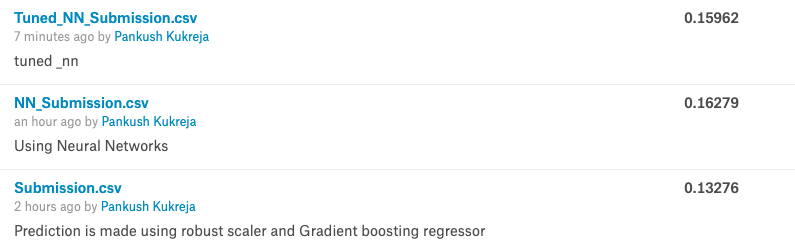